In [38]:
import time
from pathlib import Path
import textwrap

import numpy as np
import torch
import transformers
from transformers import (AutoConfig, AutoModelForCausalLM, AutoTokenizer,
                          BitsAndBytesConfig)


import os
os.chdir("/home/feline/master-generation")

#from modules.GPTQ_loader import load_quantized

import modules.shared as shared
from modules.model import load_model

import hashlib
import spacy
# Load the English language model
nlp = spacy.load("en_core_web_sm")
shared.nlp = nlp

#shared.model_name = "dolphin-2.6-mistral-7b-Mistral-7B-Instruct-v0.1"
#shared.model_name = "dolphin-2.9.4-llama3.1-8b"
#shared.model_name = "Meta-Llama-3.1-8B"
#shared.model_name = "google_gemma-2-9b"
#shared.model_name = "mistralai_Mistral-7B"
shared.model_name = "meta-llama_Llama-3.2-3B"

shared.act_order = True
print(f"Loading {shared.model_name}...")
t0 = time.time()
#shared.model = load_quantized(shared.model_name)
#shared.tokenizer = AutoTokenizer.from_pretrained(Path(f"models/{shared.model_name}/"))
#shared.tokenizer.truncation_side = 'left'

shared.groupsize = 128
shared.wbits = 4

shared.use_flash_attention_2 = False
shared.model, shared.tokenizer = load_model(shared.model_name, gptq = False, awq=False)

print(f"Loaded the model in {(time.time()-t0):.2f} seconds.")


import pandas as pd
df = pd.read_csv('Lancaster_sensorimotor_norms_for_39707_words.csv', header=0)  #the header is in the first row

shared.sensorimotor = df.set_index('Word').T.to_dict('dict')
#shared.classes = ['Auditory.mean', 'Gustatory.mean','Haptic.mean','Interoceptive.mean','Olfactory.mean','Visual.mean','Foot_leg.mean','Hand_arm.mean','Head.mean','Mouth.mean','Torso.mean']
shared.classes = ['Auditory', 'Gustatory','Haptic','Interoceptive','Olfactory','Visual','Foot_leg','Hand_arm','Head','Mouth','Torso']
#think if we want to remove classes that dominate others
#shared.classes = ['Gustatory','Haptic','Interoceptive','Olfactory','Foot_leg','Hand_arm','Mouth','Torso']
#shared.classes = ['Haptic', 'Gustatory','Haptic','Interoceptive','Olfactory','Olfactory','Foot_leg','Hand_arm','Mouth','Mouth','Torso']




#words = df.iloc[:, 0]
#value = df.iloc[:, 34]

#selected_columns = df[['Word', 'Dominant.sensorimotor']]  # Specify the columns you want to convert to a dictionary
#shared.sensorimotor = selected_columns.set_index('Word')['Dominant.sensorimotor'].to_dict()
#{'Visual': 22774, 'Auditory': 2690, 'Head': 7740, 'Torso': 223, 'Interoceptive': 1766, 'Mouth': 1166, 'Haptic': 649, 'Hand_arm': 1434, 'Gustatory': 661, 'Foot_leg': 428, 'Olfactory': 176}

#classes_to_remove = ['Torso', 'Haptic', 'Gustatory', 'Foot_leg', 'Olfactory']
#shared.sensorimotor = {item: class_name for item, class_name in shared.sensorimotor.items() if class_name not in classes_to_remove}

#shared.classes = list(set(shared.sensorimotor.values()))

from modules.text_generation import generate_reply

def secure_hash_for_sentence(last_sentence, range_min, range_max):
    doc = nlp(last_sentence)
    core_sentence = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    core_sentence_str = " ".join(core_sentence)
    print(core_sentence_str)
    
    hashed_sentence_bytes = hashlib.sha256(core_sentence_str.encode()).digest()
    hashed_sentence_integers = int.from_bytes(hashed_sentence_bytes[:4], byteorder='big')
    
    mapped_sentence_number = (hashed_sentence_integers % (range_max - range_min + 1)) + range_min
    return mapped_sentence_number


def secure_hash_for_token(last_token, range_min, range_max):
    hashed_token_bytes = hashlib.sha256(str(last_token.item()).encode()).digest()
    hashed_token_integers = int.from_bytes(hashed_token_bytes[:4], byteorder='big')
    
    mapped_token_number = (hashed_token_integers % (range_max - range_min + 1)) + range_min
    return mapped_token_number

def secure_hash_to_numbers(last_sentence, last_token, range_list):
    
    result_numbers = []
    
    # Compute the secure hash for the last token if last_token is not None
    if last_token is not None:
        token_hash = secure_hash_for_token(last_token, range_list[0][0], range_list[0][1])
    else:
        token_hash = shared.secret_key[0]  # Reuse the shared key if last_token is missing
    
    result_numbers.append(token_hash)
    
    # Compute the secure hash for the last sentence if last_sentence is not None
    if last_sentence is not None:
        sentence_hash = secure_hash_for_sentence(last_sentence, range_list[1][0], range_list[1][1])
    else:
        sentence_hash = shared.secret_key[1]  # Reuse the shared key if last_sentence is missing
    
    result_numbers.append(sentence_hash)
    
    return result_numbers

def get_last_sentence(text):
    doc = nlp(text)
    sentences = [sent.text for sent in doc.sents]
    if sentences:
        return sentences[-1]
    else:
        return None  # Return None if there are no sentences



Loading meta-llama_Llama-3.2-3B...
Loading meta-llama_Llama-3.2-3B...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loaded the model in 6.02 seconds.

Loaded the model in 6.02 seconds.


In [5]:
#question = "### Human: Explain in detail: What is the Nordschleife? ### Assistant:"

#question = "A chat between a human and an assistant. ### HUMAN: What is Formula One? ### ASSISTANT:"

#question = "What is Formula One?"
progress = 0

import random
from datasets import load_dataset
from transformers import AutoTokenizer

# Parameters
num_samples = 1  # Number of random samples to extract
num_tokens_trimmed = 200  # Number of tokens to trim from the end
tokenizer_name = "gpt2"  # Tokenizer model name

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)

# Load the RealNews-like subset of the C4 dataset
dataset = load_dataset("c4", "realnewslike", split="train")

# Function to tokenize and process text
def process_text(text, num_tokens_trimmed):
    # Tokenize the text
    tokens = tokenizer.tokenize(text)
    # Check if there are enough tokens to trim
    if len(tokens) <= num_tokens_trimmed:
        return None, None
    # Split tokens into prompt and baseline completion
    prompt_tokens = tokens[:-num_tokens_trimmed]
    baseline_tokens = tokens[-num_tokens_trimmed:]
    # Convert back to string format
    prompt = tokenizer.convert_tokens_to_string(prompt_tokens)
    baseline_completion = tokenizer.convert_tokens_to_string(baseline_tokens)
    return prompt, baseline_completion

# Select random samples
sampled_indices = random.sample(range(len(dataset)), num_samples)

# Process each sampled text
c4_random_samples = []
for idx in sampled_indices:
    text = dataset[idx]["text"]
    prompt, baseline_completion = process_text(text, num_tokens_trimmed)
    if prompt and baseline_completion:
        c4_random_samples.append({"prompt": prompt, "baseline_completion": baseline_completion})

# Display the results
# for i, result in enumerate(results):
#     print(f"Sample {i+1}:")
#     print("Prompt:", result["prompt"])
#     print("Baseline Completion:", result["baseline_completion"])
#     print("="*50)
results = []

print("Starting generation...")
for i, sample in enumerate(c4_random_samples):
    prompt = sample["prompt"]
    print(prompt)
    question = f'''<|begin_of_text|> {prompt}'''
    
    print(question)
    generate_params = {
        'max_new_tokens' : 200,
        'add_bos_token' : False,
        'truncation_length' : 4096,
        'custom_stopping_strings' : ["### Human:", "Human:", "user:", "USER:", "Q:","<|im_end|>","<|im_start|>system"],
        'ban_eos_token' : False,
        'skip_special_tokens' : False,
        'do_sample': False,
        'early_stopping': False,
        'seed' : 0,
    }
    shared.delta_senso = 0.0
    shared.delta_acro = 20.0
    shared.secret_key = [0,0]
    shared.new_sentence = False

    done = False
    reply_base = ""
    reply_current = ""
    current_question = question
    


    reply_base, done = generate_reply(current_question, generate_params, eos_token='<|end_of_text|>')#'<|im_end|>')

    shared.delta_senso = 2.5#2.5
    shared.delta_acro = 0.0#50
    shared.secret_key = [0,0]
    shared.new_sentence = False

    done = False
    reply_watermark = ""
    reply_current = ""
    current_question = question
    

    reply_watermark, done = generate_reply(current_question, generate_params, eos_token='<|end_of_text|>')#'<|im_end|>')


    #results.append([prompt,reply_base,reply_watermark])
    results.append([prompt,reply_base,reply_watermark])


    #reply_watermark = generate_reply(question+reply_watermark, generate_params, eos_token='<|im_end|>')
    progress += 1
    print(progress)
    print(prompt)
    print(f'''[{reply_base}]''')
    print(f'''[{reply_watermark}]''')


Loading dataset shards:   0%|          | 0/77 [00:00<?, ?it/s]

Starting generation...
Sept. 17 - Shares in Russia's Sistema tumble, following its chairman's arrest. But it could show Russia is back to a siege economy, says Reuters Breakingviews.
The chairman -- sustained by the Russian financial holding companies been placed under house arrest. That being comparisons. With you cross here there's also a link to sanctions and Ross Jeff's name is mentioned. As some are in this as well put it all together is yet we have so there's been I'm writing about is this morning. The -- but lying you take is is this this illustrates that brochures -- -- -- economy. Yes what does that mean. Well it they're back to the old authoritarian model of -- -- a -- of managing the economy did do it from -- in the economy has been pretty liberal. Under pretend. Where -- -- decent to 23 years ago. That way things to be who knew where not to do -- -- -- medal except through the indirect way of corrupt judges prosecutors and local officials. Which was. -- the cost of doing bu

TypeError: 'int' object is not iterable

In [2]:
import random
import json
from datasets import load_dataset
from transformers import AutoTokenizer
import itertools

# Assuming 'shared' and 'generate_reply' are defined elsewhere
# For example:
# import shared
# from your_module import generate_reply

# Initialize shared variables
shared.secret_key = [0, 0]
shared.new_sentence = False

# Parameters
num_samples = 1  # Number of random samples to extract (adjust as needed)
num_tokens_trimmed = 200  # Number of tokens to trim from the end
tokenizer_name = "gpt2"  # Tokenizer model name

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)

# Load the RealNews-like subset of the C4 dataset
dataset = load_dataset("c4", "realnewslike", split="train")

# Function to tokenize and process text
def process_text(text, num_tokens_trimmed):
    # Tokenize the text
    tokens = tokenizer.tokenize(text)
    # Check if there are enough tokens to trim
    if len(tokens) <= num_tokens_trimmed:
        return None, None
    # Split tokens into prompt and baseline completion
    prompt_tokens = tokens[:-num_tokens_trimmed]
    baseline_tokens = tokens[-num_tokens_trimmed:]
    # Convert back to string format
    prompt = tokenizer.convert_tokens_to_string(prompt_tokens)
    baseline_completion = tokenizer.convert_tokens_to_string(baseline_tokens)
    return prompt, baseline_completion

# Select random samples
sampled_indices = random.sample(range(len(dataset)), num_samples)

# Process each sampled text
c4_random_samples = []
for idx in sampled_indices:
    text = dataset[idx]["text"]
    prompt, baseline_completion = process_text(text, num_tokens_trimmed)
    if prompt and baseline_completion:
        c4_random_samples.append({"prompt": prompt, "baseline": baseline_completion})

# Define watermark feature settings
feature_levels = {
    # Uncomment and adjust the levels as needed
    #'weak': {'delta_senso': 1.0, 'delta_acro': 10.0, 'delta_redgreen': 1.0},
    'medium': {'delta_senso': 2.5, 'delta_acro': 20.0, 'delta_redgreen': 2.0},
    #'strong': {'delta_senso': 5.0, 'delta_acro': 40.0, 'delta_redgreen': 10.0}
}

# Define configurations
configurations = {
    'baseline': {
        'description': 'Baseline Completion (No LLM)',
        'type': 'baseline',
    },
    'llm_baseline': {
        'description': 'LLM Baseline (No Watermark)',
        'type': 'llm',
        'delta_senso': 0.0,
        'delta_acro': 0.0,
        'delta_redgreen': 0.0  # Initialize delta_redgreen
    }
}

# Add configurations for each feature individually and combinations with different levels
for level_name, levels in feature_levels.items():
    # Single feature: delta_senso
    configurations[f'llm_senso_{level_name}'] = {
        'description': f'LLM with delta_senso ({level_name} setting)',
        'type': 'llm',
        'delta_senso': levels['delta_senso'],
        'delta_acro': 0.0,
        'delta_redgreen': 0.0
    }
    # Single feature: delta_acro
    configurations[f'llm_acro_{level_name}'] = {
        'description': f'LLM with delta_acro ({level_name} setting)',
        'type': 'llm',
        'delta_senso': 0.0,
        'delta_acro': levels['delta_acro'],
        'delta_redgreen': 0.0
    }
    # Single feature: delta_redgreen
    configurations[f'llm_redgreen_{level_name}'] = {
        'description': f'LLM with delta_redgreen ({level_name} setting)',
        'type': 'llm',
        'delta_senso': 0.0,
        'delta_acro': 0.0,
        'delta_redgreen': levels['delta_redgreen']
    }
    # Combination: delta_senso and delta_acro
    configurations[f'llm_both_{level_name}'] = {
        'description': f'LLM with delta_senso and delta_acro ({level_name} setting)',
        'type': 'llm',
        'delta_senso': levels['delta_senso'],
        'delta_acro': levels['delta_acro'],
        'delta_redgreen': 0.0
    }
    # Combination: delta_senso and delta_redgreen
    configurations[f'llm_senso_redgreen_{level_name}'] = {
        'description': f'LLM with delta_senso and delta_redgreen ({level_name} setting)',
        'type': 'llm',
        'delta_senso': levels['delta_senso'],
        'delta_acro': 0.0,
        'delta_redgreen': levels['delta_redgreen']
    }
    # Combination: delta_acro and delta_redgreen
    configurations[f'llm_acro_redgreen_{level_name}'] = {
        'description': f'LLM with delta_acro and delta_redgreen ({level_name} setting)',
        'type': 'llm',
        'delta_senso': 0.0,
        'delta_acro': levels['delta_acro'],
        'delta_redgreen': levels['delta_redgreen']
    }
    # All three features together
    configurations[f'llm_all_three_{level_name}'] = {
        'description': f'LLM with delta_senso, delta_acro, and delta_redgreen ({level_name} setting)',
        'type': 'llm',
        'delta_senso': levels['delta_senso'],
        'delta_acro': levels['delta_acro'],
        'delta_redgreen': levels['delta_redgreen']
    }

# Function to generate replies based on configuration
def generate_replies(sample, config, generate_params):
    if config['type'] == 'baseline':
        return sample['baseline']
    elif config['type'] == 'llm':
        # Set watermark features
        shared.delta_senso = config.get('delta_senso', 0.0)
        shared.delta_acro = config.get('delta_acro', 0.0)
        shared.delta_redgreen = config.get('delta_redgreen', 0.0)  # Set delta_redgreen
        shared.secret_key = [0, 0]  # Adjust if needed per configuration
        shared.new_sentence = False  # Adjust if needed per configuration
        
        question = f'''<|begin_of_text|> {sample["prompt"]}'''
        reply, done = generate_reply(question, generate_params, eos_token='<|end_of_text|>')
        return reply
    else:
        raise ValueError("Unknown configuration type")

# Generation parameters (adjust as needed)
generate_params = {
    'max_new_tokens': 200,
    'add_bos_token': False,
    'truncation_length': 4096,
    'custom_stopping_strings': ["### Human:", "Human:", "user:", "USER:", "Q:", "<|im_end|>", "<|im_start|>system"],
    'ban_eos_token': False,
    'skip_special_tokens': True,
    'do_sample': False,
    'temperature': 0.7,
    'top_p': 0.95,
    'typical_p': 1,
    'repetition_penalty': 1.0,  # Adjust as needed
    'encoder_repetition_penalty': 1,
    'top_k': 40,
    'num_beams': 1,
    'penalty_alpha': 0,
    'min_length': 0,
    'length_penalty': 1,
    'no_repeat_ngram_size': 0,
    'early_stopping': False,
    'seed': 0,
}

# Initialize results list
results = []

print("Starting generation...")

# Iterate through each sample
for i, sample in enumerate(c4_random_samples, start=0):
    print(f"\nProcessing Sample {i+1}/{num_samples}")
    # Initialize the sample_result with prompt and baseline
    sample_result = {
        'prompt': sample['prompt'],
        'baseline': sample['baseline']
    }
    
    # Iterate through each configuration
    for config_name, config in configurations.items():
        description = config['description']
        print(f"  Generating for configuration: {description}")
        
        # Generate the reply based on the configuration
        try:
            reply = generate_replies(sample, config, generate_params)
        except Exception as e:
            print(f"    Error generating reply for {config_name}: {e}")
            reply = None  # Or handle as needed
        
        # Define the key for the configuration
        json_key = config_name  # e.g., 'llm_baseline', 'llm_senso_medium', etc.
        
        # Store the reply in the sample_result
        sample_result[json_key] = reply
    
    # Append the sample_result to results
    results.append(sample_result)
    
    print(f"Completed Sample {i+1}/{num_samples}")

# Save the results to a JSON file
output_filename = 'generation_results_gemma.json'
try:
    with open(output_filename, 'w', encoding='utf-8') as f:
        json.dump(results, f, ensure_ascii=False, indent=4)
    print(f"\nAll results have been saved to '{output_filename}'.")
except Exception as e:
    print(f"\nFailed to save results to '{output_filename}': {e}")

# Optionally, display or save the results
# For example, print the results for the first sample
# for i, sample in enumerate(results, start=1):
#     print(f"\n=== Sample {i} ===")
#     print("Prompt:", sample['prompt'])
#     print("Baseline Completion:", sample['baseline'])
#     for config, reply in sample.items():
#         if config not in ['prompt', 'baseline']:
#             print(f"\n[{config}] {configurations[config]['description']}:")
#             print(reply)
#             print("-" * 50)


/home/feline/miniconda3/envs/textgen/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/home/feline/miniconda3/envs/textgen/lib/python3.9/site-packages/datasets/load.py:1486: FutureWarning: The repository for c4 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/c4
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
/home/feline/.cache/huggingface/modules/datasets_modules/datasets/c4/584d57ebe81c209b6c7f31727066d

Loading dataset shards:   0%|          | 0/77 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (4484 > 1024). Running this sequence through the model will result in indexing errors


Starting generation...

Processing Sample 1/1
  Generating for configuration: Baseline Completion (No LLM)
  Generating for configuration: LLM Baseline (No Watermark)


/home/feline/miniconda3/envs/textgen/lib/python3.9/site-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/home/feline/miniconda3/envs/textgen/lib/python3.9/site-packages/transformers/generation/configuration_utils.py:572: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.95` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos t

  Generating for configuration: LLM with delta_senso (medium setting)


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


  Generating for configuration: LLM with delta_acro (medium setting)


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


  Generating for configuration: LLM with delta_redgreen (medium setting)


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


  Generating for configuration: LLM with delta_senso and delta_acro (medium setting)


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


  Generating for configuration: LLM with delta_senso and delta_redgreen (medium setting)


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


  Generating for configuration: LLM with delta_acro and delta_redgreen (medium setting)


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


  Generating for configuration: LLM with delta_senso, delta_acro, and delta_redgreen (medium setting)


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Completed Sample 1/1

All results have been saved to 'generation_results_gemma.json'.


In [1]:
import os
import json
import spacy
import hashlib
from scipy.stats import norm, binom
import math
import pandas as pd
import modules.shared as shared  # Ensure this path is correct
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

# Set the working directory
os.chdir("/home/feline/master-generation")

# Load SpaCy English model
try:
    nlp = spacy.load('en_core_web_sm')
except OSError:
    raise OSError("SpaCy model 'en_core_web_sm' not found. Please install it using:\n"
                  "python -m spacy download en_core_web_sm")

# Load Sensorimotor Norms Data
# Ensure the CSV file 'updated_word_frequencies_with_percent.csv' is in the working directory
try:
    df = pd.read_csv('updated_word_frequencies_with_percent.csv', header=0)
except FileNotFoundError:
    raise FileNotFoundError("The file 'updated_word_frequencies_with_percent.csv' was not found. "
                            "Please ensure it is present in the working directory.")

# Populate shared.sensorimotor as a dictionary with uppercase words as keys
shared.sensorimotor = df.set_index('Word').T.to_dict('dict')

shared.classes = ['Auditory', 'Gustatory','Haptic','Interoceptive','Olfactory','Visual','Foot_leg','Hand_arm','Head','Mouth','Torso']



# Initialize secret key
shared.secret_key = [0, 0]  # [sensorimotor_class, acrostic_letter]

# Calculate baseline probabilities for each sensorimotor class
def compute_p_class(df, classes):
    """
    Computes the baseline probability for each sensorimotor class based on Word_Percent.
    
    Parameters:
    - df (pd.DataFrame): DataFrame containing sensorimotor norms with 'Dominant.sensorimotor' and 'Word_Percent' columns.
    - classes (List[str]): List of sensorimotor classes.
    
    Returns:
    - dict: A dictionary mapping each class to its baseline probability.
    """
    p_class_dict = {}
    total_word_percent = df['Word_Percent'].sum()
    print(f"Total Word_Percent: {total_word_percent}")
    
    for cls in classes:
        # Sum Word_Percent for words where Dominant.sensorimotor == cls
        class_word_percent = df[df['Dominant.sensorimotor'] == cls]['Word_Percent'].sum()
        p = class_word_percent / total_word_percent if total_word_percent > 0 else 0.0

        # Adjust probability
        p *= 1.5
        if (p < 0.15):
            p = 0.15
        p_class_dict[cls] = p
        
        print(f"Class: {cls}, Word_Percent Sum: {class_word_percent}, p_class: {p:.6f}")
    
    return p_class_dict

p_class_dict = compute_p_class(df, shared.classes)
# -----------------------------------
# 3. Utility Functions
# -----------------------------------

def split_into_sentences(text):
    """
    Splits the input text into sentences using SpaCy's sentence segmentation.
    
    Parameters:
    - text (str): The text to split.
    
    Returns:
    - List[str]: A list of sentences.
    """
    doc = nlp(text)
    sentences = [sent.text.strip() for sent in doc.sents]
    return sentences

def get_words_in_sentence(sentence):
    """
    Extracts words from a sentence, excluding punctuation and spaces.
    
    Parameters:
    - sentence (str): The sentence to process.
    
    Returns:
    - List[str]: A list of words.
    """
    doc = nlp(sentence)
    words = [token.text for token in doc if not token.is_punct and not token.is_space]
    return words

def secure_hash_for_word(word, range_min, range_max):
    """
    Generates a secure hash for a word and maps it to a number within a specified range.
    
    Parameters:
    - word (str): The word to hash.
    - range_min (int): The minimum value of the range.
    - range_max (int): The maximum value of the range.
    
    Returns:
    - int: The mapped number within [range_min, range_max].
    """
    hashed_word_bytes = hashlib.sha256(word.encode()).digest()
    hashed_word_int = int.from_bytes(hashed_word_bytes[:4], byteorder='big')
    mapped_number = (hashed_word_int % (range_max - range_min + 1)) + range_min
    return mapped_number

def secure_hash_for_sentence(sentence, range_min, range_max):
    """
    Generates a secure hash for a sentence (lemmatized, excluding stopwords and punctuation)
    and maps it to a number within a specified range.
    
    Parameters:
    - sentence (str): The sentence to hash.
    - range_min (int): The minimum value of the range.
    - range_max (int): The maximum value of the range.
    
    Returns:
    - int: The mapped number within [range_min, range_max].
    """
    doc = nlp(sentence)
    core_sentence = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    core_sentence_str = " ".join(core_sentence)
    
    hashed_sentence_bytes = hashlib.sha256(core_sentence_str.encode()).digest()
    hashed_sentence_int = int.from_bytes(hashed_sentence_bytes[:4], byteorder='big')
    mapped_number = (hashed_sentence_int % (range_max - range_min + 1)) + range_min
    return mapped_number

# -----------------------------------
# 4. Probability Calculation Function
# -----------------------------------

def calculate_probs(reply):
    """
    Calculates the watermark probabilities for a given text reply.
    
    This function evaluates both the sensorimotor and acrostic features to determine
    the likelihood that the text contains a watermark.
    
    Parameters:
    - reply (str): The text to analyze.
    
    Returns:
    - Tuple containing:
        - final_score (float): Combined probability indicating watermark presence.
        - snsorimotor_prob: Probability from sensorimotor feature using binomial SF.
        - acrostic_prob (float): Probability from acrostic feature using binomial PMF.
        - num_sentences (int): Total number of sentences in the text.
        - correct_acrosticons (int): Number of sentences with correct acrostic.
        - total_words (int): Total number of words processed.
        - correct_words (int): Number of words matching sensorimotor class.
        - sensorimotor_matches (int): Number of sensorimotor matches across all classes.
        - sensorimotor_matches_per_class (dict): Number of matches per sensorimotor class.
    """
    # Reset the secret key to initial value for each analysis
    shared.secret_key = [0, 0]
    
    probabilities = []
    correct_acrosticons = 0
    sensorimotor_matches = 0
    sensorimotor_matches_per_class = {cls: 0 for cls in shared.classes}
    sensorimotor_total_per_class = {cls: 0 for cls in shared.classes}
    total_words = 0
    correct_words = 0
    
    # Split the text into sentences
    sentences = split_into_sentences(reply)
    sensorimotor_class = shared.secret_key[0]
    for idx, sentence in enumerate(sentences, start=1):
        words = get_words_in_sentence(sentence)
        if not words:
            continue  # Skip empty sentences
        
        for word_idx, word in enumerate(words):
            total_words += 1
            
            if word_idx == 0 and idx > 1:
                # For the first word of each sentence (excluding the first sentence), check acrostic
                expected_start = chr(ord('A') + (shared.secret_key[1] % 26))
                actual_start = word[0].strip().upper()
                if actual_start == expected_start:
                    correct_acrosticons += 1
            
            # Retrieve current sensorimotor class from the key
            if 0 <= sensorimotor_class < len(shared.classes):
                selected_class = shared.classes[sensorimotor_class]
                word_upper = word.strip().upper()
                
                if word_upper in shared.sensorimotor:
                    # Check if the word's dominant sensorimotor class matches the selected class
                    if shared.sensorimotor[word_upper]["Dominant.sensorimotor"] == selected_class:
                        sensorimotor_matches_per_class[selected_class] += 1
                        sensorimotor_matches += 1
                    
                    correct_words += 1
                    sensorimotor_total_per_class[selected_class] += 1
                else:
                    # Word not found in sensorimotor dictionary; optionally handle or skip
                    pass
            else:
                # Invalid sensorimotor class; optionally handle or assign default probability
                pass
            
            # Update sensorimotor key based on the current word for the next word's class
            sensorimotor_hash = secure_hash_for_word(word, 0, 10)
            sensorimotor_class = shared.secret_key[0]
            shared.secret_key[0] = sensorimotor_hash
        
        # After processing all words in the sentence, update acrostic key based on sentence hash
        sentence_hash = secure_hash_for_sentence(sentence, 0, 25)
        shared.secret_key[1] = sentence_hash
    
    # Calculate acrostic probability using Binomial PMF
    num_acrostic_checks = len(sentences) - 1 if len(sentences) > 1 else 0
    if num_acrostic_checks > 0:
        acrostic_prob = binom.sf(correct_acrosticons - 1, num_acrostic_checks, 1/26)
    else:
        acrostic_prob = 1.0  # No acrostic checks performed
    
    # Calculate sensorimotor probability using Binomial Survival Function (P(X >= k)) for each class
    sensorimotor_prob = 1.0  # Initialize as 1 (since we'll multiply probabilities)
    for cls in shared.classes:
        k = sensorimotor_matches_per_class[cls]
        n = sensorimotor_total_per_class[cls]
        p = p_class_dict.get(cls, 0.0)
        
        if n > 0 and p > 0:
            prob = binom.sf(k-1, n, p)
            sensorimotor_prob *= prob  # Assuming independence across classes
        elif n == 0:
            # If no trials for this class, skip
            continue
        else:
            # If p is 0, and k >0, prob should be 0; else 1
            prob = 0.0 if k > 0 else 1.0
            sensorimotor_prob *= prob

    # Final combined probability indicating watermark presence
    final_score = acrostic_prob * sensorimotor_prob
    
    return (
        final_score,
        sensorimotor_prob,
        acrostic_prob,
        len(sentences),
        correct_acrosticons,
        total_words,
        correct_words,
        sensorimotor_matches,
        sensorimotor_matches_per_class
    )

# -----------------------------------
# 5. Load Generated Results and Run Detection
# -----------------------------------

# Path to the generated JSON file
generated_json_path = 'generation_results.json'  # Update if different

# Path to save the detection results
detection_json_path = 'detection_results.json'

# Load the generated JSON
try:
    with open(generated_json_path, 'r', encoding='utf-8') as f:
        generated_data = json.load(f)
    print(f"Successfully loaded '{generated_json_path}'.")
except FileNotFoundError:
    raise FileNotFoundError(f"The file '{generated_json_path}' was not found. Please ensure it is present in the working directory.")
except json.JSONDecodeError as e:
    raise ValueError(f"Error decoding JSON from '{generated_json_path}': {e}")

# Initialize a list to store detection scores
detection_results = []

print("Starting detection...")

# Iterate through each sample in the generated data
for idx, sample in enumerate(generated_data, start=1):
    prompt = sample.get('prompt', '')
    print(f"\nProcessing Sample {idx}:")
    print(f"Prompt: \"{prompt}\"")
    
    # Initialize a dict to store detection scores for this sample
    sample_detection = {
        'prompt': prompt,
        'detection': {}
    }
    
    # Iterate through each key in the sample
    for key, text in sample.items():
        if key == 'prompt':
            continue  # Skip the prompt itself
        
        print(f"  Running detection for '{key}'...")
        
        try:
            # Run the detection algorithm
            (
                final_score,
                sensorimotor_prob,
                acrostic_prob,
                num_sentences,
                correct_acrosticons,
                total_words,
                correct_words,
                sensorimotor_matches,
                sensorimotor_matches_per_class
            ) = calculate_probs(text)
            
            # Store the detection results
            sample_detection['detection'][key] = {
                'final_score': final_score,
                'sensorimotor_prob': sensorimotor_prob,
                'acrostic_prob': acrostic_prob,
                'num_sentences': num_sentences,
                'correct_acrosticons': correct_acrosticons,
                'total_words': total_words,
                'correct_words': correct_words,
                'sensorimotor_matches': sensorimotor_matches,
                'sensorimotor_matches_per_class': sensorimotor_matches_per_class
            }
            
            print(f"    Detection completed for '{key}'.")
        
        except Exception as e:
            print(f"    Error during detection for '{key}': {e}")
            sample_detection['detection'][key] = {
                'error': str(e)
            }
    
    # Append the detection results for this sample
    detection_results.append(sample_detection)
    
    print(f"Completed Detection for Sample {idx}.")

# -----------------------------------
# 6. Save Detection Results to JSON
# -----------------------------------

try:
    with open(detection_json_path, 'w', encoding='utf-8') as f:
        json.dump(detection_results, f, ensure_ascii=False, indent=4)
    print(f"\nAll detection results have been saved to '{detection_json_path}'.")
except Exception as e:
    print(f"\nFailed to save detection results to '{detection_json_path}': {e}")

# -----------------------------------
# 7. Optional: Display Detection Results
# -----------------------------------

# Uncomment the following block if you want to print detection results to the console
"""
for idx, sample in enumerate(detection_results, start=1):
    print(f"\n=== Detection Results for Sample {idx} ===")
    print(f"Prompt: \"{sample['prompt']}\"\n")
    
    for text_type, detection in sample['detection'].items():
        print(f"[{text_type}] Detection Results:")
        if 'error' in detection:
            print(f"  Error: {detection['error']}")
        else:
            print(f"  Final Score: {detection['final_score']:.6f}")
            print(f"  Acrostic Probability: {detection['acrostic_prob']:.6f}")
            print(f"  Number of Sentences: {detection['num_sentences']}")
            print(f"  Correct Acrosticons: {detection['correct_acrosticons']}")
            print(f"  Total Words: {detection['total_words']}")
            print(f"  Correct Words: {detection['correct_words']}")
            print(f"  Sensorimotor Matches: {detection['sensorimotor_matches']}")
            print(f"  Sensorimotor Matches per Class:")
            for cls, count in detection['sensorimotor_matches_per_class'].items():
                print(f"    {cls}: {count}")
            print("\n")
        print("-" * 50)
"""


ModuleNotFoundError: No module named 'modules'

In [3]:
import csv

# Specify the file name
file_name = "output_gen9.csv"

# Open the file in write mode with newline='' to ensure correct line endings
with open(file_name, 'w', newline='') as csv_file:
    # Create a CSV writer object
    csv_writer = csv.writer(csv_file)

    # Write the data to the CSV file
    csv_writer.writerows(results)



p_class_dict = {}
total_words = df['Dominant.sensorimotor'].notnull().sum()

for cls in shared.classes:
    count = (df['Dominant.sensorimotor'] == cls).sum()
    p = count / total_words if total_words > 0 else 0.0
    p_class_dict[cls] = p
    print(f"Class: {cls}, Count: {count}, p_class: {p:.6f}")


Class: Auditory, Count: 2690, p_class: 0.067746
Class: Gustatory, Count: 661, p_class: 0.016647
Class: Haptic, Count: 649, p_class: 0.016345
Class: Interoceptive, Count: 1766, p_class: 0.044476
Class: Olfactory, Count: 176, p_class: 0.004432
Class: Visual, Count: 22774, p_class: 0.573551
Class: Foot_leg, Count: 428, p_class: 0.010779
Class: Hand_arm, Count: 1434, p_class: 0.036115
Class: Head, Count: 7740, p_class: 0.194928
Class: Mouth, Count: 1166, p_class: 0.029365
Class: Torso, Count: 223, p_class: 0.005616


In [4]:
import csv
import os
os.chdir("/home/feline/master-generation")

def load_csv_to_list(filename):
    data_list = []
    with open(filename, 'r', encoding='utf-8') as file:
        csv_reader = csv.reader(file)
        for row in csv_reader:
            # Assuming each row has the format: [prompt, reply_base, reply_watermark]
            if len(row) == 3:  # Making sure the row has exactly 3 elements
                data_list.append(row)
    return data_list

# Example usage
filename = 'output_gen9.csv'
results = load_csv_to_list(filename)

for res in results: 
    print(f'''"{res[1]}",''')


import pandas as pd
#df = pd.read_csv('Lancaster_sensorimotor_norms_for_39707_words.csv', header=0)
df = pd.read_csv('updated_word_frequencies_with_percent.csv', header=0)
visual_count = df['Dominant.sensorimotor'].str.count('Olfactory').sum()
print(visual_count)


".”
Wilson, Lajčák said, was a visionary who stood up against a powerful and aggressive empire and called on the US to take a strong stance against it.
“He also stood up for a world free of war, which he advocated as the only way to ensure lasting peace,” the minister added. XI.
Wilson, who served as US president from 1913 to 1921, was awarded the Nobel Peace Prize in 1919 for his role in the creation of the League of Nations and his efforts to promote national self-determination.
He died on February 3, 1924, aged 67. During his lifetime he was known as a scholar, historian, lawyer and university president. In 1913, he was elected the 28th president of the United States of America.
Wilson’s legacy
In 1919, Masaryk sent a message to the American nation to thank the US for its role in the foundation of an independent Czechoslovakia. XI",
176


In [39]:
import os
import json
import spacy
import hashlib
from scipy.stats import norm, binom
import math
import pandas as pd
import modules.shared as shared  # Ensure this path is correct
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Set the working directory
os.chdir("/home/feline/master-generation")

# -----------------------------------
# 1. Load SpaCy English model
# -----------------------------------
try:
    nlp = spacy.load('en_core_web_sm')
except OSError:
    raise OSError("SpaCy model 'en_core_web_sm' not found. Please install it using:\n"
                  "python -m spacy download en_core_web_sm")

# -----------------------------------
# 2. Load Sensorimotor Norms Data
# -----------------------------------
# Ensure the CSV file 'updated_word_frequencies_with_percent.csv' is in the working directory
try:
    df = pd.read_csv('updated_word_frequencies_with_percent.csv', header=0)
except FileNotFoundError:
    raise FileNotFoundError("The file 'updated_word_frequencies_with_percent.csv' was not found. "
                            "Please ensure it is present in the working directory.")

# Populate shared.sensorimotor as a dictionary with uppercase words as keys
shared.sensorimotor = df.set_index('Word').T.to_dict('dict')

# -----------------------------------
# 3. Define Sensorimotor Classes and Statistics
# -----------------------------------
classes_mean = [
    'Auditory.mean', 'Gustatory.mean', 'Haptic.mean', 'Interoceptive.mean',
    'Olfactory.mean', 'Visual.mean', 'Foot_leg.mean', 'Hand_arm.mean',
    'Head.mean', 'Mouth.mean', 'Torso.mean'
]
shared.classes = ['Auditory', 'Gustatory','Haptic','Interoceptive','Olfactory','Visual','Foot_leg','Hand_arm','Head','Mouth','Torso']

# Define mean and standard deviation for each sensorimotor class
mean_value = [1.51, 0.32, 1.07, 1.03, 0.39, 2.90, 0.81, 1.45, 2.28, 1.26, 0.82]
std_deviation = [0.99, 0.70, 0.93, 0.88, 0.62, 0.90, 0.75, 0.91, 0.72, 0.90, 0.67]

# Initialize secret key
shared.secret_key = [0, 0]  # [sensorimotor_class, acrostic_letter]

# -----------------------------------
# 4. Compute Baseline Probabilities
# -----------------------------------
def compute_p_class(df, classes):
    """
    Computes the baseline probability for each sensorimotor class based on Word_Percent.
    
    Parameters:
    - df (pd.DataFrame): DataFrame containing sensorimotor norms with 'Dominant.sensorimotor' and 'Word_Percent' columns.
    - classes (List[str]): List of sensorimotor classes.
    
    Returns:
    - dict: A dictionary mapping each class to its baseline probability.
    """
    p_class_dict = {}
    total_word_percent = df['Word_Percent'].sum()
    print(f"Total Word_Percent: {total_word_percent}")
    
    llm_baseline = {
        "Auditory": 0.1794,
        "Gustatory": 0.0025,
        "Haptic": 0.0056,
        "Interoceptive": 0.0186,
        "Olfactory": 0.0014,
        "Visual": 0.4659,
        "Foot_leg": 0.0175,
        "Hand_arm": 0.0231,
        "Head":  0.2735,
        "Mouth": 0.0090,
        "Torso": 0.0034
    }
    for cls in classes:
        # Sum Word_Percent for words where Dominant.sensorimotor == cls
        class_word_percent = df[df['Dominant.sensorimotor'] == cls]['Word_Percent'].sum()
        p = class_word_percent / total_word_percent if total_word_percent > 0 else 0.0

        #change from goole ngrams to my own stats:
        #p = llm_baseline.get(cls, 0.0)
        #p_class_dict[cls] = p
        
        print(f"Class: {cls}, Word_Percent Sum: {class_word_percent}, p_class: {p:.6f}")
    
    return p_class_dict

p_class_dict = compute_p_class(df, shared.classes)

# -----------------------------------
# 5. Utility Functions
# -----------------------------------
def split_into_sentences(text):
    """
    Splits the input text into sentences using SpaCy's sentence segmentation.
    
    Parameters:
    - text (str): The text to split.
    
    Returns:
    - List[str]: A list of sentences.
    """
    doc = nlp(text)
    sentences = [sent.text.strip() for sent in doc.sents]
    return sentences

def get_words_in_sentence(sentence):
    """
    Extracts words from a sentence, excluding punctuation and spaces.
    
    Parameters:
    - sentence (str): The sentence to process.
    
    Returns:
    - List[str]: A list of words.
    """
    doc = nlp(sentence)
    words = [token.text for token in doc if not token.is_punct and not token.is_space]
    return words

def secure_hash_for_word(word, range_min, range_max):
    """
    Generates a secure hash for a word and maps it to a number within a specified range.
    
    Parameters:
    - word (str): The word to hash.
    - range_min (int): The minimum value of the range.
    - range_max (int): The maximum value of the range.
    
    Returns:
    - int: The mapped number within [range_min, range_max].
    """
    hashed_word_bytes = hashlib.sha256(word.encode()).digest()
    hashed_word_int = int.from_bytes(hashed_word_bytes[:4], byteorder='big')
    mapped_number = (hashed_word_int % (range_max - range_min + 1)) + range_min
    return mapped_number

def secure_hash_for_sentence(sentence, range_min, range_max):
    """
    Generates a secure hash for a sentence (lemmatized, excluding stopwords and punctuation)
    and maps it to a number within a specified range.
    
    Parameters:
    - sentence (str): The sentence to hash.
    - range_min (int): The minimum value of the range.
    - range_max (int): The maximum value of the range.
    
    Returns:
    - int: The mapped number within [range_min, range_max].
    """
    doc = nlp(sentence)
    core_sentence = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    core_sentence_str = " ".join(core_sentence)
    
    hashed_sentence_bytes = hashlib.sha256(core_sentence_str.encode()).digest()
    hashed_sentence_int = int.from_bytes(hashed_sentence_bytes[:4], byteorder='big')
    mapped_number = (hashed_sentence_int % (range_max - range_min + 1)) + range_min
    return mapped_number

# -----------------------------------
# 6. Load the OPT-2.7B Model for Perplexity Calculation
# -----------------------------------
print("\nLoading OPT-2.7B model for perplexity calculation...")
try:
    tokenizer_opt = shared.model#AutoTokenizer.from_pretrained("facebook/opt-2.7b")
    model_opt = shared.tokenizer#AutoModelForCausalLM.from_pretrained("facebook/opt-2.7b")
    #model_opt.eval()
    
    # Move model to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    #model_opt.to(device)
    #print(f"Model loaded successfully on {device}.")
except Exception as e:
    raise RuntimeError(f"Failed to load OPT-2.7B model: {e}")

# -----------------------------------
# 7. Probability Calculation Function (Updated)
# -----------------------------------
def calculate_probs(reply):
    """
    Calculates the watermark probabilities for a given text reply.

    This function evaluates the sensorimotor, acrostic, and redgreen watermark features
    to determine the likelihood that the text contains a watermark.

    Parameters:
    - reply (str): The text to analyze.

    Returns:
    - Tuple containing:
        - final_score (float): Combined probability indicating watermark presence.
        - acrostic_prob (float): Probability from acrostic feature using binomial PMF.
        - sensorimotor_prob (float): Probability from sensorimotor feature.
        - redgreen_z_score (float): Z-score from redgreen watermark detection.
        - len(sentences) (int): Total number of sentences in the text.
        - correct_acrosticons (int): Number of sentences with correct acrostic.
        - total_words (int): Total number of words processed.
        - correct_words (int): Number of words matching sensorimotor class.
        - sensorimotor_matches (int): Number of sensorimotor matches across all classes.
        - sensorimotor_matches_per_class (dict): Number of matches per sensorimotor class.
    """
    # Reset the secret key to initial value for each analysis
    shared.secret_key = [0, 0]

    z_scores = []
    probabilities = []
    correct_acrosticons = 0
    sensorimotor_matches = 0
    sensorimotor_matches_per_class = {cls: 0 for cls in shared.classes}
    sensorimotor_total_per_class = {cls: 0 for cls in shared.classes}
    total_words = 0
    correct_words = 0

    # Tokenize the reply using the same tokenizer used in generation
    tokenizer = shared.tokenizer  # Ensure shared.tokenizer is defined and is the same as used in generation
    tokens = tokenizer.encode(reply, add_special_tokens=False)
    vocab_size = len(tokenizer)

    # Variables for redgreen watermark detection
    gamma = 0.5  # Proportion of green list used during generation
    in_green_list = 0  # Number of tokens in the green list
    T = len(tokens) - 1  # Number of transitions (from token i to token i+1)

    # Split the text into sentences
    sentences = split_into_sentences(reply)
    sensorimotor_class = shared.secret_key[0]
    token_idx = 0  # Index to keep track of token positions

    for idx, sentence in enumerate(sentences, start=1):
        words = get_words_in_sentence(sentence)
        if not words:
            continue  # Skip empty sentences

        for word_idx, word in enumerate(words):
            total_words += 1

            if word_idx == 0 and idx > 1:
                # For the first word of each sentence (excluding the first sentence), check acrostic
                expected_start = chr(ord('A') + (shared.secret_key[1] % 26))
                actual_start = word[0].strip().upper()
                if actual_start == expected_start:
                    correct_acrosticons += 1

            else:# Retrieve current sensorimotor class from the key
                if 0 <= sensorimotor_class < len(shared.classes):
                    selected_class_mean = classes_mean[sensorimotor_class]
                    selected_class = shared.classes[sensorimotor_class]
                    word_upper = word.strip().upper()

                    if word_upper in shared.sensorimotor:
                        # Check if the word's dominant sensorimotor class matches the selected class
                        if shared.sensorimotor[word_upper]["Dominant.sensorimotor"] == selected_class:
                            sensorimotor_matches_per_class[selected_class] += 1
                            sensorimotor_matches += 1
                        word_mean = shared.sensorimotor[word_upper][selected_class_mean]
                        word_z = (word_mean - mean_value[sensorimotor_class]) / std_deviation[sensorimotor_class]
                        word_prob = 1 - norm.cdf(word_z)

                        # Accumulate z-scores and probabilities
                        z_scores.append(word_z)
                        probabilities.append(word_prob)
                        correct_words += 1
                        sensorimotor_total_per_class[selected_class] += 1
                    else:
                        # Word not found in sensorimotor dictionary; optionally handle or skip
                        pass
                else:
                    # Invalid sensorimotor class; optionally handle or assign default probability
                    pass

            # Update sensorimotor key based on the current word for the next word's class
            sensorimotor_hash = secure_hash_for_word(word, 0, 10)
            sensorimotor_class = shared.secret_key[0]
            shared.secret_key[0] = sensorimotor_hash

            # Redgreen Watermark Detection
            if token_idx < T:
                last_token = tokens[token_idx]
                current_token = tokens[token_idx + 1]

                # Hash function as used during generation
                def default_hash_fn(token_id):
                    return int(hashlib.sha256(str(token_id).encode('utf-8')).hexdigest(), 16) % (10 ** 8)

                # Seed the random generator based on the last token
                seed = default_hash_fn(last_token)
                generator = torch.Generator(device='cuda:0').manual_seed(seed)

                # Generate a random permutation of the vocabulary
                gli = torch.randperm(vocab_size, generator=generator, device='cuda:0')

                # Define the green list size
                gls = int(gamma * vocab_size)  # Green list size

                # Check if the current token is in the green list
                # We use torch.where to find the position of the current token in the permutation
                token_position = (gli == current_token).nonzero(as_tuple=True)[0].item()
                if token_position < gls:
                    in_green_list += 1

            token_idx += 1  # Move to the next token

        # After processing all words in the sentence, update acrostic key based on sentence hash
        sentence_hash = secure_hash_for_sentence(sentence, 0, 25)
        shared.secret_key[1] = sentence_hash

    # Calculate acrostic probability using Binomial PMF
    num_acrostic_checks = len(sentences) - 1 if len(sentences) > 1 else 0
    if num_acrostic_checks > 0:
        acrostic_prob = binom.sf(correct_acrosticons - 1, num_acrostic_checks, 1/26)
    else:
        acrostic_prob = 1.0  # No acrostic checks performed

    # Calculate sensorimotor probability using Binomial Survival Function (P(X >= k - 1)) for each class
    sensorimotor_prob = 1.0  # Initialize as 1 (since we'll multiply probabilities)

    for cls in shared.classes:
        k = sensorimotor_matches_per_class[cls]
        n = sensorimotor_total_per_class[cls]
        p = p_class_dict.get(cls, 0.0)

        if n > 0 and p > 0:
            # Adjust k to allow one "lucky" hit that does not influence the probability
            adjusted_k = max(k - 1, 0)
            prob = binom.sf(adjusted_k - 1, n, p)  # P(X >= adjusted_k)
            sensorimotor_prob *= prob  # Assuming independence across classes
        elif n == 0:
            # If no trials for this class, probability is 1.0 (no influence)
            prob = 1.0
            sensorimotor_prob *= prob
        else:
            # If p is 0, and k > 0, prob should be 0; else 1
            prob = 0.0 if k > 0 else 1.0
            sensorimotor_prob *= prob

    # Optionally, handle the case where there are no classes processed
    # (if shared.classes can be empty)
    sensorimotor_prob = binom.sf(sensorimotor_matches - 1, correct_words, 1/10)
    if not shared.classes:
        sensorimotor_prob = 1.0
    # Redgreen Watermark Detection using Z-score
    if T > 0:
        expected_in_green = gamma * T- len(sentences) + 1
        variance = T * gamma * (1 - gamma)
        redgreen_z_score = (in_green_list - expected_in_green) / math.sqrt(variance)

        # Convert z-score to probability (one-tailed test)
        redgreen_prob = norm.sf(redgreen_z_score)
    else:
        redgreen_z_score = 0.0  # No tokens to compare
        redgreen_prob = 1.0     # Default probability when no tokens

    # Final combined probability indicating watermark presence
    # You can combine probabilities as needed, here I'm just using them separately
    final_score = acrostic_prob * sensorimotor_prob * redgreen_prob # Adjust if you want to include redgreen watermark

    return (
        final_score,
        sensorimotor_prob,
        acrostic_prob,
        redgreen_prob,
        len(sentences),
        correct_acrosticons,
        total_words,
        correct_words,
        sensorimotor_matches,
        sensorimotor_matches_per_class
    )

# -----------------------------------
# 8. Function to Calculate Perplexity
# -----------------------------------
def calculate_perplexity(text, model, tokenizer):
    # Tokenize the text and move tensors to GPU
    inputs = tokenizer(text, return_tensors="pt")
    input_ids = inputs.input_ids.to(device)
    attention_mask = inputs.attention_mask.to(device)

    # Get the logits from the model
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

    # Shift the logits and input_ids for the cross-entropy loss calculation
    shift_logits = logits[:, :-1, :].contiguous()
    shift_labels = input_ids[:, 1:].contiguous()

    # Compute cross-entropy loss
    loss = F.cross_entropy(shift_logits.view(-1, shift_logits.size(-1)),
                           shift_labels.view(-1),
                           reduction='mean')

    # Calculate perplexity
    perplexity = torch.exp(loss).item()

    return perplexity
# -----------------------------------
# 9. Load Generated Results and Run Detection with Perplexity
# -----------------------------------

# Path to the generated JSON file
generated_json_path = 'attacked_data_llama3b.json'  # Update if different

# Path to save the detection results
detection_json_path = 'attacked_results_llama3b.json'

# Load the generated JSON
try:
    with open(generated_json_path, 'r', encoding='utf-8') as f:
        generated_data = json.load(f)
    print(f"Successfully loaded '{generated_json_path}'.")
except FileNotFoundError:
    raise FileNotFoundError(f"The file '{generated_json_path}' was not found. Please ensure it is present in the working directory.")
except json.JSONDecodeError as e:
    raise ValueError(f"Error decoding JSON from '{generated_json_path}': {e}")

detection_results = []

print("\nStarting detection and perplexity calculations...")

for idx, sample in enumerate(generated_data, start=1): 
    prompt = sample.get('prompt', '') 
    print(f"\nProcessing Sample {idx}:")
    # Initialize a dict to store detection scores for this sample
    sample_detection = {
        'prompt': prompt,
        'outputs': {},
        'detection': {}
    }

    # Extract and store outputs
    for key, text in sample.items():
        if key == 'prompt':
            continue  # Skip the prompt itself
        sample_detection['outputs'][key] = text

    # Iterate through each key in the sample for detection
    for key, text in sample.items():
        if key == 'prompt':
            continue  # Skip the prompt itself
        
        print(f"  Running detection for '{key}'...")
        
        try:
            # Run the detection algorithm
            (
                final_score,
                sensorimotor_prob,
                acrostic_prob,
                redgreen_prob,
                num_sentences,
                correct_acrosticons,
                total_words,
                correct_words,
                sensorimotor_matches,
                sensorimotor_matches_per_class
            ) = calculate_probs(text)
            
            # Calculate perplexity
            perplexity = calculate_perplexity(text, tokenizer_opt, model_opt)
            
            # Store the detection and perplexity results
            sample_detection['detection'][key] = {
                'final_score': final_score,
                'sensorimotor_prob': sensorimotor_prob,
                'acrostic_prob': acrostic_prob,
                "redgreen_prob": redgreen_prob,
                'num_sentences': num_sentences,
                'correct_acrosticons': correct_acrosticons,
                'total_words': total_words,
                'correct_words': correct_words,
                'sensorimotor_matches': sensorimotor_matches,
                'sensorimotor_matches_per_class': sensorimotor_matches_per_class,
                'perplexity': perplexity
            }
            
            print(f"    Detection and perplexity completed for '{key}'.")
        
        except Exception as e:
            print(f"    Error during detection or perplexity for '{key}': {e}")
            sample_detection['detection'][key] = {
                'error': str(e)
            }

    # Append the detection results for this sample
    detection_results.append(sample_detection)

    print(f"Completed Detection and Perplexity for Sample {idx}.")

# -----------------------------------
# 10. Save Detection Results to JSON
# -----------------------------------
try:
    with open(detection_json_path, 'w', encoding='utf-8') as f:
        json.dump(detection_results, f, ensure_ascii=False, indent=4)
    print(f"\nAll detection and perplexity results have been saved to '{detection_json_path}'.")
except Exception as e:
    print(f"\nFailed to save detection results to '{detection_json_path}': {e}")

# -----------------------------------
# 11. Optional: Display Detection Results
# -----------------------------------
# Uncomment the following block if you want to print detection results to the console
"""
for idx, sample in enumerate(detection_results, start=1):
    print(f"\n=== Detection and Perplexity Results for Sample {idx} ===")
    print(f"Prompt: \"{sample['prompt']}\"\n")
    
    for text_type, detection in sample['detection'].items():
        print(f"[{text_type}] Detection and Perplexity Results:")
        if 'error' in detection:
            print(f"  Error: {detection['error']}")
        else:
            print(f"  Final Score: {detection['final_score']:.6f}")
            print(f"  Acrostic Probability: {detection['acrostic_prob']:.6f}")
            print(f"  Number of Sentences: {detection['num_sentences']}")
            print(f"  Correct Acrosticons: {detection['correct_acrosticons']}")
            print(f"  Total Words: {detection['total_words']}")
            print(f"  Correct Words: {detection['correct_words']}")
            print(f"  Sensorimotor Matches: {detection['sensorimotor_matches']}")
            print(f"  Sensorimotor Matches per Class:")
            for cls, count in detection['sensorimotor_matches_per_class'].items():
                print(f"    {cls}: {count}")
            print(f"  Perplexity: {detection['perplexity']}\n")
        print("-" * 50)
"""


Total Word_Percent: 0.9015388
Class: Auditory, Word_Percent Sum: 0.19483314999999998, p_class: 0.216112
Class: Gustatory, Word_Percent Sum: 0.00255865, p_class: 0.002838
Class: Haptic, Word_Percent Sum: 0.00411777, p_class: 0.004567
Class: Interoceptive, Word_Percent Sum: 0.02108621, p_class: 0.023389
Class: Olfactory, Word_Percent Sum: 0.0009595600000000001, p_class: 0.001064
Class: Visual, Word_Percent Sum: 0.41427054, p_class: 0.459515
Class: Foot_leg, Word_Percent Sum: 0.005569009999999999, p_class: 0.006177
Class: Hand_arm, Word_Percent Sum: 0.01640614, p_class: 0.018198
Class: Head, Word_Percent Sum: 0.23065347, p_class: 0.255844
Class: Mouth, Word_Percent Sum: 0.0094299, p_class: 0.010460
Class: Torso, Word_Percent Sum: 0.0016543999999999999, p_class: 0.001835

Loading OPT-2.7B model for perplexity calculation...
Successfully loaded 'attacked_data_llama3b.json'.

Starting detection and perplexity calculations...

Processing Sample 1:
  Running detection for 'baseline'...


We detected that you are passing `past_key_values` as a tuple and this is deprecated and will be removed in v4.43. Please use an appropriate `Cache` class (https://huggingface.co/docs/transformers/v4.41.3/en/internal/generation_utils#transformers.Cache)


    Detection and perplexity completed for 'baseline'.
  Running detection for 'llm_baseline'...
    Detection and perplexity completed for 'llm_baseline'.
  Running detection for 'llm_senso_medium'...
    Detection and perplexity completed for 'llm_senso_medium'.
  Running detection for 'llm_acro_medium'...
    Detection and perplexity completed for 'llm_acro_medium'.
  Running detection for 'llm_redgreen_medium'...
    Detection and perplexity completed for 'llm_redgreen_medium'.
  Running detection for 'llm_both_medium'...
    Detection and perplexity completed for 'llm_both_medium'.
  Running detection for 'llm_senso_redgreen_medium'...
    Detection and perplexity completed for 'llm_senso_redgreen_medium'.
  Running detection for 'llm_acro_redgreen_medium'...
    Detection and perplexity completed for 'llm_acro_redgreen_medium'.
  Running detection for 'llm_all_three_medium'...
    Detection and perplexity completed for 'llm_all_three_medium'.
Completed Detection and Perplexity fo

'\nfor idx, sample in enumerate(detection_results, start=1):\n    print(f"\n=== Detection and Perplexity Results for Sample {idx} ===")\n    print(f"Prompt: "{sample[\'prompt\']}"\n")\n    \n    for text_type, detection in sample[\'detection\'].items():\n        print(f"[{text_type}] Detection and Perplexity Results:")\n        if \'error\' in detection:\n            print(f"  Error: {detection[\'error\']}")\n        else:\n            print(f"  Final Score: {detection[\'final_score\']:.6f}")\n            print(f"  Acrostic Probability: {detection[\'acrostic_prob\']:.6f}")\n            print(f"  Number of Sentences: {detection[\'num_sentences\']}")\n            print(f"  Correct Acrosticons: {detection[\'correct_acrosticons\']}")\n            print(f"  Total Words: {detection[\'total_words\']}")\n            print(f"  Correct Words: {detection[\'correct_words\']}")\n            print(f"  Sensorimotor Matches: {detection[\'sensorimotor_matches\']}")\n            print(f"  Sensorimotor M

In [5]:
import json
import os
os.chdir("/home/feline/master-generation")

def load_data_from_file(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
    return data

def calculate_probabilities(results):
    probabilities = {
        "baseline": {},
        "llm_baseline": {}
    }
    
    # Calculate probabilities for baseline
    total_correct_words_baseline = results["baseline"]["total_sensory_matches"]
    if total_correct_words_baseline > 0:
        for cls, count in results["baseline"]["sensorimotor_per_class"].items():
            probabilities["baseline"][cls] = count / total_correct_words_baseline
    else:
        for cls in results["baseline"]["sensorimotor_per_class"]:
            probabilities["baseline"][cls] = 0.0
    
    # Calculate probabilities for llm_baseline
    total_correct_words_llm_baseline = results["llm_baseline"]["total_sensory_matches"]
    if total_correct_words_llm_baseline > 0:
        for cls, count in results["llm_baseline"]["sensorimotor_per_class"].items():
            probabilities["llm_baseline"][cls] = count / total_correct_words_llm_baseline
    else:
        for cls in results["llm_baseline"]["sensorimotor_per_class"]:
            probabilities["llm_baseline"][cls] = 0.0
    
    return probabilities

def count_sensory_matches(data):
    results = {
        "baseline": {
            "total_correct_words": 0,
            "total_sensory_matches": 0,
            "sensorimotor_per_class": {}
        },
        "llm_baseline": {
            "total_correct_words": 0,
            "total_sensory_matches": 0,
            "sensorimotor_per_class": {}
        }
    }

    for entry in data:
        detection = entry.get("detection", {})
        baseline_detection = detection.get("baseline", {})
        llm_baseline_detection = detection.get("llm_baseline", {})
        
        # Update baseline stats
        results["baseline"]["total_correct_words"] += baseline_detection.get("correct_words", 0)
        results["baseline"]["total_sensory_matches"] += baseline_detection.get("sensorimotor_matches", 0)
        for cls, count in baseline_detection.get("sensorimotor_matches_per_class", {}).items():
            if cls not in results["baseline"]["sensorimotor_per_class"]:
                results["baseline"]["sensorimotor_per_class"][cls] = 0
            results["baseline"]["sensorimotor_per_class"][cls] += count
        
        # Update llm_baseline stats
        results["llm_baseline"]["total_correct_words"] += llm_baseline_detection.get("correct_words", 0)
        results["llm_baseline"]["total_sensory_matches"] += llm_baseline_detection.get("sensorimotor_matches", 0)
        for cls, count in llm_baseline_detection.get("sensorimotor_matches_per_class", {}).items():
            if cls not in results["llm_baseline"]["sensorimotor_per_class"]:
                results["llm_baseline"]["sensorimotor_per_class"][cls] = 0
            results["llm_baseline"]["sensorimotor_per_class"][cls] += count

    return results

# Example usage
file_path = 'detection_results_medium.json'
data = load_data_from_file(file_path)
results = count_sensory_matches(data)
probabilities = calculate_probabilities(results)

print("Results:")
print(json.dumps(results, indent=4))

print("\nProbabilities:")
print(json.dumps(probabilities, indent=4))

classes = [
    "Auditory",
    "Gustatory",
    "Haptic",
    "Interoceptive",
    "Olfactory",
    "Visual",
    "Foot_leg",
    "Hand_arm",
    "Head",
    "Mouth",
    "Torso"
]
# Initialize counts per class and total sensory matches
total_counts_per_class = {cls: 0 for cls in classes}
total_sensory_matches = 0

# Process each prompt and both models ('baseline' and 'llm_baseline')
for idx, item in enumerate(data):
    detection = item['detection']
    for model in ['baseline', 'llm_baseline']:
        if model in detection:
            model_data = detection[model]
            matches_per_class = model_data['sensorimotor_matches_per_class']
            sensory_matches = model_data['sensorimotor_matches']
            
            # Skip if there are zero sensory matches to avoid division by zero
            if sensory_matches == 0:
                continue
            
            # Add counts per class and total sensory matches
            for cls in classes:
                count = matches_per_class.get(cls, 0)
                total_counts_per_class[cls] += count
            total_sensory_matches += sensory_matches

# Calculate average probabilities per class
average_probabilities_per_class = {}
for cls in classes:
    count = total_counts_per_class[cls]
    prob = count / total_sensory_matches if total_sensory_matches > 0 else 0
    average_probabilities_per_class[cls] = prob

# Print the results
print("Total Sensory Matches Across All Prompts and Models:", total_sensory_matches)
print("\nTotal Counts per Class:")
for cls in classes:
    count = total_counts_per_class[cls]
    print(f"  {cls}: {count}")

print("\nAverage Probabilities per Class:")
for cls in classes:
    prob = average_probabilities_per_class[cls]
    print(f"  {cls}: {prob:.4f}")

Results:
{
    "baseline": {
        "total_correct_words": 43742,
        "total_sensory_matches": 4259,
        "sensorimotor_per_class": {
            "Auditory": 744,
            "Gustatory": 22,
            "Haptic": 28,
            "Interoceptive": 53,
            "Olfactory": 4,
            "Visual": 2130,
            "Foot_leg": 70,
            "Hand_arm": 89,
            "Head": 1062,
            "Mouth": 51,
            "Torso": 6
        }
    },
    "llm_baseline": {
        "total_correct_words": 42357,
        "total_sensory_matches": 4070,
        "sensorimotor_per_class": {
            "Auditory": 702,
            "Gustatory": 14,
            "Haptic": 16,
            "Interoceptive": 36,
            "Olfactory": 3,
            "Visual": 1859,
            "Foot_leg": 73,
            "Hand_arm": 94,
            "Head": 1227,
            "Mouth": 36,
            "Torso": 10
        }
    }
}

Probabilities:
{
    "baseline": {
        "Auditory": 0.1746888941065978,
     

Median 'llm_baseline' Perplexity: 3.1605


/tmp/ipykernel_2148543/862668316.py:216: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot([z_scores[config] for config in configurations], labels=configurations, patch_artist=True)


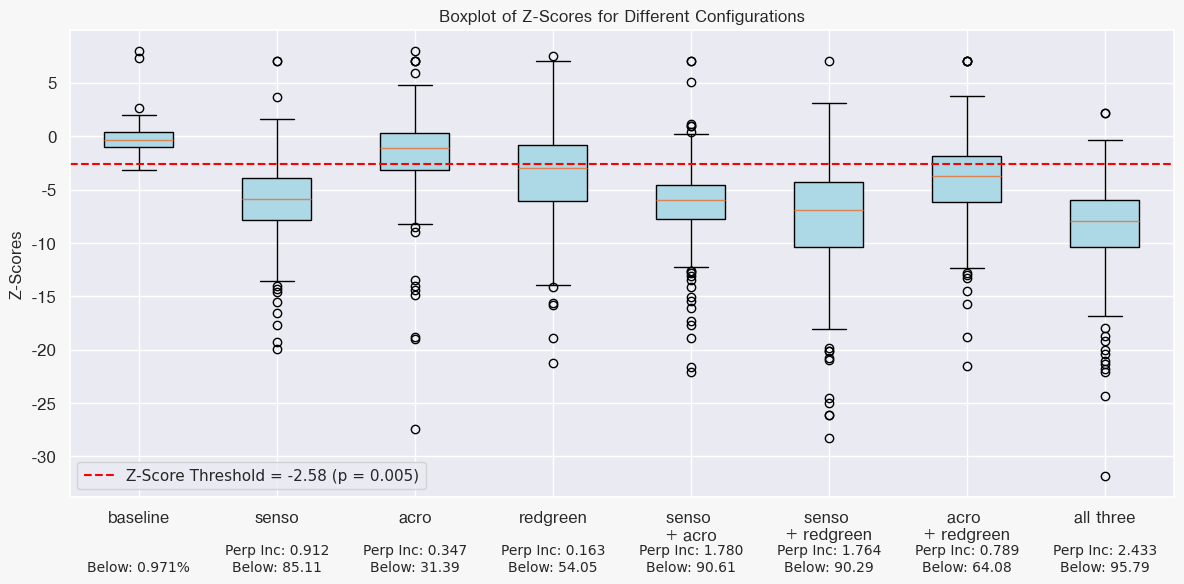

Updated Median Perplexity Increment and Percentage of Z-Scores Below Threshold for Each Configuration with 95% Confidence Intervals:
baseline:
  Median Perplexity Increment = 11.2646
  95% CI: (10.6090, 12.2471)
  Below Z-Score Threshold = 0.9709%
  95% CI: (0.0000%, 2.2654%)

senso:
  Median Perplexity Increment = 0.9122
  95% CI: (0.4472, 1.1795)
  Below Z-Score Threshold = 85.1133%
  95% CI: (80.9061%, 88.9968%)

acro:
  Median Perplexity Increment = 0.3466
  95% CI: (0.0946, 0.5378)
  Below Z-Score Threshold = 31.3916%
  95% CI: (26.2136%, 36.5696%)

redgreen:
  Median Perplexity Increment = 0.1627
  95% CI: (-0.0346, 0.5588)
  Below Z-Score Threshold = 54.0453%
  95% CI: (48.5437%, 59.5469%)

senso 
+ acro:
  Median Perplexity Increment = 1.7795
  95% CI: (1.3142, 2.3348)
  Below Z-Score Threshold = 90.6149%
  95% CI: (87.0550%, 93.8511%)

senso 
+ redgreen:
  Median Perplexity Increment = 1.7637
  95% CI: (1.3471, 2.4399)
  Below Z-Score Threshold = 90.2913%
  95% CI: (87.0550%, 

In [41]:
import json
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
import math
import plotly.express as px
import pandas as pd

# --------------------- Data Loading and Extraction --------------------- #

# Load the JSON data
with open('attacked_results_llama3b.json', 'r') as f:
    data = json.load(f)

# Extract all configurations
all_configurations = list(data[0]['detection'].keys())

# Check if 'llm_baseline' exists
if 'llm_baseline' not in all_configurations:
    raise ValueError("Configuration 'llm_baseline' not found in the data.")

# Separate 'llm_baseline' from other configurations
configurations = [config for config in all_configurations if config != 'llm_baseline']

# Initialize dictionaries to store data
final_scores = {config: [] for config in configurations}
perplexity_increments = {config: [] for config in configurations}

# Collect all baseline perplexities to compute the median baseline
baseline_perplexities = []

for entry in data:
    detection = entry['detection']
    
    # Extract baseline perplexity
    try:
        baseline_perplexity = detection['llm_baseline']['perplexity']
        if not np.isnan(baseline_perplexity):
            baseline_perplexities.append(baseline_perplexity)
    except KeyError:
        print(f"Missing 'llm_baseline' perplexity in entry: {entry}")
        continue
    
    # Extract data for other configurations
    for config in configurations:
        try:
            final_score = detection[config]['final_score']
            perplexity = detection[config]['perplexity']
            
            # Only proceed if perplexity is not NaN
            if not np.isnan(perplexity):
                # Compute perplexity increment
                perplexity_increment = perplexity - baseline_perplexity
                perplexity_increments[config].append(perplexity_increment)
                
                # Append final_score
                final_scores[config].append(final_score)
        except KeyError as e:
            print(f"Missing key {e} in configuration '{config}' for entry: {entry}")
            continue

# Compute the median baseline perplexity
if not baseline_perplexities:
    raise ValueError("No valid 'llm_baseline' perplexity values found.")

median_baseline_perplexity = np.median(baseline_perplexities)

print(f"Median 'llm_baseline' Perplexity: {median_baseline_perplexity:.4f}")

# --------------------- Data Cleaning: Remove Outliers --------------------- #

def remove_outliers(scores, perps):
    """
    Removes outliers based on the Interquartile Range (IQR) method.
    Applies the same mask to both scores and perplexities to maintain alignment.
    """
    if len(scores) < 4:
        return scores, perps
    q1, q3 = np.percentile(scores, [0, 100])
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    mask = [(x >= lower_bound) and (x <= upper_bound) for x in scores]
    filtered_scores = [x for x, m in zip(scores, mask) if m]
    filtered_perps = [x for x, m in zip(perps, mask) if m]
    return filtered_scores, filtered_perps

# Apply outlier removal
cleaned_final_scores = {}
cleaned_perplexity_increments = {}
for config in configurations:
    scores, perps = remove_outliers(final_scores[config], perplexity_increments[config])
    cleaned_final_scores[config] = scores
    cleaned_perplexity_increments[config] = perps


# --------------------- Data Transformation: Convert to Z-Scores --------------------- #

def prob_to_z_score(prob):
    """
    Converts a probability to a z-score using the inverse CDF of the normal distribution.
    Handles edge cases where probability is 0 or 1.
    """
    if prob <= 0:
        prob = 1e-12  # A very small value close to 0
    elif prob >= 1:
        prob = 1 - 1e-12  # A very small value close to 1
    return norm.ppf(prob)

# Convert final_scores to z-scores
z_scores = {config: [prob_to_z_score(score) for score in cleaned_final_scores[config]] for config in configurations}

# --------------------- Statistical Calculations --------------------- #

# Calculate median perplexity increment for each configuration
median_perplexity_increment = {config: np.median(cleaned_perplexity_increments[config]) for config in configurations}

# Z-score corresponding to a probability of 0.005
z_score_threshold = norm.ppf(0.005)  # Approximately -2.5758

# Calculate percentage of z-scores below the threshold for each configuration
below_threshold_percentage = {
    config: (sum(z < z_score_threshold for z in z_scores[config]) / len(z_scores[config])) * 100
    for config in configurations
}

# --------------------- Statistical Calculations with Confidence Intervals --------------------- #

import numpy as np

def bootstrap_confidence_interval(data, stat_func=np.median, n_bootstrap=10000, ci=95):
    """
    Compute the bootstrap confidence interval for a statistic.
    """
    bootstrapped_stats = []
    n = len(data)
    for i in range(n_bootstrap):
        resample = np.random.choice(data, size=n, replace=True)
        stat = stat_func(resample)
        bootstrapped_stats.append(stat)
    lower_percentile = (100 - ci) / 2
    upper_percentile = 100 - lower_percentile
    lower_bound = np.percentile(bootstrapped_stats, lower_percentile)
    upper_bound = np.percentile(bootstrapped_stats, upper_percentile)
    return lower_bound, upper_bound

def bootstrap_percentage_confidence_interval(data, threshold, n_bootstrap=10000, ci=95):
    """
    Compute the bootstrap confidence interval for the percentage of data below threshold.
    """
    bootstrapped_percentages = []
    n = len(data)
    for i in range(n_bootstrap):
        resample = np.random.choice(data, size=n, replace=True)
        percentage = (np.sum(resample < threshold) / n) * 100
        bootstrapped_percentages.append(percentage)
    lower_percentile = (100 - ci) / 2
    upper_percentile = 100 - lower_percentile
    lower_bound = np.percentile(bootstrapped_percentages, lower_percentile)
    upper_bound = np.percentile(bootstrapped_percentages, upper_percentile)
    return lower_bound, upper_bound

# Compute confidence intervals
median_perplexity_increment_ci = {}
below_threshold_percentage_ci = {}

for config in configurations:
    # For median perplexity increment
    data = cleaned_perplexity_increments[config]
    if len(data) > 1:  # Need at least two data points to bootstrap
        lower_bound, upper_bound = bootstrap_confidence_interval(data, stat_func=np.median, n_bootstrap=10000, ci=95)
        median_perplexity_increment_ci[config] = (lower_bound, upper_bound)
    else:
        median_perplexity_increment_ci[config] = (np.nan, np.nan)
    
    # For percentage below threshold
    data_z = z_scores[config]
    if len(data_z) > 1:
        lower_bound_p, upper_bound_p = bootstrap_percentage_confidence_interval(data_z, z_score_threshold, n_bootstrap=10000, ci=95)
        below_threshold_percentage_ci[config] = (lower_bound_p, upper_bound_p)
    else:
        below_threshold_percentage_ci[config] = (np.nan, np.nan)

# --------------------- Visualization Functions --------------------- #

import matplotlib.font_manager as fm

# Path to the Helvetica font file you added
font_path = '/home/feline/Helvetica.ttf'

# Create a font property object
helvetica_font = fm.FontProperties(fname=font_path)

# Add the font file to the list of fonts
fm.fontManager.addfont(font_path)
# Rebuild the font cache
fm._load_fontmanager(try_read_cache=False)

import seaborn as sns

# Apply Seaborn theme and matplotlib settings
sns.set_theme()
# Apply the font properties to different elements in the plot
def apply_font_properties(ax, font_properties):
    # Set the font for the title, labels, and tick labels
    ax.set_title(ax.get_title(), fontproperties=font_properties)
    ax.set_xlabel(ax.get_xlabel(), fontproperties=font_properties)
    ax.set_ylabel(ax.get_ylabel(), fontproperties=font_properties)
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontproperties(font_properties)


# Boxplots for z-scores
def plot_boxplots_z(z_scores, configurations, median_perplexity_increment, below_threshold_percentage, z_score_threshold, median_perplexity_increment_ci, below_threshold_percentage_ci):
    fig, ax = plt.subplots(figsize=(12, 6))
    box = ax.boxplot([z_scores[config] for config in configurations], labels=configurations, patch_artist=True)
    
    # Customize box colors
    for patch in box['boxes']:
        patch.set_facecolor('#ADD8E6')  # Light blue
    
    ax.set_xticklabels(configurations, rotation=0)
    ax.set_ylabel('Z-Scores')
    ax.set_title('Boxplot of Z-Scores for Different Configurations')
    
    # Draw a horizontal line at the z-score threshold
    ax.axhline(y=z_score_threshold, color='red', linestyle='--', label=f'Z-Score Threshold = {z_score_threshold:.2f} (p = 0.005)')
    
    # Annotate each boxplot
    for i, config in enumerate(configurations, start=1):
        med_perp = median_perplexity_increment[config]
        percentage_below = below_threshold_percentage[config]
        #med_perp_ci = median_perplexity_increment_ci[config]
        #perc_below_ci = below_threshold_percentage_ci[config]
        annotate_plot(ax, config, i, med_perp, percentage_below)#, med_perp_ci, perc_below_ci)
    
    ax.legend()
    apply_font_properties(ax, helvetica_font)
    fig.patch.set_facecolor('#f7f7f7')
    plt.tight_layout()
    plt.show()

# Function to annotate plots
def annotate_plot(ax, config, i, median_perp, percentage_below):#, median_perp_ci, percentage_below_ci):
    """
    Adds annotations below each boxplot or violin plot, except for the baseline configuration.
    """
    # Skip annotation for the baseline
    if config == "baseline":
        ylim = ax.get_ylim()
        x_position = i
        y_position = ylim[0] - (ylim[1] - ylim[0]) * 0.1  # 10% below the minimum y
        ax.text(
            x_position, y_position,
            f'\nBelow: {percentage_below:.3f}%',
            ha='center', va='top', fontsize=10
        )
        return
    
    ylim = ax.get_ylim()
    x_position = i
    y_position = ylim[0] - (ylim[1] - ylim[0]) * 0.1  # 10% below the minimum y

    # Add confidence intervals to the annotations
    #perp_ci_str = f"({median_perp_ci[0]:.3f}, {median_perp_ci[1]:.3f})"
    #perc_below_ci_str = f"({percentage_below_ci[0]:.2f}%, {percentage_below_ci[1]:.2f}%)"

    ax.text(
        x_position, y_position,
        #f'Perp Inc: {median_perp:.3f}\n95% CI: {perp_ci_str}\nBelow: {percentage_below:.2f}%\n95% CI: {perc_below_ci_str}',
        f'Perp Inc: {median_perp:.3f}\nBelow: {percentage_below:.2f}',
        ha='center', va='top', fontsize=10
    )

# --------------------- Update Configuration Names --------------------- #

# Mapping for renaming configurations
config_name_mapping = {
    "llm_senso_medium": "senso",
    "llm_acro_medium": "acro",
    "llm_both_medium": "senso \n+ acro",
    "llm_redgreen_medium": "redgreen",
    "llm_senso_redgreen_medium" : "senso \n+ redgreen",
    "llm_acro_redgreen_medium": "acro \n+ redgreen",
    "llm_all_three_medium": "all three"
    # Add more mappings here as needed
    # "llm_config_old_name": "new_name"
}

# Update the configuration names using the mapping
updated_configurations = [config_name_mapping.get(config, config) for config in configurations]

# Update all dictionaries with the new configuration names
cleaned_final_scores = {config_name_mapping.get(config, config): scores for config, scores in cleaned_final_scores.items()}
cleaned_perplexity_increments = {config_name_mapping.get(config, config): perps for config, perps in cleaned_perplexity_increments.items()}
z_scores = {config_name_mapping.get(config, config): zs for config, zs in z_scores.items()}
median_perplexity_increment = {config_name_mapping.get(config, config): median for config, median in median_perplexity_increment.items()}
below_threshold_percentage = {config_name_mapping.get(config, config): percentage for config, percentage in below_threshold_percentage.items()}
median_perplexity_increment_ci = {config_name_mapping.get(config, config): ci for config, ci in median_perplexity_increment_ci.items()}
below_threshold_percentage_ci = {config_name_mapping.get(config, config): ci for config, ci in below_threshold_percentage_ci.items()}

# --------------------- Execute Plotting --------------------- #

# Plot Boxplots of Z-Scores
plot_boxplots_z(
    z_scores, 
    updated_configurations, 
    median_perplexity_increment, 
    below_threshold_percentage, 
    z_score_threshold,
    median_perplexity_increment_ci,
    below_threshold_percentage_ci
)

# --------------------- Display Median Perplexity Increment and Percentage Below Threshold --------------------- #

print("Updated Median Perplexity Increment and Percentage of Z-Scores Below Threshold for Each Configuration with 95% Confidence Intervals:")
for config in updated_configurations:
    med_perp = median_perplexity_increment[config]
    med_perp_ci = median_perplexity_increment_ci[config]
    perc_below = below_threshold_percentage[config]
    perc_below_ci = below_threshold_percentage_ci[config]
    print(f"{config}:")
    print(f"  Median Perplexity Increment = {med_perp:.4f}")
    print(f"  95% CI: ({med_perp_ci[0]:.4f}, {med_perp_ci[1]:.4f})")
    print(f"  Below Z-Score Threshold = {perc_below:.4f}%")
    print(f"  95% CI: ({perc_below_ci[0]:.4f}%, {perc_below_ci[1]:.4f}%)\n")

total_prompts = len(data)
print(f"Total number of prompts in the JSON data: {total_prompts}")



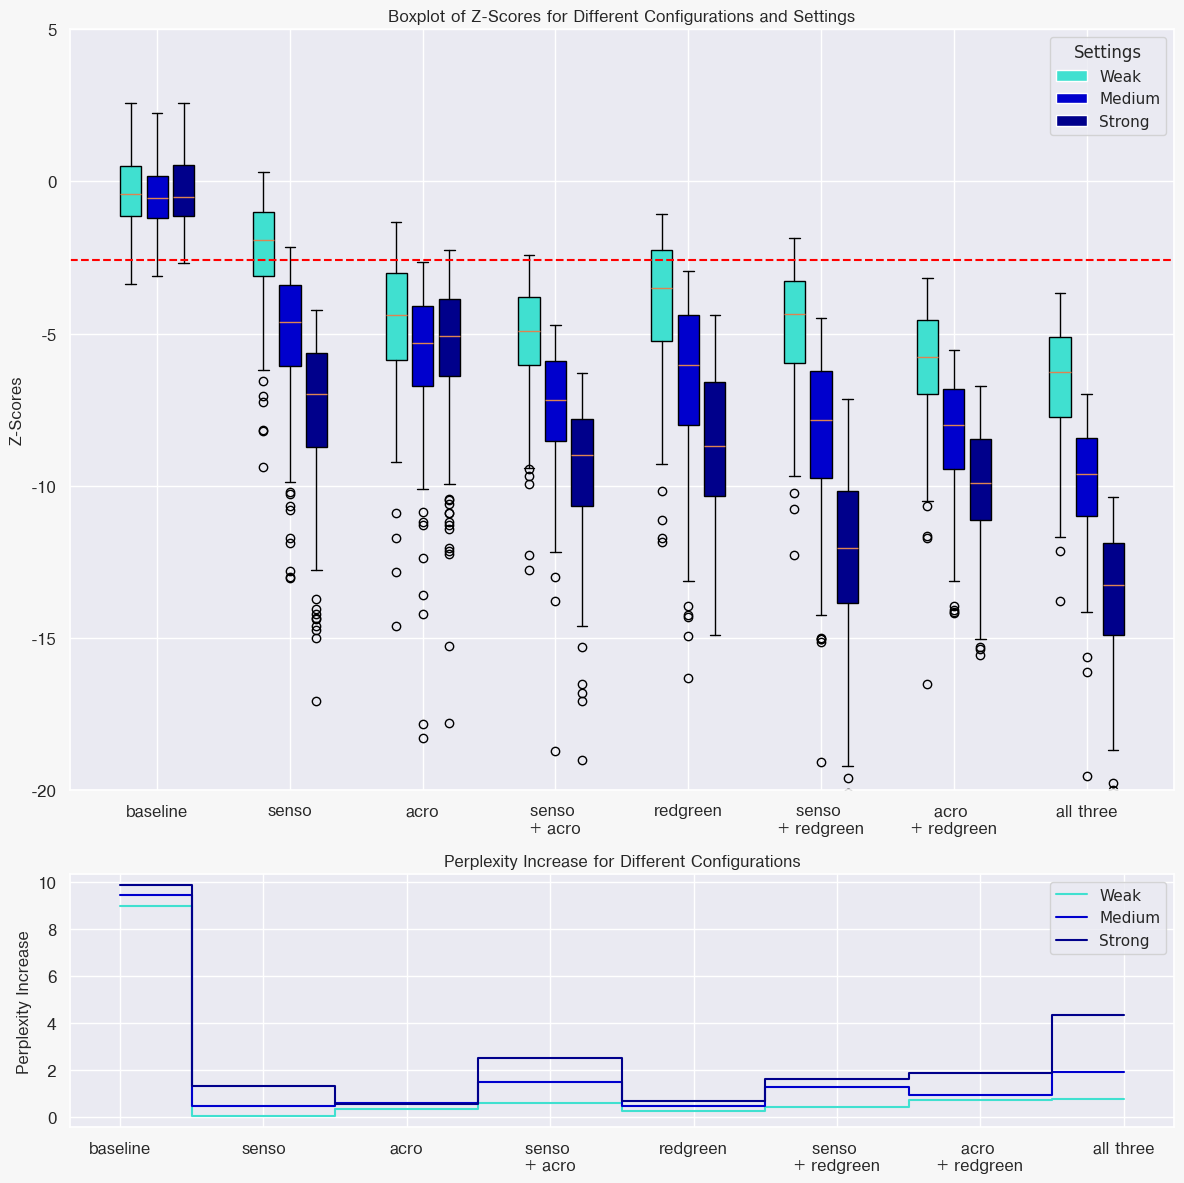

In [71]:
import json
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
import math
import plotly.express as px
import pandas as pd
import seaborn as sns
import matplotlib.font_manager as fm

# --------------------- Configuration --------------------- #

# Define the settings and their corresponding JSON files
settings = {
    "Weak": "detection_results_soft.json",
    "Medium": "detection_results_medium.json",
    "Strong": "detection_results_hard.json"
    # Add more settings and their JSON files here if needed
}

configuration_order = [
    "baseline", 
    "llm_senso_medium", 
    "llm_acro_medium", 
    "llm_both_medium", 
    "llm_redgreen_medium", 
    "llm_senso_redgreen_medium", 
    "llm_acro_redgreen_medium", 
    "llm_all_three_medium"
]
# Path to the Helvetica font file you added
font_path = '/home/feline/Helvetica.ttf'

# Mapping for renaming configurations
config_name_mapping = {
    "llm_senso_medium": "senso",
    "llm_acro_medium": "acro",
    "llm_both_medium": "senso \n+ acro",
    "llm_redgreen_medium": "redgreen",
    "llm_senso_redgreen_medium": "senso \n+ redgreen",
    "llm_acro_redgreen_medium": "acro \n+ redgreen",
    "llm_all_three_medium": "all three"
}
# Exclude baseline from perplexity plot
configurations_no_baseline = [config for config in config_name_mapping.keys() if config != 'llm_baseline']

# --------------------- Font Setup --------------------- #

# Create a font property object
helvetica_font = fm.FontProperties(fname=font_path)

# Add the font file to the list of fonts
fm.fontManager.addfont(font_path)
# Rebuild the font cache
fm._load_fontmanager(try_read_cache=False)

# --------------------- Visualization Functions --------------------- #

# Apply Seaborn theme and matplotlib settings
sns.set_theme()

# Apply the font properties to different elements in the plot
def apply_font_properties(ax, font_properties):
    # Set the font for the title, labels, and tick labels
    ax.set_title(ax.get_title(), fontproperties=font_properties)
    ax.set_xlabel(ax.get_xlabel(), fontproperties=font_properties)
    ax.set_ylabel(ax.get_ylabel(), fontproperties=font_properties)
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontproperties(font_properties)

# Function to annotate plots
def annotate_plot(ax, config, setting, x_position, median_perp, percentage_below, ci_perp, ci_perc):
    """
    Adds annotations below each boxplot.
    """
    # Determine annotation position
    ylim = ax.get_ylim()
    y_position = ylim[0] - (ylim[1] - ylim[0]) * 0.1  # 10% below the minimum y
    
    # Format confidence intervals if available
    if not np.isnan(ci_perp[0]) and not np.isnan(ci_perp[1]):
        perp_ci_str = f"({ci_perp[0]:.3f}, {ci_perp[1]:.3f})"
    else:
        perp_ci_str = "(N/A)"
    
    if not np.isnan(ci_perc[0]) and not np.isnan(ci_perc[1]):
        perc_below_ci_str = f"({ci_perc[0]:.2f}%, {ci_perc[1]:.2f}%)"
    else:
        perc_below_ci_str = "(N/A)"
    
    # Add text annotation (including annotations for baseline, senso, acro, etc.)
    #ax.text(
    #    x_position, y_position,
    #    f'{setting}\nPerp Inc: {median_perp:.3f} {perp_ci_str}\nBelow: {percentage_below:.2f}% {perc_below_ci_str}',
    #    ha='center', va='top', fontsize=8
    #)

# Boxplots for z-scores with multiple settings
# Boxplots for z-scores with multiple settings
# Boxplots for z-scores with multiple settings
def plot_boxplots_z(z_scores, settings_dict, configurations, z_score_threshold, median_perplexity_increment, below_threshold_percentage, median_perplexity_increment_ci, below_threshold_percentage_ci):
    fig, (ax_boxplot, ax_line) = plt.subplots(2, 1, figsize=(12, 12), gridspec_kw={'height_ratios': [3, 1]})

    # Number of configurations and settings
    num_configs = len(configurations)
    num_settings = len(settings_dict)
    
    # Width of each box
    box_width = 0.2
    # Spacing between groups
    spacing = 1
    
    # Calculate positions for each box
    positions = []
    for i in range(num_configs):
        center = i * spacing
        for j in range(num_settings):
            pos = center - (box_width * (num_settings - 1) / 2) + j * box_width
            positions.append(pos)
    
    # Prepare data and labels
    data_to_plot = []
    labels = []
    for config in configurations:
        for setting in settings_dict.keys():
            data = z_scores[setting].get(config, [])
            data_to_plot.append(data)
            labels.append(config_name_mapping.get(config, config))
    
    # Plot boxplots
    box = ax_boxplot.boxplot(data_to_plot, positions=positions, widths=box_width*0.8, patch_artist=True, manage_ticks=False)
    
    # Define custom colors for different settings in the order Weak, Medium, Strong
    color_mapping = {
        "Weak": "turquoise",
        "Medium": "mediumblue",
        "Strong": "darkblue"
    }
    
    # Customize box colors based on settings
    for i, patch in enumerate(box['boxes']):
        setting = list(settings_dict.keys())[i % num_settings]
        patch.set_facecolor(color_mapping[setting])
    
    # Create custom legends
    from matplotlib.patches import Patch
    legend_patches = [Patch(facecolor=color_mapping[setting], label=setting) for setting in settings_dict]
    ax_boxplot.legend(handles=legend_patches, title='Settings')
    
    # Set x-ticks to be at the center of each group
    ax_boxplot.set_xticks([i * spacing for i in range(num_configs)])
    ax_boxplot.set_xticklabels([config_name_mapping.get(config, config) for config in configurations], rotation=0)
    
    ax_boxplot.set_ylabel('Z-Scores')
    ax_boxplot.set_title('Boxplot of Z-Scores for Different Configurations and Settings')
    
    # Set custom limits for the Z-scores y-axis
    ax_boxplot.set_ylim(-20, 5)

    # Draw a horizontal line at the z-score threshold
    ax_boxplot.axhline(y=z_score_threshold, color='red', linestyle='--', label=f'Z-Score Threshold = {z_score_threshold:.2f} (p = 0.005)')
    
    # Second plot: line plot of perplexity increase
    for setting in settings_dict.keys():
        perplexity_increments = [median_perplexity_increment[setting].get(config, 0 if config == 'baseline' else np.nan) for config in configurations]
        ax_line.step(np.arange(len(configurations)), perplexity_increments, where='mid', label=setting, color=color_mapping[setting])  # Removed marker='o'
    
    ax_line.set_xticks(np.arange(len(configurations)))
    ax_line.set_xticklabels([config_name_mapping.get(config, config) for config in configurations])
    ax_line.set_ylabel('Perplexity Increase')
    ax_line.set_title('Perplexity Increase for Different Configurations')
    ax_line.legend()
    
    # Apply font properties to both plots
    apply_font_properties(ax_boxplot, helvetica_font)
    apply_font_properties(ax_line, helvetica_font)

    fig.patch.set_facecolor('#f7f7f7')
    plt.tight_layout()
    plt.show()


# --------------------- Execute Plotting --------------------- #

# Plot Boxplots of Z-Scores with multiple settings and line plot for perplexity increase
plot_boxplots_z(
    z_scores, 
    settings, 
    configuration_order,  # Pass the custom configuration order
    z_score_threshold,
    median_perplexity_increment,
    below_threshold_percentage,
    median_perplexity_increment_ci,
    below_threshold_percentage_ci
)

/tmp/ipykernel_2148543/1288977623.py:125: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  agg_df = df.groupby(['LLM', 'Configuration', 'Num_Sentences']).apply(count_detections).reset_index()


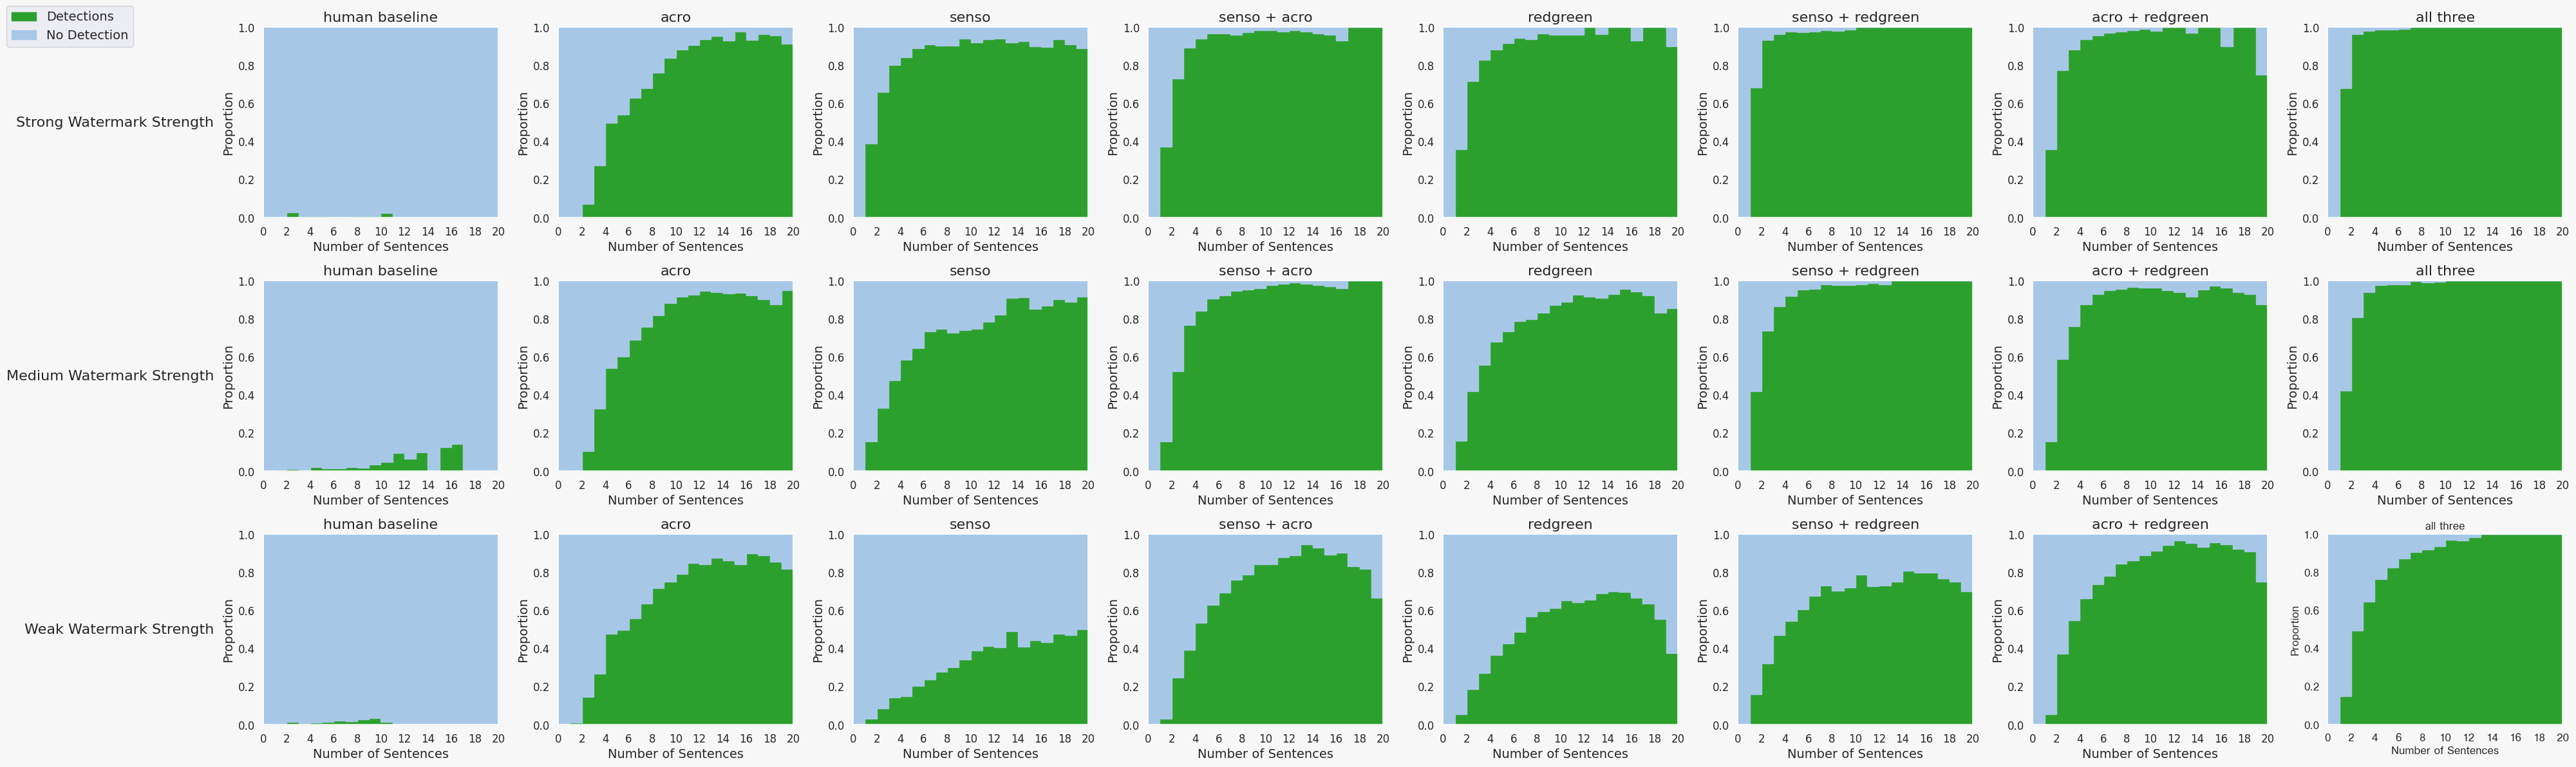

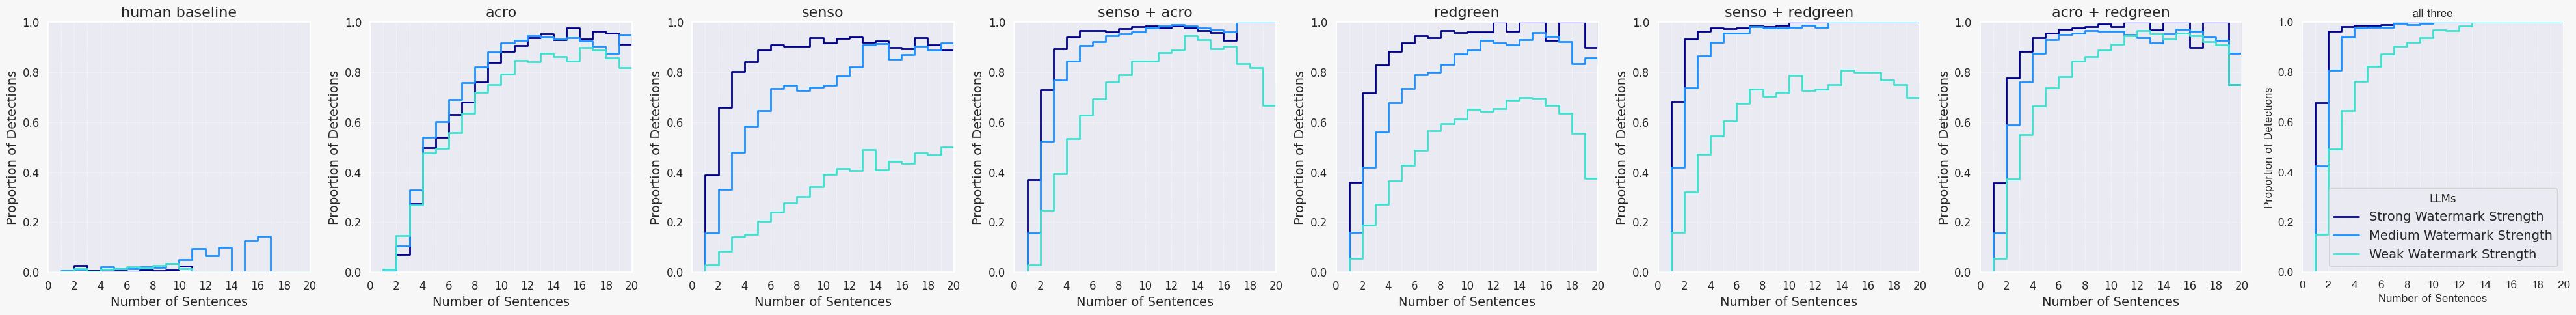

Number of samples per LLM:
LLM: Medium Watermark Strength, Samples: 909
LLM: Strong Watermark Strength, Samples: 909
LLM: Weak Watermark Strength, Samples: 909


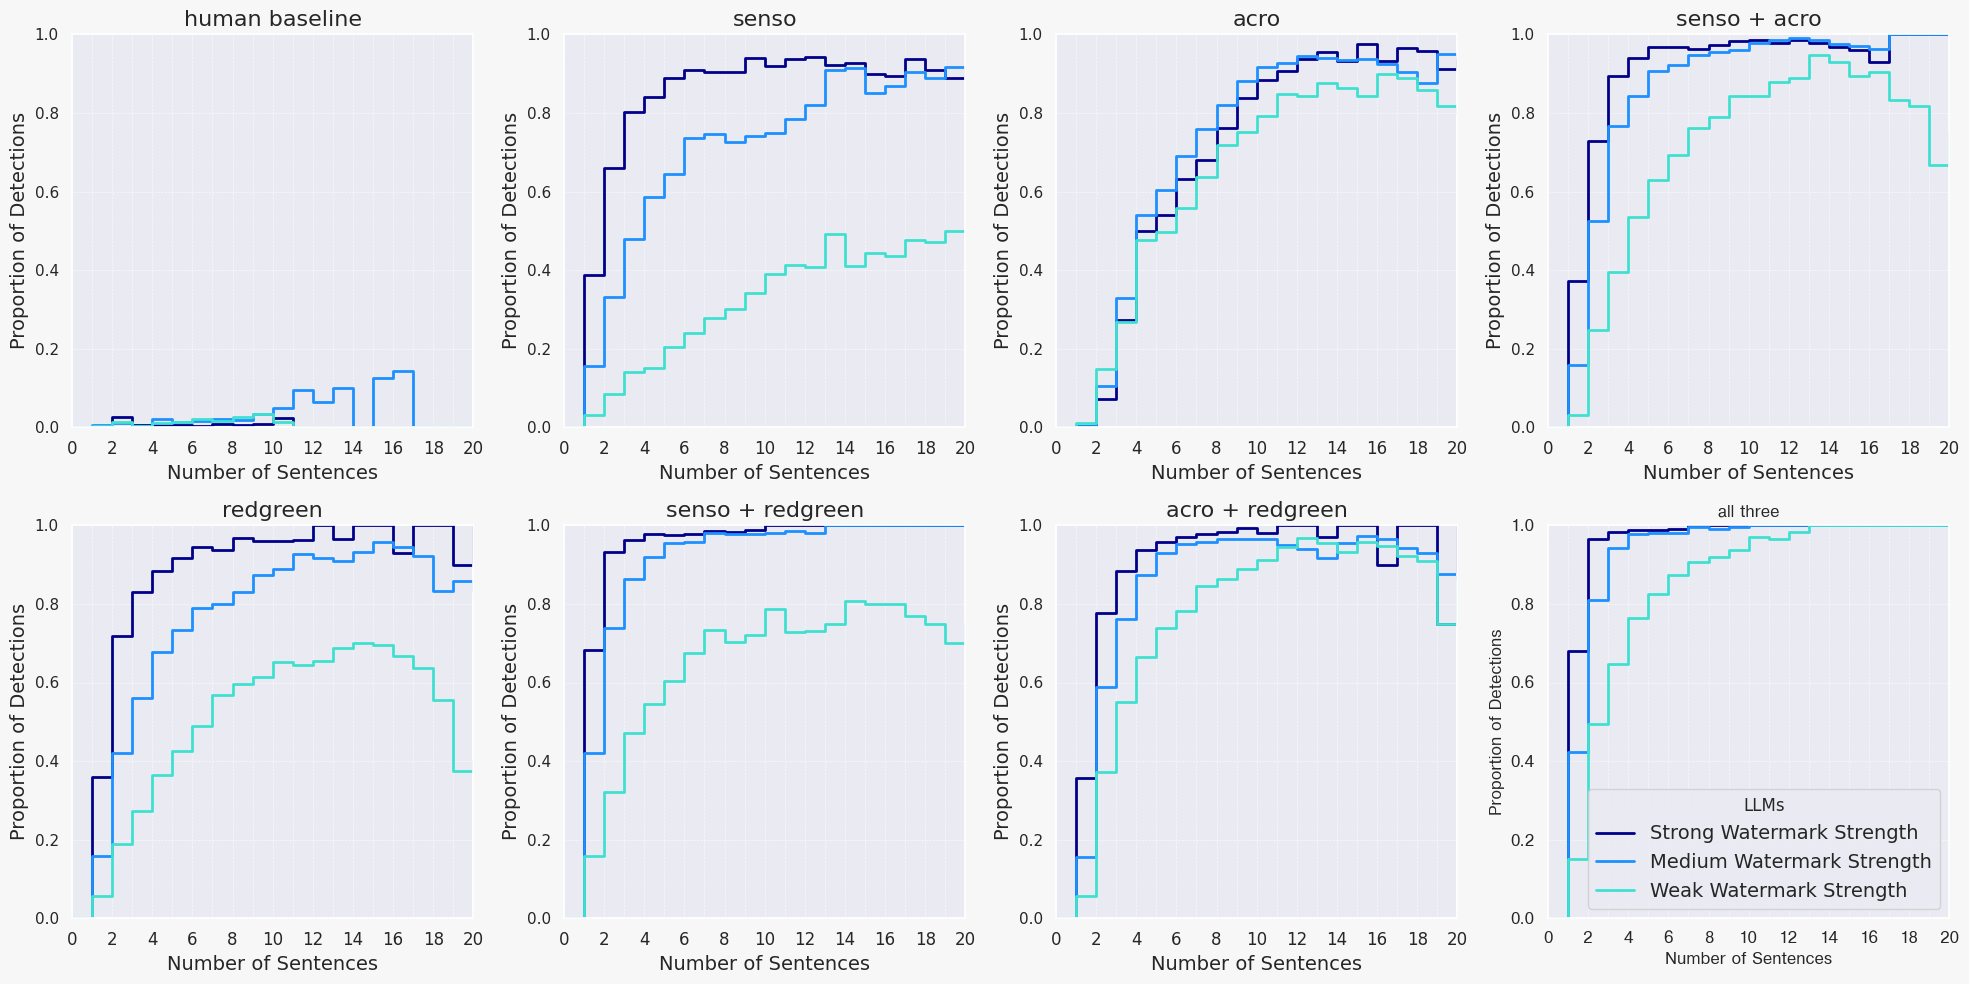

In [40]:
import json
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns

import matplotlib.font_manager as fm

import os
os.chdir("/home/feline/master-generation")


# Apply the font properties to different elements in the plot
def apply_font_properties(ax, font_properties):
    # Set the font for the title, labels, and tick labels
    ax.set_title(ax.get_title(), fontproperties=font_properties)
    ax.set_xlabel(ax.get_xlabel(), fontproperties=font_properties)
    ax.set_ylabel(ax.get_ylabel(), fontproperties=font_properties)
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontproperties(font_properties)


def load_data(json_files):
    """
    Load data from a list of JSON files.

    Parameters:
        json_files (list): List of paths to JSON files.

    Returns:
        pd.DataFrame: DataFrame containing all the extracted data.
    """
    data_records = []
    
    for file in json_files:
        # Extract LLM name from filename (assuming filename is the LLM name)
        llm_name = os.path.splitext(os.path.basename(file))[0]
        
        with open(file, 'r') as f:
            try:
                json_data = json.load(f)
            except json.JSONDecodeError as e:
                print(f"Error decoding JSON from file {file}: {e}")
                continue
            
            for entry in json_data:
                prompt = entry.get("prompt", "")
                outputs = entry.get("outputs", {})
                detection = entry.get("detection", {})
                
                # Loop through each variant (or output) in detection
                for config, det in detection.items():
                    final_score = det.get("final_score", None)
                    num_sentences = det.get("num_sentences", None)
                    
                    if final_score is None or num_sentences is None:
                        continue  # Skip entries with missing data

                    # Strip variation suffix (e.g., "_variation_1") to group under the same configuration
                    base_config = config.split("_variation")[0]
                    
                    data_records.append({
                        "LLM": llm_name,
                        "Configuration": base_config,  # Use base configuration name
                        "Final_Score": final_score,
                        "Num_Sentences": num_sentences
                    })
                    
    df = pd.DataFrame(data_records)
    return df

def compute_detections(df, p=0.005):
    """
    Compute z-scores and determine detections based on threshold.
    For 'baseline', detection is successful if z_score > z_threshold.
    For others, detection is successful if z_score < z_threshold.

    Parameters:
        df (pd.DataFrame): DataFrame containing 'Final_Score' and 'Configuration'.
        p (float): Probability threshold for detection.

    Returns:
        pd.DataFrame: DataFrame with an additional 'Detection' column.
    """
    # Calculate z_threshold using the probability p (one-tailed)
    z_threshold = norm.ppf(p)
    
    # Compute z-scores using norm.ppf(final_score)
    # Handle final_score values that are exactly 0 or 1 to avoid -inf or inf
    df = df.copy()
    df['Final_Score_Clipped'] = df['Final_Score'].clip(lower=1e-10, upper=1 - 1e-10)
    df['Z_Score'] = norm.ppf(df['Final_Score_Clipped'])
    
    # Determine detections
    # For 'baseline', Detection is True if Z_Score > z_threshold
    # For others, Detection is True if Z_Score < z_threshold
    df['Detection'] = (
        ((df['Configuration'] == 'baseline') & (df['Z_Score'] < z_threshold)) |
        ((df['Configuration'] != 'baseline') & (df['Z_Score'] < z_threshold))
    )
    
    return df

def aggregate_data(df):
    """
    Aggregate data to count detections and failures.

    Parameters:
        df (pd.DataFrame): DataFrame with 'LLM', 'Configuration', 'Num_Sentences', 'Detection'.

    Returns:
        pd.DataFrame: Aggregated DataFrame with counts.
    """
    # Define a function to count detections and failures
    def count_detections(group):
        detections = group['Detection'].sum()
        failures = (~group['Detection']).sum()
        return pd.Series({
            'Detections': detections,
            'Failures': failures
        })
    
    agg_df = df.groupby(['LLM', 'Configuration', 'Num_Sentences']).apply(count_detections).reset_index()
    return agg_df

def prepare_plot_data(agg_df):
    """
    Prepare data for plotting by ensuring all Num_Sentences are present for each LLM and Configuration.

    Parameters:
        agg_df (pd.DataFrame): Aggregated DataFrame with 'LLM', 'Configuration', 'Num_Sentences', 'Detections', 'Failures'.

    Returns:
        pd.DataFrame: Prepared DataFrame with proportions.
        np.array: Sorted array of all number of sentences.
    """
    # Get all unique number of sentences
    all_num_sentences = agg_df['Num_Sentences'].unique()
    all_num_sentences = np.sort(all_num_sentences)
    
    # Get all unique LLMs and Configurations
    llms = agg_df['LLM'].unique()
    configurations = agg_df['Configuration'].unique()
    
    # Create a MultiIndex of all possible combinations
    index = pd.MultiIndex.from_product(
        [llms, configurations, all_num_sentences],
        names=['LLM', 'Configuration', 'Num_Sentences']
    )
    
    # Reindex the aggregated DataFrame to include all combinations
    agg_df_full = agg_df.set_index(['LLM', 'Configuration', 'Num_Sentences']).reindex(index, fill_value=0).reset_index()
    
    # Wherever there was no data (Detections=0 and Failures=0), set Detections=1 and Failures=0 (full success)
    mask_no_data = (agg_df_full['Detections'] == 0) & (agg_df_full['Failures'] == 0)
    agg_df_full.loc[mask_no_data, 'Detections'] = 0
    agg_df_full.loc[mask_no_data, 'Failures'] = 1
    
    # Calculate total and proportions
    agg_df_full['Total'] = agg_df_full['Detections'] + agg_df_full['Failures']
    agg_df_full['Proportion_Detections'] = agg_df_full['Detections'] / agg_df_full['Total']
    agg_df_full['Proportion_Failures'] = agg_df_full['Failures'] / agg_df_full['Total']
    
    return agg_df_full, all_num_sentences

def plot_data(agg_df_full, all_num_sentences, llm_name_mapping=None):
    """
    Plot the aggregated data as a grid of stacked bar-like area charts with rectangular areas, ordered by custom configuration names.

    Parameters:
        agg_df_full (pd.DataFrame): Prepared DataFrame with 'LLM', 'Configuration', 'Num_Sentences', 'Proportion_Detections', 'Proportion_Failures'.
        all_num_sentences (np.array): Sorted array of all number of sentences.
        llm_name_mapping (dict): A dictionary to rename the LLMs for display (e.g., {"llm_acro_medium": "acro"}).
    """
    
    # Mapping for renaming configurations
    config_name_mapping = {
        "baseline": "human baseline",
        "llm_senso_medium": "senso",
        "llm_acro_medium": "acro",
        "llm_both_medium": "senso + acro",
        "llm_redgreen_medium": "redgreen",
        "llm_senso_redgreen_medium" : "senso + redgreen",
        "llm_acro_redgreen_medium": "acro + redgreen",
        "llm_all_three_medium": "all three"
    }
    
    # Desired order for configurations (baseline first, then mapped configurations)
    desired_order = [
        "human baseline", 
        "acro", 
        "senso", 
        "senso + acro", 
        "redgreen", 
        "senso + redgreen", 
        "acro + redgreen", 
        "all three"
    ]
    custom_llm_names = {
        "reduce_sentences_detection_results_medium": "Medium Watermark Strength",
        "reduce_sentences_detection_results_hard": "Strong Watermark Strength",
        "reduce_sentences_detection_results_soft": "Weak Watermark Strength"
    }
    
    # Optional renaming of LLMs using the provided llm_name_mapping dictionary
    if custom_llm_names:
        agg_df_full['LLM'] = agg_df_full['LLM'].replace(custom_llm_names)
    
    
    # Apply configuration name mapping
    agg_df_full['Configuration'] = agg_df_full['Configuration'].replace(config_name_mapping)
    
    # Reorder configurations according to the desired order
    agg_df_full['Configuration'] = pd.Categorical(agg_df_full['Configuration'], categories=desired_order, ordered=True)
    
    # Get unique LLMs and configurations after renaming and reordering
    llms = agg_df_full['LLM'].unique()
    configurations = desired_order  # Now use the desired custom order for plotting
    
    num_llms = len(llms)
    num_configs = len(configurations)
    
    # Define figure size dynamically
    fig_width = 5 * num_configs
    fig_height = 4 * num_llms
    fig, axes = plt.subplots(nrows=num_llms, ncols=num_configs, figsize=(fig_width, fig_height))

    
    # Define a color palette
    colors = ['#2ca02c', '#A7C7E7']  # Green and Orange for Detections and Failures
    
    # Increase font sizes for better visibility
    label_fontsize = 14
    title_fontsize = 16
    tick_fontsize = 12

    
    for i, llm in enumerate(llms):
        for j, config in enumerate(configurations):
            ax = axes[i, j]
            subset = agg_df_full[(agg_df_full['LLM'] == llm) & (agg_df_full['Configuration'] == config)]
            
            # Filter to limit the x-axis to 20 sentences
            subset = subset[subset['Num_Sentences'] <= 20]
            
            if subset.empty:
                ax.set_visible(False)
                continue
            
            # Sort by Num_Sentences
            subset = subset.sort_values('Num_Sentences')
            
            x = subset['Num_Sentences']
            detections = subset['Proportion_Detections']
            failures = subset['Proportion_Failures']
            
            # Create bar-like stacked areas using fill_between for rectangular shapes
            ax.fill_between(x, 0, detections, step='post', color=colors[0], label='Detections')
            ax.fill_between(x, detections, 1, step='post', color=colors[1], label='No Detection')
            
            # Set larger font sizes
            ax.set_xlabel('Number of Sentences', fontsize=label_fontsize)
            ax.set_ylabel('Proportion', fontsize=label_fontsize)
            ax.set_xlim(0, 20)  # Limit x-axis to 20 sentences
            ax.set_ylim(0, 1)
            
            # Set larger tick sizes
            ax.tick_params(axis='x', labelsize=tick_fontsize)
            ax.tick_params(axis='y', labelsize=tick_fontsize)
            
            # Adjust x-axis ticks to avoid crowding
            if len(x) > 10:  # Show every other label if there are more than 10 x-ticks
                ax.set_xticks(x[::2])
            else:
                ax.set_xticks(x)
            ax.set_xticklabels(ax.get_xticks(), fontsize=tick_fontsize)  # No rotation

            # Add grid for better readability
            ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

            # Use the mapped configuration name as the chart title (no LLM name)
            ax.set_title(config, fontsize=title_fontsize)
    
        # Add LLM name to the left of each row
        
        axes[i, 0].annotate(llm, xy=(0, 0.5), xytext=(-axes[i, 0].yaxis.labelpad - 5, 0),
                            xycoords=axes[i, 0].yaxis.label, textcoords='offset points',
                            size=title_fontsize, ha='right', va='center')

    # Add common legend to the top-left of the figure
    handles, labels = ax.get_legend_handles_labels()

    # Path to the Helvetica font file you added
    font_path = '/home/feline/Helvetica.ttf'

    # Create a font property object
    helvetica_font = fm.FontProperties(fname=font_path)

    # Add the font file to the list of fonts
    fm.fontManager.addfont(font_path)
    # Rebuild the font cache
    fm._load_fontmanager(try_read_cache=False)

    
    # Apply Seaborn theme and matplotlib settings
    sns.set_theme()
    apply_font_properties(ax, helvetica_font)

    fig.patch.set_facecolor('#f7f7f7')
    fig.legend(handles, labels, loc='upper left', fontsize=label_fontsize)
    
    plt.tight_layout()
    plt.subplots_adjust(left=0.1)  # Adjust left margin to fit LLM labels
    plt.show()

def plot_blocky_lines(agg_df_full, all_num_sentences, llm_name_mapping=None):
    """
    Plot the aggregated data as blocky line charts in a single row with multiple columns for each configuration.
    Colors indicate the strength of the LLMs, ranging from dark blue (strong) to turquoise (weak).
    The x-axis for 'Num_Sentences' is restricted to whole numbers only.
    
    Parameters:
        agg_df_full (pd.DataFrame): Prepared DataFrame with 'LLM', 'Configuration', 'Num_Sentences', 'Proportion_Detections'.
        all_num_sentences (np.array): Sorted array of all number of sentences.
        llm_name_mapping (dict): A dictionary to rename the LLMs for display (e.g., {"llm_acro_medium": "acro"}).
    """
    
    # Mapping for renaming configurations
    config_name_mapping = {
        "baseline": "human baseline",
        "llm_senso_medium": "senso",
        "llm_acro_medium": "acro",
        "llm_both_medium": "senso + acro",
        "llm_redgreen_medium": "redgreen",
        "llm_senso_redgreen_medium" : "senso + redgreen",
        "llm_acro_redgreen_medium": "acro + redgreen",
        "llm_all_three_medium": "all three"
    }
    
    # Desired order for configurations
    desired_order = [
        "human baseline", 
        "acro", 
        "senso", 
        "senso + acro", 
        "redgreen", 
        "senso + redgreen", 
        "acro + redgreen", 
        "all three"
    ]
    
    custom_llm_names = {
        "reduce_sentences_detection_results_medium": "Medium Watermark Strength",
        "reduce_sentences_detection_results_hard": "Strong Watermark Strength",
        "reduce_sentences_detection_results_soft": "Weak Watermark Strength"
    }
    
    # Optional renaming of LLMs
    if custom_llm_names:
        agg_df_full['LLM'] = agg_df_full['LLM'].replace(custom_llm_names)
    
    # Apply configuration name mapping
    agg_df_full['Configuration'] = agg_df_full['Configuration'].replace(config_name_mapping)
    
    # Reorder configurations according to the desired order
    agg_df_full['Configuration'] = pd.Categorical(agg_df_full['Configuration'], categories=desired_order, ordered=True)
    
    # Get unique configurations after renaming and reordering
    configurations = desired_order
    llms = agg_df_full['LLM'].unique()
    
    num_configs = len(configurations)
    
    # Define figure size for 8 columns (one row)
    fig_width = 5 * num_configs  # Adjust width for the number of configurations
    fig_height = 5  # One row for all configurations
    fig, axes = plt.subplots(1, num_configs, figsize=(fig_width, fig_height), squeeze=False)
    
    # Define a color palette based on strength: weak (turquoise), medium (medium blue), strong (dark blue)
    strength_colors = {
        "Weak Watermark Strength": "#40E0D0",    # Turquoise
        "Medium Watermark Strength": "#1E90FF",  # DodgerBlue
        "Strong Watermark Strength": "#00008B"   # DarkBlue
    }
    
    # Increase font sizes for better visibility
    label_fontsize = 14
    title_fontsize = 16
    tick_fontsize = 12
    
    for j, config in enumerate(configurations):
        ax = axes[0, j]  # Access columns (1 row, jth column)
        
        for i, llm in enumerate(llms):
            subset = agg_df_full[(agg_df_full['LLM'] == llm) & (agg_df_full['Configuration'] == config)]
            
            # Filter to limit the x-axis to 20 sentences
            subset = subset[subset['Num_Sentences'] <= 20]
            
            if subset.empty:
                continue
            
            # Sort by Num_Sentences
            subset = subset.sort_values('Num_Sentences')
            
            # Ensure Num_Sentences are whole numbers by rounding to nearest integer
            subset['Num_Sentences'] = subset['Num_Sentences'].round().astype(int)
            
            x = subset['Num_Sentences']
            detections = subset['Proportion_Detections']
            
            # Choose the color based on the strength of the LLM
            color = strength_colors.get(llm, "#808080")  # Default to gray if no matching color
            
            # Create blocky line plots using step function
            ax.step(x, detections, where='post', color=color, label=llm, linewidth=2)
            
            # Set larger font sizes
            ax.set_xlabel('Number of Sentences', fontsize=label_fontsize)
            ax.set_ylabel('Proportion of Detections', fontsize=label_fontsize)
            ax.set_xlim(0, 20)  # Limit x-axis to 20 sentences
            ax.set_ylim(0, 1)
            
            # Set larger tick sizes and force whole number x-ticks
            ax.tick_params(axis='x', labelsize=tick_fontsize)
            ax.tick_params(axis='y', labelsize=tick_fontsize)
            # Set x-ticks to only display 0, 5, 10, and 20, with markers in between
            ax.set_xticks(np.arange(0, 21, 1))  # Ticks for all integers from 0 to 20
            ax.set_xticklabels([0, "", 2, "", 4, "", 6, "", 8, "", 10, "", 12, "", 14, "",16,"",18, "", 20], fontsize=tick_fontsize)  # Labels only for 0, 5, 10, 20
            
            
            # Add grid for better readability
            ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

            # Use the mapped configuration name as the chart title
            ax.set_title(config, fontsize=title_fontsize)
    
    # Add common legend for the LLMs
    ax.legend(title="LLMs", fontsize=label_fontsize)
    
    # Path to the Helvetica font file you added
    font_path = '/home/feline/Helvetica.ttf'
    helvetica_font = fm.FontProperties(fname=font_path)
    fm.fontManager.addfont(font_path)
    fm._load_fontmanager(try_read_cache=False)

    sns.set_theme()
    apply_font_properties(ax, helvetica_font)

    fig.patch.set_facecolor('#f7f7f7')
    
    plt.tight_layout()
    plt.show()


def plot_blocky_lines2(agg_df_full, all_num_sentences, llm_name_mapping=None):
    """
    Plot the aggregated data as blocky line charts with 4 plots in the first row and 4 plots in the second row.
    Colors indicate the strength of the LLMs, ranging from dark blue (strong) to turquoise (weak).
    The x-axis for 'Num_Sentences' shows labels only for 0, 5, 10, and 20 with markers in between.
    Prints the number of samples for each LLM before plotting.
    
    Parameters:
        agg_df_full (pd.DataFrame): Prepared DataFrame with 'LLM', 'Configuration', 'Num_Sentences', 'Proportion_Detections'.
        all_num_sentences (np.array): Sorted array of all number of sentences.
        llm_name_mapping (dict): A dictionary to rename the LLMs for display (e.g., {"llm_acro_medium": "acro"}).
    """
    
    # Print the number of samples for each LLM
    llm_sample_counts = agg_df_full.groupby('LLM').size()
    print("Number of samples per LLM:")
    for llm, count in llm_sample_counts.items():
        print(f"LLM: {llm}, Samples: {count}")
    
    # Mapping for renaming configurations
    config_name_mapping = {
        "baseline": "human baseline",
        "llm_senso_medium": "senso",
        "llm_acro_medium": "acro",
        "llm_both_medium": "senso + acro",
        "llm_redgreen_medium": "redgreen",
        "llm_senso_redgreen_medium" : "senso + redgreen",
        "llm_acro_redgreen_medium": "acro + redgreen",
        "llm_all_three_medium": "all three"
    }
    
    # Desired order for configurations
    desired_order = [
        "human baseline", 
        "senso", 
        "acro", 
        "senso + acro", 
        "redgreen", 
        "senso + redgreen", 
        "acro + redgreen", 
        "all three"
    ]
    
    custom_llm_names = {
        "reduce_sentences_detection_results_medium": "Medium Watermark Strength",
        "reduce_sentences_detection_results_hard": "Strong Watermark Strength",
        "reduce_sentences_detection_results_soft": "Weak Watermark Strength"
    }
    
    # Optional renaming of LLMs
    if custom_llm_names:
        agg_df_full['LLM'] = agg_df_full['LLM'].replace(custom_llm_names)
    
    # Apply configuration name mapping
    agg_df_full['Configuration'] = agg_df_full['Configuration'].replace(config_name_mapping)
    
    # Reorder configurations according to the desired order
    agg_df_full['Configuration'] = pd.Categorical(agg_df_full['Configuration'], categories=desired_order, ordered=True)
    
    # Get unique configurations after renaming and reordering
    configurations = desired_order
    llms = agg_df_full['LLM'].unique()
    
    num_configs = len(configurations)
    
    # Define figure size for 4 plots per row, and 2 rows
    fig_width = 20  # 5 units width per plot, for 4 plots
    fig_height = 10  # 5 units height per row, for 2 rows
    fig, axes = plt.subplots(2, 4, figsize=(fig_width, fig_height), squeeze=False)  # 2 rows, 4 columns
    
    # Define a color palette based on strength: weak (turquoise), medium (medium blue), strong (dark blue)
    strength_colors = {
        "Weak Watermark Strength": "#40E0D0",    # Turquoise
        "Medium Watermark Strength": "#1E90FF",  # DodgerBlue
        "Strong Watermark Strength": "#00008B"   # DarkBlue
    }
    
    # Increase font sizes for better visibility
    label_fontsize = 14
    title_fontsize = 16
    tick_fontsize = 12
    
    for index, config in enumerate(configurations):
        row = index // 4  # Determine row based on index (0-3 for first row, 4-7 for second row)
        col = index % 4   # Determine column within the row
        
        ax = axes[row, col]  # Access the appropriate subplot in the 2x4 grid
        
        for i, llm in enumerate(llms):
            subset = agg_df_full[(agg_df_full['LLM'] == llm) & (agg_df_full['Configuration'] == config)]
            
            # Filter to limit the x-axis to 20 sentences
            subset = subset[subset['Num_Sentences'] <= 20]
            
            if subset.empty:
                continue
            
            # Sort by Num_Sentences
            subset = subset.sort_values('Num_Sentences')
            
            # Ensure Num_Sentences are whole numbers by rounding to nearest integer
            subset['Num_Sentences'] = subset['Num_Sentences'].round().astype(int)
            
            x = subset['Num_Sentences']
            detections = subset['Proportion_Detections']
            
            # Choose the color based on the strength of the LLM
            color = strength_colors.get(llm, "#808080")  # Default to gray if no matching color
            
            # Create blocky line plots using step function
            ax.step(x, detections, where='post', color=color, label=llm, linewidth=2)
            
            # Set larger font sizes
            ax.set_xlabel('Number of Sentences', fontsize=label_fontsize)
            ax.set_ylabel('Proportion of Detections', fontsize=label_fontsize)
            ax.set_xlim(0, 20)  # Limit x-axis to 20 sentences
            ax.set_ylim(0, 1)
            
            # Set x-ticks to only display 0, 5, 10, and 20, with markers in between
            ax.set_xticks(np.arange(0, 21, 1))  # Ticks for all integers from 0 to 20
            ax.set_xticklabels([0, "", 2, "", 4, "", 6, "", 8, "", 10, "", 12, "", 14, "",16,"",18, "", 20], fontsize=tick_fontsize)  # Labels only for 0, 5, 10, 20
            
            # Add grid for better readability
            ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

            # Use the mapped configuration name as the chart title
            ax.set_title(config, fontsize=title_fontsize)
    
    # Add common legend for the LLMs
    ax.legend(title="LLMs", fontsize=label_fontsize)
    
    # Path to the Helvetica font file you added
    font_path = '/home/feline/Helvetica.ttf'
    helvetica_font = fm.FontProperties(fname=font_path)
    fm.fontManager.addfont(font_path)
    fm._load_fontmanager(try_read_cache=False)

    sns.set_theme()
    apply_font_properties(ax, helvetica_font)

    fig.patch.set_facecolor('#f7f7f7')
    
    plt.tight_layout()
    plt.show()


def main():
    # Define the list of JSON files
    # You can modify this list or use glob to dynamically find JSON files
    json_files = [
        'reduce_sentences_detection_results_medium.json',
        'reduce_sentences_detection_results_hard.json',
        'reduce_sentences_detection_results_soft.json',
        # Add more JSON file paths as needed
    ]
    
    # Optionally, use glob to find all JSON files in a directory
    # json_files = glob.glob('path/to/json/files/*.json')
    
    # Load data
    df = load_data(json_files)
    
    if df.empty:
        print("No data loaded. Please check your JSON files.")
        return
    
    # Compute detections
    df = compute_detections(df, p=0.005)
    
    # Aggregate data
    agg_df = aggregate_data(df)
    
    # Prepare data for plotting
    agg_df_full, all_num_sentences = prepare_plot_data(agg_df)
    
    # Plot data
    plot_data(agg_df_full, all_num_sentences)
    plot_blocky_lines(agg_df_full, all_num_sentences)
    plot_blocky_lines2(agg_df_full, all_num_sentences)

if __name__ == "__main__":
    main()


In [19]:
import os
import json
import spacy
import hashlib
from scipy.stats import norm, binom
import math
import pandas as pd
import modules.shared as shared  # Ensure this path is correct
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Set the working directory
os.chdir("/home/feline/master-generation")

# -----------------------------------
# 1. Load SpaCy English model
# -----------------------------------
try:
    nlp = spacy.load('en_core_web_sm')
except OSError:
    raise OSError("SpaCy model 'en_core_web_sm' not found. Please install it using:\n"
                  "python -m spacy download en_core_web_sm")

# -----------------------------------
# 2. Load Sensorimotor Norms Data
# -----------------------------------
# Ensure the CSV file 'updated_word_frequencies_with_percent.csv' is in the working directory
try:
    df = pd.read_csv('updated_word_frequencies_with_percent.csv', header=0)
except FileNotFoundError:
    raise FileNotFoundError("The file 'updated_word_frequencies_with_percent.csv' was not found. "
                            "Please ensure it is present in the working directory.")

# Populate shared.sensorimotor as a dictionary with uppercase words as keys
shared.sensorimotor = df.set_index('Word').T.to_dict('dict')

# -----------------------------------
# 3. Define Sensorimotor Classes and Statistics
# -----------------------------------
classes_mean = [
    'Auditory.mean', 'Gustatory.mean', 'Haptic.mean', 'Interoceptive.mean',
    'Olfactory.mean', 'Visual.mean', 'Foot_leg.mean', 'Hand_arm.mean',
    'Head.mean', 'Mouth.mean', 'Torso.mean'
]
shared.classes = ['Auditory', 'Gustatory','Haptic','Interoceptive','Olfactory','Visual','Foot_leg','Hand_arm','Head','Mouth','Torso']

# Define mean and standard deviation for each sensorimotor class
mean_value = [1.51, 0.32, 1.07, 1.03, 0.39, 2.90, 0.81, 1.45, 2.28, 1.26, 0.82]
std_deviation = [0.99, 0.70, 0.93, 0.88, 0.62, 0.90, 0.75, 0.91, 0.72, 0.90, 0.67]

# Initialize secret key
shared.secret_key = [0, 0]  # [sensorimotor_class, acrostic_letter]

# -----------------------------------
# 4. Compute Baseline Probabilities
# -----------------------------------
def compute_p_class(df, classes):
    """
    Computes the baseline probability for each sensorimotor class based on Word_Percent.
    
    Parameters:
    - df (pd.DataFrame): DataFrame containing sensorimotor norms with 'Dominant.sensorimotor' and 'Word_Percent' columns.
    - classes (List[str]): List of sensorimotor classes.
    
    Returns:
    - dict: A dictionary mapping each class to its baseline probability.
    """
    p_class_dict = {}
    total_word_percent = df['Word_Percent'].sum()
    print(f"Total Word_Percent: {total_word_percent}")
    
    llm_baseline = {
        "Auditory": 0.1794,
        "Gustatory": 0.0025,
        "Haptic": 0.0056,
        "Interoceptive": 0.0186,
        "Olfactory": 0.0014,
        "Visual": 0.4659,
        "Foot_leg": 0.0175,
        "Hand_arm": 0.0231,
        "Head":  0.2735,
        "Mouth": 0.0090,
        "Torso": 0.0034
    }
    for cls in classes:
        # Sum Word_Percent for words where Dominant.sensorimotor == cls
        class_word_percent = df[df['Dominant.sensorimotor'] == cls]['Word_Percent'].sum()
        p = class_word_percent / total_word_percent if total_word_percent > 0 else 0.0

        #change from goole ngrams to my own stats:
        #p = llm_baseline.get(cls, 0.0)
        #p_class_dict[cls] = p
        
        print(f"Class: {cls}, Word_Percent Sum: {class_word_percent}, p_class: {p:.6f}")
    
    return p_class_dict

p_class_dict = compute_p_class(df, shared.classes)

# -----------------------------------
# 5. Utility Functions
# -----------------------------------
def split_into_sentences(text):
    """
    Splits the input text into sentences using SpaCy's sentence segmentation.
    
    Parameters:
    - text (str): The text to split.
    
    Returns:
    - List[str]: A list of sentences.
    """
    doc = nlp(text)
    sentences = [sent.text.strip() for sent in doc.sents]
    return sentences

def get_words_in_sentence(sentence):
    """
    Extracts words from a sentence, excluding punctuation and spaces.
    
    Parameters:
    - sentence (str): The sentence to process.
    
    Returns:
    - List[str]: A list of words.
    """
    doc = nlp(sentence)
    words = [token.text for token in doc if not token.is_punct and not token.is_space]
    return words

def secure_hash_for_word(word, range_min, range_max):
    """
    Generates a secure hash for a word and maps it to a number within a specified range.
    
    Parameters:
    - word (str): The word to hash.
    - range_min (int): The minimum value of the range.
    - range_max (int): The maximum value of the range.
    
    Returns:
    - int: The mapped number within [range_min, range_max].
    """
    hashed_word_bytes = hashlib.sha256(word.encode()).digest()
    hashed_word_int = int.from_bytes(hashed_word_bytes[:4], byteorder='big')
    mapped_number = (hashed_word_int % (range_max - range_min + 1)) + range_min
    return mapped_number

def secure_hash_for_sentence(sentence, range_min, range_max):
    """
    Generates a secure hash for a sentence (lemmatized, excluding stopwords and punctuation)
    and maps it to a number within a specified range.
    
    Parameters:
    - sentence (str): The sentence to hash.
    - range_min (int): The minimum value of the range.
    - range_max (int): The maximum value of the range.
    
    Returns:
    - int: The mapped number within [range_min, range_max].
    """
    doc = nlp(sentence)
    core_sentence = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    core_sentence_str = " ".join(core_sentence)
    
    hashed_sentence_bytes = hashlib.sha256(core_sentence_str.encode()).digest()
    hashed_sentence_int = int.from_bytes(hashed_sentence_bytes[:4], byteorder='big')
    mapped_number = (hashed_sentence_int % (range_max - range_min + 1)) + range_min
    return mapped_number

# -----------------------------------
# 6. Load the OPT-2.7B Model for Perplexity Calculation
# -----------------------------------
print("\nLoading OPT-2.7B model for perplexity calculation...")
try:
    tokenizer_opt = shared.model#AutoTokenizer.from_pretrained("facebook/opt-2.7b")
    model_opt = shared.tokenizer#AutoModelForCausalLM.from_pretrained("facebook/opt-2.7b")
    #model_opt.eval()
    
    # Move model to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    #model_opt.to(device)
    #print(f"Model loaded successfully on {device}.")
except Exception as e:
    raise RuntimeError(f"Failed to load OPT-2.7B model: {e}")

# -----------------------------------
# 7. Probability Calculation Function (Updated)
# -----------------------------------
def calculate_probs(reply):
    """
    Calculates the watermark probabilities for a given text reply.

    This function evaluates the sensorimotor, acrostic, and redgreen watermark features
    to determine the likelihood that the text contains a watermark.

    Parameters:
    - reply (str): The text to analyze.

    Returns:
    - Tuple containing:
        - final_score (float): Combined probability indicating watermark presence.
        - acrostic_prob (float): Probability from acrostic feature using binomial PMF.
        - sensorimotor_prob (float): Probability from sensorimotor feature.
        - redgreen_z_score (float): Z-score from redgreen watermark detection.
        - len(sentences) (int): Total number of sentences in the text.
        - correct_acrosticons (int): Number of sentences with correct acrostic.
        - total_words (int): Total number of words processed.
        - correct_words (int): Number of words matching sensorimotor class.
        - sensorimotor_matches (int): Number of sensorimotor matches across all classes.
        - sensorimotor_matches_per_class (dict): Number of matches per sensorimotor class.
    """
    # Reset the secret key to initial value for each analysis
    shared.secret_key = [0, 0]

    z_scores = []
    probabilities = []
    correct_acrosticons = 0
    sensorimotor_matches = 0
    sensorimotor_matches_per_class = {cls: 0 for cls in shared.classes}
    sensorimotor_total_per_class = {cls: 0 for cls in shared.classes}
    total_words = 0
    correct_words = 0

    # Tokenize the reply using the same tokenizer used in generation
    tokenizer = shared.tokenizer  # Ensure shared.tokenizer is defined and is the same as used in generation
    tokens = tokenizer.encode(reply, add_special_tokens=False)
    vocab_size = len(tokenizer)

    # Variables for redgreen watermark detection
    gamma = 0.5  # Proportion of green list used during generation
    in_green_list = 0  # Number of tokens in the green list
    T = len(tokens) - 1  # Number of transitions (from token i to token i+1)

    # Split the text into sentences
    sentences = split_into_sentences(reply)
    sensorimotor_class = shared.secret_key[0]
    token_idx = 0  # Index to keep track of token positions

    for idx, sentence in enumerate(sentences, start=1):
        words = get_words_in_sentence(sentence)
        if not words:
            continue  # Skip empty sentences

        for word_idx, word in enumerate(words):
            total_words += 1

            if word_idx == 0 and idx > 1:
                # For the first word of each sentence (excluding the first sentence), check acrostic
                expected_start = chr(ord('A') + (shared.secret_key[1] % 26))
                actual_start = word[0].strip().upper()
                if actual_start == expected_start:
                    correct_acrosticons += 1

            else:# Retrieve current sensorimotor class from the key
                if 0 <= sensorimotor_class < len(shared.classes):
                    selected_class_mean = classes_mean[sensorimotor_class]
                    selected_class = shared.classes[sensorimotor_class]
                    word_upper = word.strip().upper()

                    if word_upper in shared.sensorimotor:
                        # Check if the word's dominant sensorimotor class matches the selected class
                        if shared.sensorimotor[word_upper]["Dominant.sensorimotor"] == selected_class:
                            sensorimotor_matches_per_class[selected_class] += 1
                            sensorimotor_matches += 1
                        word_mean = shared.sensorimotor[word_upper][selected_class_mean]
                        word_z = (word_mean - mean_value[sensorimotor_class]) / std_deviation[sensorimotor_class]
                        word_prob = 1 - norm.cdf(word_z)

                        # Accumulate z-scores and probabilities
                        z_scores.append(word_z)
                        probabilities.append(word_prob)
                        correct_words += 1
                        sensorimotor_total_per_class[selected_class] += 1
                    else:
                        # Word not found in sensorimotor dictionary; optionally handle or skip
                        pass
                else:
                    # Invalid sensorimotor class; optionally handle or assign default probability
                    pass

            # Update sensorimotor key based on the current word for the next word's class
            sensorimotor_hash = secure_hash_for_word(word, 0, 10)
            sensorimotor_class = shared.secret_key[0]
            shared.secret_key[0] = sensorimotor_hash

            # Redgreen Watermark Detection
            if token_idx < T:
                last_token = tokens[token_idx]
                current_token = tokens[token_idx + 1]

                # Hash function as used during generation
                def default_hash_fn(token_id):
                    return int(hashlib.sha256(str(token_id).encode('utf-8')).hexdigest(), 16) % (10 ** 8)

                # Seed the random generator based on the last token
                seed = default_hash_fn(last_token)
                generator = torch.Generator(device='cuda:0').manual_seed(seed)

                # Generate a random permutation of the vocabulary
                gli = torch.randperm(vocab_size, generator=generator, device='cuda:0')

                # Define the green list size
                gls = int(gamma * vocab_size)  # Green list size

                # Check if the current token is in the green list
                # We use torch.where to find the position of the current token in the permutation
                token_position = (gli == current_token).nonzero(as_tuple=True)[0].item()
                if token_position < gls:
                    in_green_list += 1

            token_idx += 1  # Move to the next token

        # After processing all words in the sentence, update acrostic key based on sentence hash
        sentence_hash = secure_hash_for_sentence(sentence, 0, 25)
        shared.secret_key[1] = sentence_hash

    # Calculate acrostic probability using Binomial PMF
    num_acrostic_checks = len(sentences) - 1 if len(sentences) > 1 else 0
    if num_acrostic_checks > 0:
        acrostic_prob = binom.sf(correct_acrosticons - 1, num_acrostic_checks, 1/26)
    else:
        acrostic_prob = 1.0  # No acrostic checks performed

    # Calculate sensorimotor probability using Binomial Survival Function (P(X >= k - 1)) for each class
    sensorimotor_prob = 1.0  # Initialize as 1 (since we'll multiply probabilities)

    for cls in shared.classes:
        k = sensorimotor_matches_per_class[cls]
        n = sensorimotor_total_per_class[cls]
        p = p_class_dict.get(cls, 0.0)

        if n > 0 and p > 0:
            # Adjust k to allow one "lucky" hit that does not influence the probability
            adjusted_k = max(k - 1, 0)
            prob = binom.sf(adjusted_k - 1, n, p)  # P(X >= adjusted_k)
            sensorimotor_prob *= prob  # Assuming independence across classes
        elif n == 0:
            # If no trials for this class, probability is 1.0 (no influence)
            prob = 1.0
            sensorimotor_prob *= prob
        else:
            # If p is 0, and k > 0, prob should be 0; else 1
            prob = 0.0 if k > 0 else 1.0
            sensorimotor_prob *= prob

    # Optionally, handle the case where there are no classes processed
    # (if shared.classes can be empty)
    sensorimotor_prob = binom.sf(sensorimotor_matches - 1, correct_words, 1/10)
    if not shared.classes:
        sensorimotor_prob = 1.0
    # Redgreen Watermark Detection using Z-score
    if T > 0:
        expected_in_green = gamma * T- len(sentences) + 1
        variance = T * gamma * (1 - gamma)
        redgreen_z_score = (in_green_list - expected_in_green) / math.sqrt(variance)

        # Convert z-score to probability (one-tailed test)
        redgreen_prob = norm.sf(redgreen_z_score)
    else:
        redgreen_z_score = 0.0  # No tokens to compare
        redgreen_prob = 1.0     # Default probability when no tokens

    # Final combined probability indicating watermark presence
    # You can combine probabilities as needed, here I'm just using them separately
    final_score = acrostic_prob * sensorimotor_prob * redgreen_prob # Adjust if you want to include redgreen watermark

    return (
        final_score,
        sensorimotor_prob,
        acrostic_prob,
        redgreen_prob,
        len(sentences),
        correct_acrosticons,
        total_words,
        correct_words,
        sensorimotor_matches,
        sensorimotor_matches_per_class
    )

# -----------------------------------
# 8. Function to Calculate Perplexity
# -----------------------------------
def calculate_perplexity(text, model, tokenizer):
    return 0
    # Tokenize the text and move tensors to GPU
    inputs = tokenizer(text, return_tensors="pt")
    input_ids = inputs.input_ids.to(device)
    attention_mask = inputs.attention_mask.to(device)

    # Get the logits from the model
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

    # Shift the logits and input_ids for the cross-entropy loss calculation
    shift_logits = logits[:, :-1, :].contiguous()
    shift_labels = input_ids[:, 1:].contiguous()

    # Compute cross-entropy loss
    loss = F.cross_entropy(shift_logits.view(-1, shift_logits.size(-1)),
                           shift_labels.view(-1),
                           reduction='mean')

    # Calculate perplexity
    perplexity = torch.exp(loss).item()

    return perplexity
# Add a flag for sentence reduction testing
reduce_sentences = True  # Set to True if you want to enable this behavior

# -----------------------------------
# 9. Load Generated Results and Run Detection with Perplexity
# -----------------------------------

# Path to the generated JSON file
generated_json_path = 'generation_results_soft.json'  # Update if different

# Path to save the detection results
detection_json_path = 'reduce_sentences_detection_results_soft.json'

# Load the generated JSON
try:
    with open(generated_json_path, 'r', encoding='utf-8') as f:
        generated_data = json.load(f)
    print(f"Successfully loaded '{generated_json_path}'.")
except FileNotFoundError:
    raise FileNotFoundError(f"The file '{generated_json_path}' was not found. Please ensure it is present in the working directory.")
except json.JSONDecodeError as e:
    raise ValueError(f"Error decoding JSON from '{generated_json_path}': {e}")

detection_results = []

print("\nStarting detection and perplexity calculations...")

for idx, sample in enumerate(generated_data, start=1): 
    prompt = sample.get('prompt', '') 
    print(f"\nProcessing Sample {idx}:")
    # Initialize a dict to store detection scores for this sample
    sample_detection = {
        'prompt': prompt,
        'outputs': {},
        'detection': {}
    }

    # Extract and store outputs
    for key, text in sample.items():
        if key == 'prompt':
            continue  # Skip the prompt itself
        sample_detection['outputs'][key] = text

    # Iterate through each key in the sample for detection
    for key, text in sample.items():
        if key == 'prompt':
            continue  # Skip the prompt itself
        
        print(f"  Running detection for '{key}'...")
        
        try:
            # Split the text into sentences
            sentences = split_into_sentences(text)
            original_num_sentences = len(sentences)
            
            # Create variations of the text by reducing the number of sentences
            sentence_variations = [sentences[:i] for i in range(original_num_sentences, 0, -1)] if reduce_sentences else [sentences]

            # Run detection on each variation
            for var_idx, sentence_subset in enumerate(sentence_variations, start=1):
                subset_text = " ".join(sentence_subset)
                
                print(f"    Running detection for sentence variation {var_idx}/{len(sentence_variations)}...")

                # Run the detection algorithm
                (
                    final_score,
                    sensorimotor_prob,
                    acrostic_prob,
                    redgreen_prob,
                    num_sentences,
                    correct_acrosticons,
                    total_words,
                    correct_words,
                    sensorimotor_matches,
                    sensorimotor_matches_per_class
                ) = calculate_probs(subset_text)

                # Calculate perplexity
                perplexity = calculate_perplexity(subset_text, tokenizer_opt, model_opt)

                # Store the detection and perplexity results
                sample_detection['detection'][f'{key}_variation_{var_idx}'] = {
                    'final_score': final_score,
                    'sensorimotor_prob': sensorimotor_prob,
                    'acrostic_prob': acrostic_prob,
                    "redgreen_prob": redgreen_prob,
                    'num_sentences': num_sentences,
                    'correct_acrosticons': correct_acrosticons,
                    'total_words': total_words,
                    'correct_words': correct_words,
                    'sensorimotor_matches': sensorimotor_matches,
                    'sensorimotor_matches_per_class': sensorimotor_matches_per_class,
                    'perplexity': perplexity
                }
            
            print(f"    Detection and perplexity completed for '{key}'.")

        except Exception as e:
            print(f"    Error during detection or perplexity for '{key}': {e}")
            sample_detection['detection'][key] = {
                'error': str(e)
            }

    # Append the detection results for this sample
    detection_results.append(sample_detection)

    print(f"Completed Detection and Perplexity for Sample {idx}.")

# -----------------------------------
# 10. Save Detection Results to JSON
# -----------------------------------
try:
    with open(detection_json_path, 'w', encoding='utf-8') as f:
        json.dump(detection_results, f, ensure_ascii=False, indent=4)
    print(f"\nAll detection and perplexity results have been saved to '{detection_json_path}'.")
except Exception as e:
    print(f"\nFailed to save detection results to '{detection_json_path}': {e}")


Total Word_Percent: 0.9015388
Class: Auditory, Word_Percent Sum: 0.19483314999999998, p_class: 0.216112
Class: Gustatory, Word_Percent Sum: 0.00255865, p_class: 0.002838
Class: Haptic, Word_Percent Sum: 0.00411777, p_class: 0.004567
Class: Interoceptive, Word_Percent Sum: 0.02108621, p_class: 0.023389
Class: Olfactory, Word_Percent Sum: 0.0009595600000000001, p_class: 0.001064
Class: Visual, Word_Percent Sum: 0.41427054, p_class: 0.459515
Class: Foot_leg, Word_Percent Sum: 0.005569009999999999, p_class: 0.006177
Class: Hand_arm, Word_Percent Sum: 0.01640614, p_class: 0.018198
Class: Head, Word_Percent Sum: 0.23065347, p_class: 0.255844
Class: Mouth, Word_Percent Sum: 0.0094299, p_class: 0.010460
Class: Torso, Word_Percent Sum: 0.0016543999999999999, p_class: 0.001835

Loading OPT-2.7B model for perplexity calculation...
Successfully loaded 'generation_results_soft.json'.

Starting detection and perplexity calculations...

Processing Sample 1:
  Running detection for 'baseline'...
    R

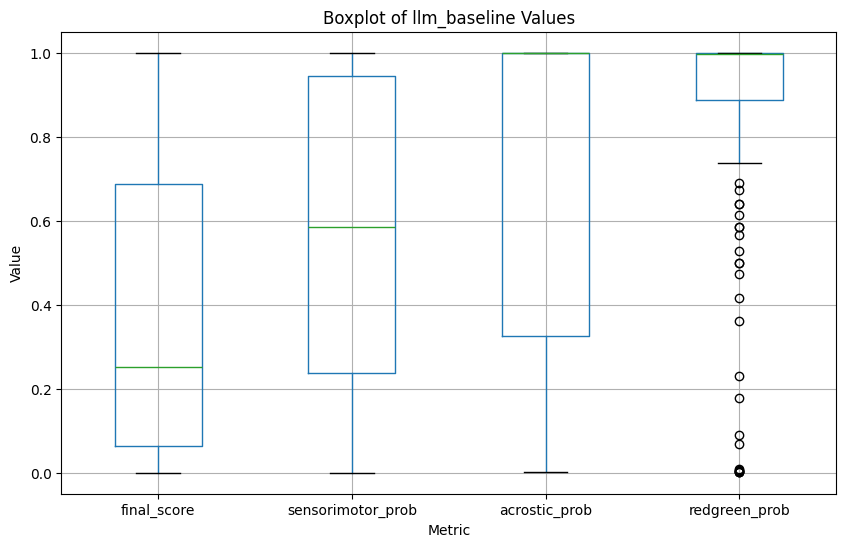

In [26]:
import json
import matplotlib.pyplot as plt
import pandas as pd

# Load the JSON file
with open('detection_results.json', 'r') as file:
    data = json.load(file)

# Extract the required values
values = {
    "final_score": [],
    "sensorimotor_prob": [],
    "acrostic_prob": [],
    "redgreen_prob": []
}

for entry in data:
    llm_baseline = entry['detection']['llm_baseline']
    values["final_score"].append(llm_baseline['final_score'])
    values["sensorimotor_prob"].append(llm_baseline['sensorimotor_prob'])
    values["acrostic_prob"].append(llm_baseline['acrostic_prob'])
    values["redgreen_prob"].append(llm_baseline['redgreen_prob'])

# Create a DataFrame
df = pd.DataFrame(values)

# Plot the boxplot
plt.figure(figsize=(10, 6))
df.boxplot()
plt.title('Boxplot of llm_baseline Values')
plt.ylabel('Value')
plt.xlabel('Metric')
plt.show()

In [62]:
import json
import time
from google_trans_new import google_translator  

# Function to translate text with retry logic
def translate_text(text, target_language='en', retries=3, delay=1):
    if not text:
        return ""  # Return empty string if text is None or empty
    
    translator = google_translator() 
    
    for attempt in range(retries):
        try:
            # Attempt the translation
            translation = translator.translate(text, lang_tgt=target_language)
            return translation.text
        except Exception as e:
            print(f"Error during translation: {e}. Attempt {attempt + 1} of {retries}")
            time.sleep(delay)  # Wait before retrying
    
    # If all attempts fail, return the original text
    print("Translation failed. Returning the original text.")
    return text

# Specify the JSON file name
json_file_name = "generation_results.json"

# Load the JSON data
with open(json_file_name, 'r') as json_file:
    data = json.load(json_file)

# Translate the outputs
translations = []
for entry in data:
    prompt = entry.get("prompt", "")
    
    # Translate each output to Spanish and back to English
    baseline = translate_text(translate_text(entry.get("baseline", ""), 'es'), 'en')
    llm_baseline = translate_text(translate_text(entry.get("llm_baseline", ""), 'es'), 'en')
    llm_senso_medium = translate_text(translate_text(entry.get("llm_senso_medium", ""), 'es'), 'en')
    llm_acro_medium = translate_text(translate_text(entry.get("llm_acro_medium", ""), 'es'), 'en')
    llm_redgreen_medium = translate_text(translate_text(entry.get("llm_redgreen_medium", ""), 'es'), 'en')
    llm_both_medium = translate_text(translate_text(entry.get("llm_both_medium", ""), 'es'), 'en')
    llm_senso_redgreen_medium = translate_text(translate_text(entry.get("llm_senso_redgreen_medium", ""), 'es'), 'en')
    llm_acro_redgreen_medium = translate_text(translate_text(entry.get("llm_acro_redgreen_medium", ""), 'es'), 'en')
    llm_all_three_medium = translate_text(translate_text(entry.get("llm_all_three_medium", ""), 'es'), 'en')

    # Append the translations to the list
    translations.append({
        "prompt": prompt,
        "baseline": baseline,
        "llm_baseline": llm_baseline,
        "llm_senso_medium": llm_senso_medium,
        "llm_acro_medium": llm_acro_medium,
        "llm_redgreen_medium": llm_redgreen_medium,
        "llm_both_medium": llm_both_medium,
        "llm_senso_redgreen_medium": llm_senso_redgreen_medium,
        "llm_acro_redgreen_medium": llm_acro_redgreen_medium,
        "llm_all_three_medium": llm_all_three_medium
    })

# Optionally, save the translations to a new JSON file
output_file_name = "translated_data.json"
with open(output_file_name, 'w') as output_file:
    json.dump(translations, output_file, indent=4, ensure_ascii=False)

print("Translations completed and saved to", output_file_name)


Error during translation: 404 (Not Found) from TTS API. Probable cause: Unknown. Attempt 1 of 3
Error during translation: 404 (Not Found) from TTS API. Probable cause: Unknown. Attempt 2 of 3
Error during translation: 404 (Not Found) from TTS API. Probable cause: Unknown. Attempt 3 of 3
Translation failed. Returning the original text.
Error during translation: 404 (Not Found) from TTS API. Probable cause: Unknown. Attempt 1 of 3
Error during translation: 404 (Not Found) from TTS API. Probable cause: Unknown. Attempt 2 of 3
Error during translation: 404 (Not Found) from TTS API. Probable cause: Unknown. Attempt 3 of 3


KeyboardInterrupt: 

In [61]:
!pip install google_trans_new 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [5]:
import json
import re
import random
import math
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration
from tqdm import tqdm

import os
os.chdir("/home/feline/master-generation")
# Parameters
replace_percentage = 0.10  # Default 10%
num_samples = None         # Set to None to process all samples
max_iterations_multiplier = 5  # To prevent infinite loops
batch_size = 8  # Batch size for processing masked sentences

# Debug flag
debug = False  # Set to True to enable debug outputs

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if debug:
    print(f"Using device: {device}")

# Load the JSON data
with open('generation_results_5.json', 'r') as f:
    data = json.load(f)

# Initialize T5 tokenizer and model
tokenizer = T5Tokenizer.from_pretrained('t5-base')
model = T5ForConditionalGeneration.from_pretrained('t5-base')
model.to(device)  # Move model to GPU if available

# Function to reconstruct text from words
def reconstruct_text(words):
    text = ''
    for i in range(len(words)):
        if i > 0:
            if re.match(r'\w', words[i]) and re.match(r'\w', words[i - 1]):
                text += ' '
            elif re.match(r'\w', words[i]) and words[i - 1] in (')', ']', '}', '"', "'"):
                text += ' '
            elif words[i] in ('(', '[', '{', '"', "'") and not words[i - 1].isspace():
                text += ' '
        text += words[i]
    return text

# Fields to process
fields_to_process = [
    "llm_baseline", "llm_senso_medium", "llm_acro_medium", "llm_redgreen_medium",
    "llm_both_medium", "llm_senso_redgreen_medium", "llm_acro_redgreen_medium",
    "llm_all_three_medium"
]

# Process samples
processed_data = []
samples_to_process = data if num_samples is None else data[:num_samples]

for sample_idx, sample in enumerate(tqdm(samples_to_process, desc="Processing samples")):
    if debug:
        print(f"\nProcessing sample {sample_idx + 1}/{len(samples_to_process)}")
    new_sample = sample.copy()
    for field in fields_to_process:
        if field in sample:
            if debug:
                print(f"\nProcessing field: {field}")
            text = sample[field]
            # Split text into words and punctuation
            words = re.findall(r'\w+|[^\w\s]', text, re.UNICODE)
            T = len(words)
            epsilon_T = max(1, math.ceil(replace_percentage * T))
            successful_replacements = 0
            iterations = 0
            max_iterations = max_iterations_multiplier * epsilon_T
            processed_indices = set()

            if debug:
                print(f"Total words: {T}")
                print(f"Replacement budget (epsilon_T): {epsilon_T}")
                print(f"Max iterations: {max_iterations}")

            # Create a list of available indices and shuffle them for randomness
            available_indices = list(range(T))
            random.shuffle(available_indices)

            while successful_replacements < epsilon_T and iterations < max_iterations and available_indices:
                # Prepare batch of masked sentences
                batch_input_texts = []
                batch_word_indices = []
                batch_original_words = []
                batch_size_current = min(batch_size, len(available_indices))
                indices_to_remove = []
                for idx in range(batch_size_current):
                    word_idx = available_indices[idx]
                    original_word = words[word_idx]
                    # Skip if the word is a special token
                    if original_word in tokenizer.all_special_tokens:
                        continue
                    words_masked = words.copy()
                    words_masked[word_idx] = '<extra_id_0>'
                    masked_text = reconstruct_text(words_masked)
                    batch_input_texts.append(masked_text)
                    batch_word_indices.append(word_idx)
                    batch_original_words.append(original_word)
                    indices_to_remove.append(word_idx)
                    iterations += 1

                # Remove processed indices
                for idx in indices_to_remove:
                    available_indices.remove(idx)
                    processed_indices.add(idx)

                if not batch_input_texts:
                    continue

                # Tokenize batch input texts
                input_ids = tokenizer(batch_input_texts, return_tensors='pt', padding=True, truncation=True).input_ids.to(device)
                # Generate outputs
                outputs = model.generate(
                    input_ids=input_ids,
                    max_length=50,
                    num_beams=10,          # Reduced from 50 to 10 for speed
                    num_return_sequences=3,  # Reduced from 20 to 3
                    early_stopping=True
                )

                # Process outputs
                num_return_sequences = 3
                outputs = outputs.view(len(batch_input_texts), num_return_sequences, -1)
                for i in range(len(batch_input_texts)):
                    word_idx = batch_word_indices[i]
                    original_word = batch_original_words[i]
                    output_sequences = outputs[i]
                    replacement_found = False
                    for output in output_sequences:
                        output_text = tokenizer.decode(output, skip_special_tokens=False)
                        # Extract the generated text after '<extra_id_0>'
                        split_text = output_text.split('<extra_id_0>')
                        if len(split_text) < 2:
                            continue
                        gen_text = split_text[1]
                        # Remove any additional '<extra_id_X>' tokens
                        gen_text = gen_text.split('<extra_id_')[0]
                        gen_text = gen_text.strip()
                        if gen_text and gen_text != original_word:
                            # Replace the word
                            words[word_idx] = gen_text
                            successful_replacements += 1
                            replacement_found = True
                            break  # Move to next word
                    if successful_replacements >= epsilon_T:
                        break

            # Reconstruct the final text
            final_text = reconstruct_text(words)
            new_sample[field] = final_text
            if debug:
                print(f"\nFinal text for field '{field}':\n{final_text}")

    processed_data.append(new_sample)

# Save the results to a new JSON file
with open('attack_data5.json', 'w') as f:
    json.dump(processed_data, f, indent=4)

if debug:
    print("\nProcessing completed. Results saved to 'output.json'.")


You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
/home/feline/miniconda3/envs/textgen/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Processing samples: 100%|██████████| 9/9 [08:47<00:00, 58.57s/it]


In [6]:
import spacy
import hashlib
from scipy.stats import zscore
from scipy.stats import norm
from itertools import permutations
from collections import Counter
import math
import modules.shared as shared

from scipy.stats import binom

def split_into_sentences(text):
    doc = nlp(text)
    sentences = []
    current_sentence = []

    for token in doc:
        current_sentence.append(token.text)
        if token.text in (".", "?", "!"):
            sentences.append(" ".join(current_sentence))
            current_sentence = []

    # Add the last sentence if not followed by a punctuation mark
    if current_sentence:
        sentences.append(" ".join(current_sentence))

    return sentences

def get_words_in_sentence(sentence):
    doc = nlp(sentence)
    words = [token.text for token in doc if not token.is_punct and not token.is_space]
    return words

import pandas as pd
df = pd.read_csv('Lancaster_sensorimotor_norms_for_39707_words.csv', header=0)  #the header is in the first row

shared.sensorimotor = df.set_index('Word').T.to_dict('dict')
shared.classes = ['Auditory.mean', 'Gustatory.mean','Haptic.mean','Interoceptive.mean','Olfactory.mean','Visual.mean','Foot_leg.mean','Hand_arm.mean','Head.mean','Mouth.mean','Torso.mean']

mean_value = [1.51,0.32,1.07,1.03,0.39,2.90,0.81,1.45,2.28,1.26,0.82]
std_deviation = [0.99,0.70,0.93,0.88,0.62,0.90,0.75,0.91,0.72,0.90,0.67]

generated_numbers = [0,0]
shared.secret_key = generated_numbers

def calculate_probs(reply):
    z_scores = []
    probabilities = []
    correct_acrosticons = 0
    old_class = 0

    sentences = split_into_sentences(reply)
    for idx, sentence in enumerate(sentences, start=1):
        print(sentence)
        if idx > 1:
            if(chr(ord('A') + generated_numbers[1]) == sentence[:1]):
                correct_acrosticons += 1

        range_list = [(0, 10), (0, 25)] 
        generated_numbers = secure_hash_to_numbers(last_sentence=sentence, last_token=None,range_list=range_list)
        shared.secret_key = generated_numbers

        sum_of_word_mean = 0
        valid_words = 0
        words = get_words_in_sentence(sentence)
        for word in words:
            if word.upper() in shared.sensorimotor:
                valid_words += 1
                sum_of_word_mean += shared.sensorimotor[word.upper()][shared.classes[old_class]]

        if(valid_words > 0):
            sentence_value = sum_of_word_mean/valid_words

            # Calculate Z-score for the new data point
            z_score = (sentence_value - mean_value[old_class]) / std_deviation[old_class]
        else:
            z_score = 0

        # Calculate the probability using the cumulative distribution function (CDF)
        probabilities.append(1-norm.cdf(z_score))
        z_scores.append(z_score)

        old_class = generated_numbers[0]



    def probability_of_acrosticon(num_sentences_starting_with_A, total_sentences, probability_of_A=1/26):

        # Calculate the binomial probability
        return binom.pmf(num_sentences_starting_with_A, total_sentences, probability_of_A)


    acrosticon_restult = probability_of_acrosticon(correct_acrosticons, len(sentences)-1)
    #print(f"The Acrosticon probability is: {acrosticon_restult} for {correct_acrosticons} correct acrosticons in {len(sentences)-1} valid sentences.")

    # Example usage:
    stouffer_result = 1-norm.cdf(sum(z_scores)/ math.sqrt(len(probabilities)))
    #print(probabilities)
    #print(f"The Stouffer's method combinded z_score is the probability of: {stouffer_result}")
    #print(f"The total probability is: {stouffer_result*acrosticon_restult}")

    #return stouffer_result*acrosticon_restult, len(sentences), correct_acrosticons
    return stouffer_result*acrosticon_restult, stouffer_result, acrosticon_restult, len(sentences), correct_acrosticons

scores = []
for tuple in results:
    score_base, stouffer_result_base, acrosticon_restult_base, len_base, acros_base = calculate_probs(tuple[1])
    score_watermark, stouffer_result_watermark, acrosticon_restult_watermark, len_watermark, acros_watermark = calculate_probs(tuple[2])

    scores.append([[score_base,stouffer_result_base, acrosticon_restult_base,len_base,acros_base],[score_watermark, stouffer_result_watermark, acrosticon_restult_watermark, len_watermark, acros_watermark]])



  the and ran in until roughly the latter half I use GoChat back go apple to apple tar apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple gel apple
  the B

In [8]:


# Specify the file name
file_name = "output_score9.csv"

# Open the file in write mode with newline='' to ensure correct line endings
with open(file_name, 'w', newline='') as csv_file:
    # Create a CSV writer object
    csv_writer = csv.writer(csv_file)

    # Write the data to the CSV file
    csv_writer.writerows(scores)

[([0.8244924197398473, 0.8244924197398473, 1.0, 1, 0], [0.20866363989568165, 0.25387122310442956, 0.8219271067593517, 6, 0])]


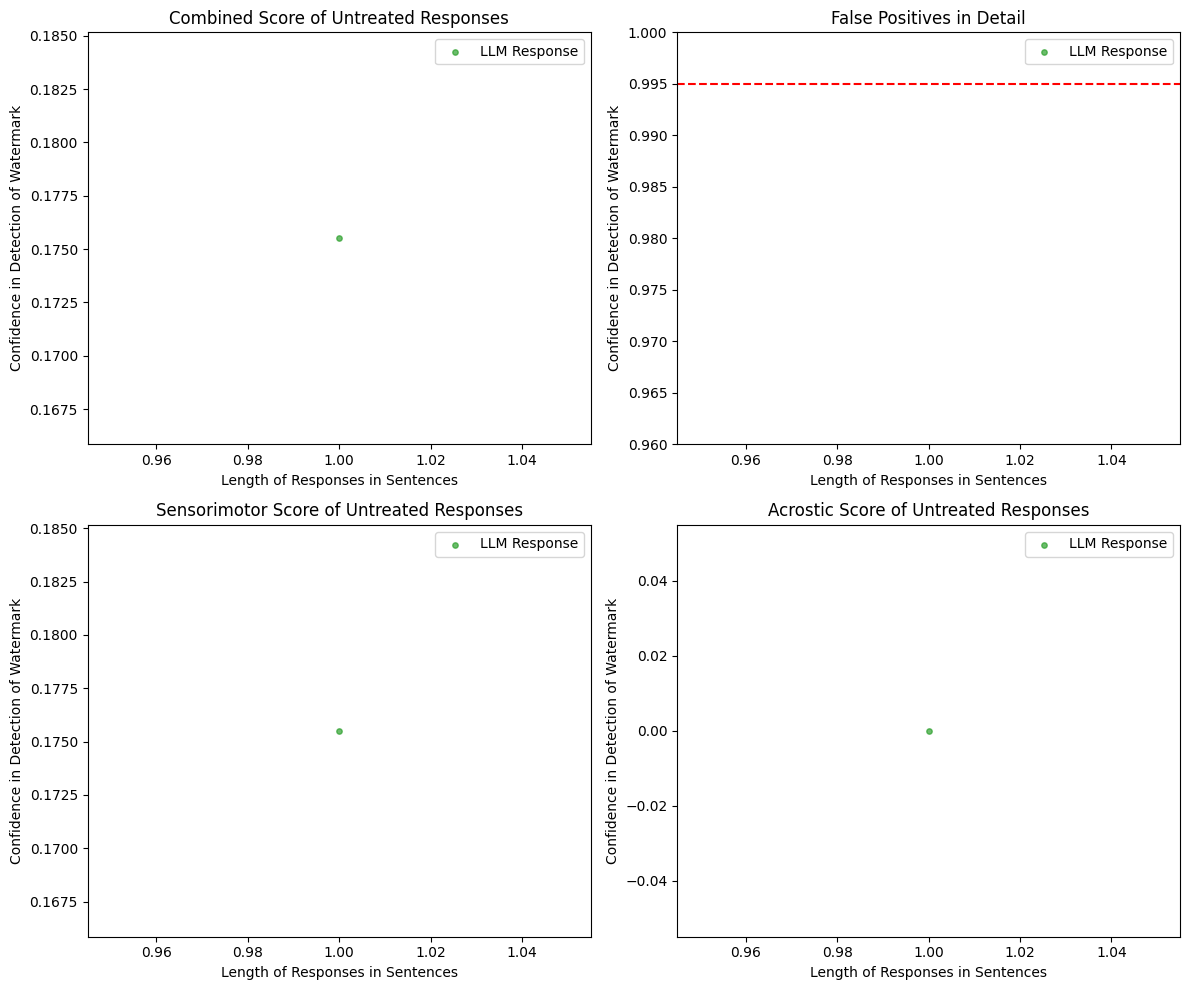

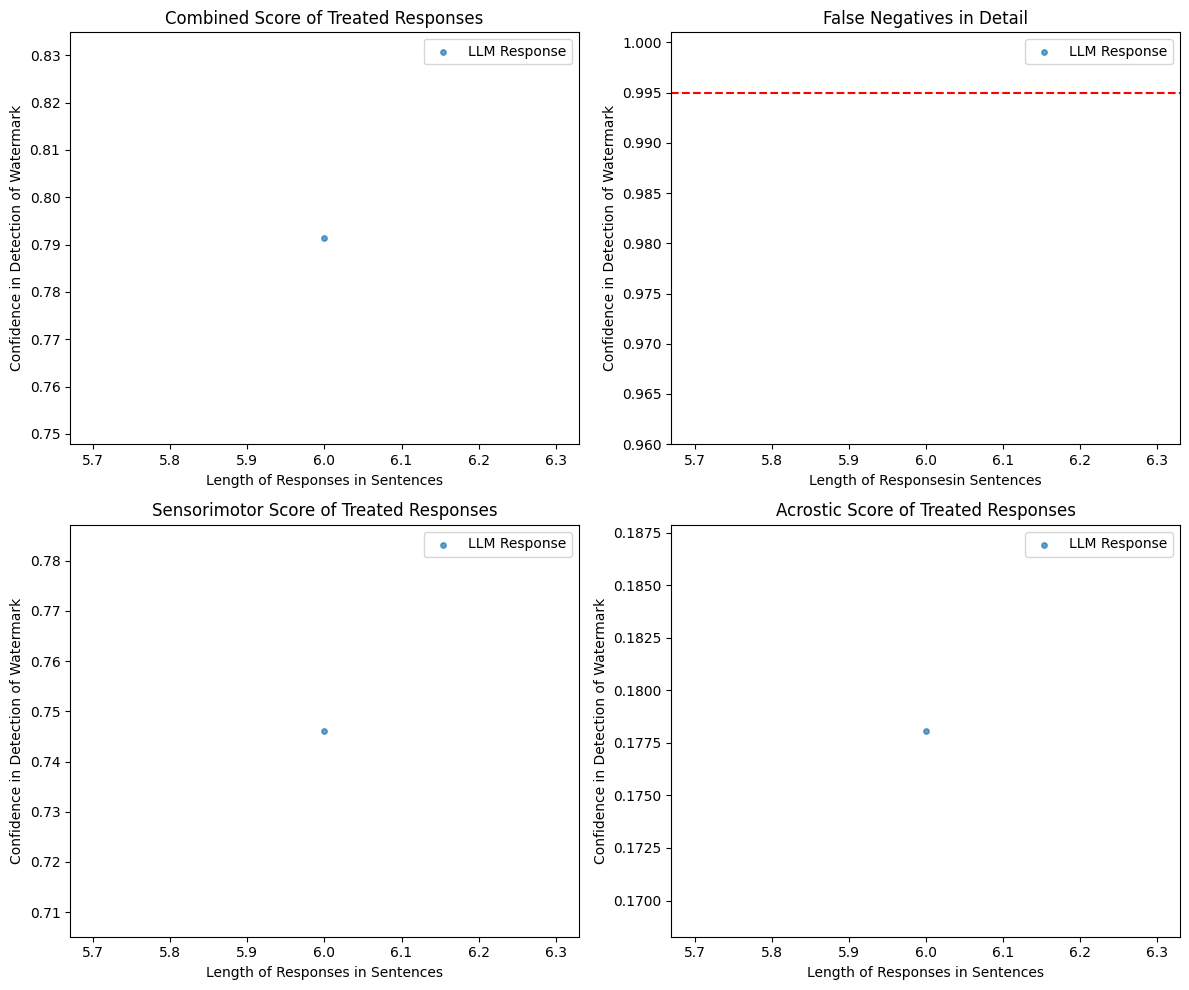

In [9]:
import csv
import ast
import matplotlib.pyplot as plt

# Define a function to convert string representations to lists
def convert_to_list(string):
    try:
        return ast.literal_eval(string)
    except (SyntaxError, ValueError):
        return string  # Return the original string if conversion is not possible

# Specify the file name
file_name = "output_score9.csv"
# Open the file in read mode
with open(file_name, 'r') as csv_file:
    # Create a CSV reader object
    csv_reader = csv.reader(csv_file)

    # Read the data from the CSV file, convert string representations to lists
    data = [convert_to_list(value) for row in csv_reader for value in row]

# Combine each pair into a single row
scores = [(data[i], data[i + 1]) for i in range(0, len(data), 2)]
print(scores)



# Create a figure with 2 rows and 2 columns of subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Subplot 1
y_values1 = [1-item[0][0] for item in scores]
x_values1 = [item[0][3] for item in scores]
axs[0, 0].scatter(x_values1, y_values1, s=15, alpha=0.7, c=['C2'], marker='o', label='LLM Response')
axs[0, 0].set_xlabel('Length of Responses in Sentences')
axs[0, 0].set_ylabel('Confidence in Detection of Watermark')
axs[0, 0].set_title('Combined Score of Untreated Responses')
axs[0, 0].legend()

# Subplot 2
y_values2 = [1-item[0][0] for item in scores]
x_values2 = [item[0][3] for item in scores]
axs[0, 1].scatter(x_values2, y_values2, s=15, alpha=0.7, c=['C2'], marker='o', label='LLM Response')
axs[0, 1].set_xlabel('Length of Responses in Sentences')
axs[0, 1].set_ylabel('Confidence in Detection of Watermark')
axs[0, 1].set_title('False Positives in Detail')
axs[0, 1].legend()
axs[0, 1].set_ylim(0.96, 1)  # Set the y-axis limit for the lower part
axs[0, 1].axhline(y=0.995, color='red', linestyle='--', label='Red Line')

# Subplot 3
y_values3 = [1-item[0][1] for item in scores]
x_values3 = [item[0][3] for item in scores]
axs[1, 0].scatter(x_values3, y_values3, s=15, alpha=0.7, c=['C2'], marker='o', label='LLM Response')
axs[1, 0].set_xlabel('Length of Responses in Sentences')
axs[1, 0].set_ylabel('Confidence in Detection of Watermark')
axs[1, 0].set_title('Sensorimotor Score of Untreated Responses')
axs[1, 0].legend()

# Subplot 4
y_values4 = [1-item[0][2] for item in scores]
x_values4 = [item[0][3] for item in scores]
axs[1, 1].scatter(x_values4, y_values4, s=15, alpha=0.7, c=['C2'], marker='o', label='LLM Response')
axs[1, 1].set_xlabel('Length of Responses in Sentences')
axs[1, 1].set_ylabel('Confidence in Detection of Watermark')
axs[1, 1].set_title('Acrostic Score of Untreated Responses')
axs[1, 1].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Show the combined figure
plt.show()




# Create a figure with 2 rows and 2 columns of subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Subplot 1
y_values1 = [1-item[1][0] for item in scores]
x_values1 = [item[1][3] for item in scores]
axs[0, 0].scatter(x_values1, y_values1, s=15, alpha=0.7, c=['C0'], marker='o', label='LLM Response')
axs[0, 0].set_xlabel('Length of Responses in Sentences')
axs[0, 0].set_ylabel('Confidence in Detection of Watermark')
axs[0, 0].set_title('Combined Score of Treated Responses')
axs[0, 0].legend()

# Subplot 2
y_values2 = [1-item[1][0] for item in scores]
x_values2 = [item[1][3] for item in scores]
axs[0, 1].scatter(x_values2, y_values2, s=15, alpha=0.7, c=['C0'], marker='o', label='LLM Response')
axs[0, 1].set_xlabel('Length of Responsesin Sentences')
axs[0, 1].set_ylabel('Confidence in Detection of Watermark')
axs[0, 1].set_title('False Negatives in Detail')
axs[0, 1].legend()
axs[0, 1].set_ylim(0.96, 1.001)  # Set the y-axis limit for the lower part
axs[0, 1].axhline(y=0.995, color='red', linestyle='--', label='Red Line')

# Subplot 3
y_values3 = [1-item[1][1] for item in scores]
x_values3 = [item[1][3] for item in scores]
axs[1, 0].scatter(x_values3, y_values3, s=15, alpha=0.7, c=['C0'], marker='o', label='LLM Response')
axs[1, 0].set_xlabel('Length of Responses in Sentences')
axs[1, 0].set_ylabel('Confidence in Detection of Watermark')
axs[1, 0].set_title('Sensorimotor Score of Treated Responses')
axs[1, 0].legend()

# Subplot 4
y_values4 = [1-item[1][2] for item in scores]
x_values4 = [item[1][3] for item in scores]
axs[1, 1].scatter(x_values4, y_values4, s=15, alpha=0.7, c=['C0'], marker='o', label='LLM Response')
axs[1, 1].set_xlabel('Length of Responses in Sentences')
axs[1, 1].set_ylabel('Confidence in Detection of Watermark')
axs[1, 1].set_title('Acrostic Score of Treated Responses')
axs[1, 1].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Show the combined figure
plt.show()

b_both_TN 25
b_both_FP 1
w_both_TP 35
w_both_FN 2


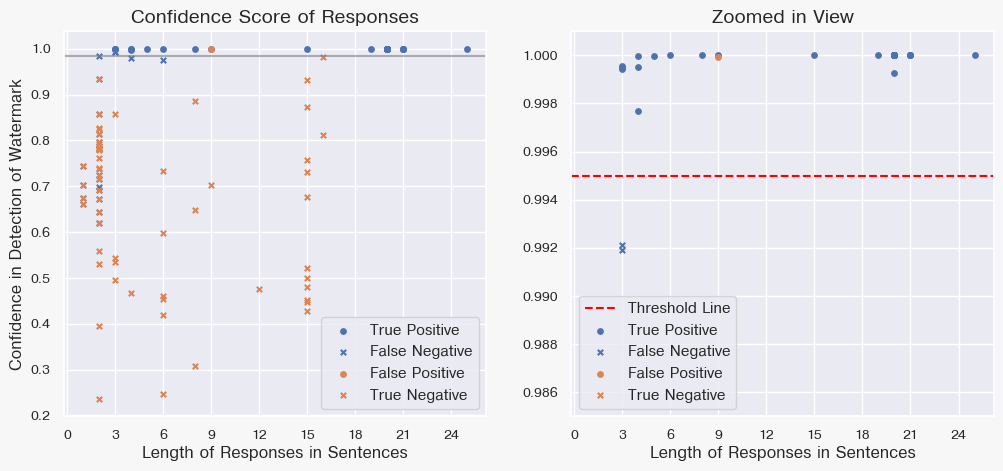

In [8]:
import csv
import ast
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MaxNLocator


# Define a function to convert string representations to lists
def convert_to_list(string):
    try:
        return ast.literal_eval(string)
    except (SyntaxError, ValueError):
        return string  # Return the original string if conversion is not possible

# Specify the file name
file_name = "output_score8.csv"
# Open the file in read mode
with open(file_name, 'r') as csv_file:
    # Create a CSV reader object
    csv_reader = csv.reader(csv_file)

    # Read the data from the CSV file, convert string representations to lists
    data = [convert_to_list(value) for row in csv_reader for value in row]

# Combine each pair into a single row
scores = [(data[i], data[i + 1]) for i in range(0, len(data), 2)]
#print(scores)



# Define a function to plot with different markers based on condition
def plot_with_condition(ax, x_values, y_values, threshold=0.995, colour='C0'):
    x_values = np.array(x_values)
    y_values = np.array(y_values)

    above_threshold = y_values >= threshold
    below_threshold = y_values < threshold

    above_threshold = y_values >= threshold
    below_threshold = y_values < threshold

    # Points above threshold
    ax.scatter(x_values[above_threshold], y_values[above_threshold], s=15, alpha=1, c=colour, marker='o', label='LLM Response (≥0.995)')
    # Points below threshold
    ax.scatter(x_values[below_threshold], y_values[below_threshold], s=15, alpha=1, c=colour, marker='x', label='LLM Response (<0.995)')

# Applying additional aesthetic improvements to the plots
# Set a style for the plots
import seaborn as sns
sns.set_theme()

#plt.style.use('seaborn-whitegrid')
plt.rcParams['font.family'] = 'Helvetica'


# Create a figure with 2 rows and 2 columns of subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Setting a light gray background color
fig.patch.set_facecolor('#f7f7f7')

# for ax in axs.flat:
#     ax.set_xlabel('Length of Responses in Sentences', fontsize=12)
#     ax.set_ylabel('Confidence in Detection of Watermark', fontsize=12)
#     ax.tick_params(axis='both', which='major', labelsize=10)
#     ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    #ax.set_facecolor('#f2f2f2')  # Apply the light gray background to each subplot
    

axs[0].set_xlabel('Length of Responses in Sentences', fontsize=12)
axs[0].set_ylabel('Confidence in Detection of Watermark', fontsize=12)
axs[0].tick_params(axis='both', which='major', labelsize=10)
axs[0].xaxis.set_major_locator(MaxNLocator(integer=True))

axs[1].set_xlabel('Length of Responses in Sentences', fontsize=12)
axs[1].set_ylabel(' ', fontsize=16)
axs[1].tick_params(axis='both', which='major', labelsize=10)
axs[1].xaxis.set_major_locator(MaxNLocator(integer=True))

# Subplot 1
y_values1 = [1.0-item[1][0] for item in scores]
x_values1 = [item[1][3] for item in scores]

x_values = np.array(x_values1)
y_values = np.array(y_values1)
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995

w_both_TP = 0
w_both_FN = 0
for i in range (0,60):
    if above_threshold[i]:
        if x_values[i] > 3:
            w_both_TP += 1
    else:
        if x_values[i] > 3:
            w_both_FN += 1

# Points above threshold
axs[0].scatter(x_values[above_threshold], y_values[above_threshold], s=15, alpha=1, c='C0', marker='o', label='True Positive')
# Points below threshold
axs[0].scatter(x_values[below_threshold], y_values[below_threshold], s=15, alpha=1, c='C0', marker='x', label='False Negative')



#axs[0, 0].scatter(x_values1, y_values1, s=15, alpha=0.7, c=['C4'], marker='o', label='LLM Response')



y_values2 = [1.0-item[0][0] for item in scores]
x_values2 = [item[0][3] for item in scores]

#######################################uncomment to print values
#for i in range (0,60):
    #print(f'''&{y_values2[i]} & {y_values1[i]}''')


x_values = np.array(x_values2)
y_values = np.array(y_values2)
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995

b_both_FP = 0
b_both_TN = 0
for i in range (0,60):
    if above_threshold[i]:
        if x_values[i] > 3:
            b_both_FP += 1
    else:
        if x_values[i] > 3:
            b_both_TN += 1
# Points above threshold
axs[0].scatter(x_values[above_threshold], y_values[above_threshold], s=15, alpha=1, c='C1', marker='o', label='False Positive')
# Points below threshold
axs[0].scatter(x_values[below_threshold], y_values[below_threshold], s=15, alpha=1, c='C1', marker='x', label='True Negative')


axs[0].set_title('Confidence Score of Responses', fontsize=14)
axs[0].legend()
axs[0].axhline(y=0.985, color='grey', linestyle='-', alpha=0.6)

# Subplot 2
axs[1].axhline(y=0.995, color='red', linestyle='--', label='Threshold Line')

x_values = np.array(x_values1)
y_values = np.array(y_values1)
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995


# Points above threshold
axs[1].scatter(x_values[above_threshold], y_values[above_threshold], s=15, alpha=1, c='C0', marker='o', label='True Positive')
# Points below threshold
axs[1].scatter(x_values[below_threshold], y_values[below_threshold], s=15, alpha=1, c='C0', marker='x', label='False Negative')
#axs[0, 1].scatter(x_values2, y_values2, s=15, alpha=0.7, c=['C4'], marker='o', label='LLM Response')
axs[1].set_title('Zoomed in View', fontsize=14)
axs[1].legend()
axs[1].set_ylim(0.985, 1.001)

x_values = np.array(x_values2)
y_values = np.array(y_values2)
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995
# Points above threshold
axs[1].scatter(x_values[above_threshold], y_values[above_threshold], s=15, alpha=1, c='C1', marker='o', label='False Positive')
# Points below threshold
axs[1].scatter(x_values[below_threshold], y_values[below_threshold], s=15, alpha=1, c='C1', marker='x', label='True Negative')
axs[1].legend()

print(f'''b_both_TN {b_both_TN}''')
print(f'''b_both_FP {b_both_FP}''')
print(f'''w_both_TP {w_both_TP}''')
print(f'''w_both_FN {w_both_FN}''')

plt.savefig('paper_plot.png', dpi=300, bbox_inches='tight')

[([0.173401239922371, 0.18033728951926586, 0.9615384615384615, 2, 0], [0.008095692064743856, 0.10945375671533686, 0.07396449704142016, 3, 1]), ([0.5528075667495754, 0.9572838433968545, 0.5774750828218062, 15, 0], [8.088322321246105e-29, 0.06199434289624539, 1.3046871606951035e-27, 20, 19]), ([0.30796416356680484, 0.32028273010947705, 0.9615384615384615, 2, 0], [0.30796416356680484, 0.32028273010947705, 0.9615384615384615, 2, 0]), ([0.26599358934253925, 0.32362187249339414, 0.8219271067593517, 6, 0], [2.3256557008037786e-29, 0.017825389647927015, 1.3046871606951035e-27, 20, 19]), ([0.26963812351506783, 0.46692598786685857, 0.5774750828218062, 15, 0], [7.049453852192648e-28, 0.540317561524625, 1.3046871606951035e-27, 20, 19]), ([0.3271091925485308, 0.3401935602504721, 0.9615384615384615, 2, 0], [0.3271091925485308, 0.3401935602504721, 0.9615384615384615, 2, 0]), ([0.21951100790989175, 0.22829144822628744, 0.9615384615384615, 2, 0], [0.21951100790989175, 0.22829144822628744, 0.96153846153

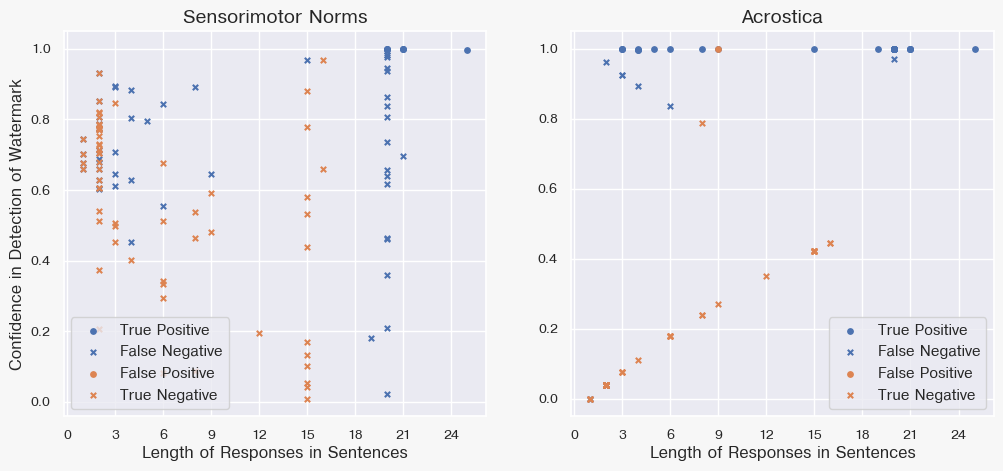

In [11]:
import csv
import ast
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MaxNLocator


# Define a function to convert string representations to lists
def convert_to_list(string):
    try:
        return ast.literal_eval(string)
    except (SyntaxError, ValueError):
        return string  # Return the original string if conversion is not possible

# Specify the file name
file_name = "output_score8.csv"
# Open the file in read mode
with open(file_name, 'r') as csv_file:
    # Create a CSV reader object
    csv_reader = csv.reader(csv_file)

    # Read the data from the CSV file, convert string representations to lists
    data = [convert_to_list(value) for row in csv_reader for value in row]

# Combine each pair into a single row
scores = [(data[i], data[i + 1]) for i in range(0, len(data), 2)]
print(scores)



# Define a function to plot with different markers based on condition
def plot_with_condition(ax, x_values, y_values, threshold=0.995, colour='C0'):
    x_values = np.array(x_values)
    y_values = np.array(y_values)

    above_threshold = y_values >= threshold
    below_threshold = y_values < threshold

    above_threshold = y_values >= threshold
    below_threshold = y_values < threshold

    # Points above threshold
    ax.scatter(x_values[above_threshold], y_values[above_threshold], s=15, alpha=1, c=colour, marker='o', label='LLM Response (≥0.995)')
    # Points below threshold
    ax.scatter(x_values[below_threshold], y_values[below_threshold], s=15, alpha=1, c=colour, marker='x', label='LLM Response (<0.995)')

# Applying additional aesthetic improvements to the plots
# Set a style for the plots
import seaborn as sns
sns.set_theme()

#plt.style.use('seaborn-whitegrid')
plt.rcParams['font.family'] = 'Helvetica'


# Create a figure with 2 rows and 2 columns of subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Setting a light gray background color
fig.patch.set_facecolor('#f7f7f7')

# for ax in axs.flat:
#     ax.set_xlabel('Length of Responses in Sentences', fontsize=12)
#     ax.set_ylabel('Confidence in Detection of Watermark', fontsize=12)
#     ax.tick_params(axis='both', which='major', labelsize=10)
#     ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    #ax.set_facecolor('#f2f2f2')  # Apply the light gray background to each subplot
    

axs[0].set_xlabel('Length of Responses in Sentences', fontsize=12)
axs[0].set_ylabel('Confidence in Detection of Watermark', fontsize=12)
axs[0].tick_params(axis='both', which='major', labelsize=10)
axs[0].xaxis.set_major_locator(MaxNLocator(integer=True))

axs[1].set_xlabel('Length of Responses in Sentences', fontsize=12)
axs[1].set_ylabel(' ', fontsize=16)
axs[1].tick_params(axis='both', which='major', labelsize=10)
axs[1].xaxis.set_major_locator(MaxNLocator(integer=True))

# Subplot 1
y_values1 = [1-item[1][1] for item in scores]
x_values1 = [item[1][3] for item in scores]
x_values = np.array(x_values1)
y_values = np.array(y_values1)
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995

w_senso_TP = 0
w_senso_FN = 0
for i in range (0,60):
    if above_threshold[i]:
        if x_values[i] > 3:
            w_senso_TP += 1
    else:
        if x_values[i] > 3:
            w_senso_FN += 1
       

# Points above threshold
axs[0].scatter(x_values[above_threshold], y_values[above_threshold], s=15, alpha=1, c='C0', marker='o', label='True Positive')
# Points below threshold
axs[0].scatter(x_values[below_threshold], y_values[below_threshold], s=15, alpha=1, c='C0', marker='x', label='False Negative')



#axs[0, 0].scatter(x_values1, y_values1, s=15, alpha=0.7, c=['C4'], marker='o', label='LLM Response')



y_values2 = [1-item[0][1] for item in scores]
x_values2 = [item[0][3] for item in scores]
x_values = np.array(x_values2)
y_values = np.array(y_values2)
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995

b_senso_FP = 0
b_senso_TN = 0
for i in range (0,60):
    if above_threshold[i]:
        if x_values[i] > 3:
            b_senso_FP += 1
    else:
        if x_values[i] > 3:
            b_senso_TN += 1

# Points above threshold
axs[0].scatter(x_values[above_threshold], y_values[above_threshold], s=15, alpha=1, c='C1', marker='o', label='False Positive')
# Points below threshold
axs[0].scatter(x_values[below_threshold], y_values[below_threshold], s=15, alpha=1, c='C1', marker='x', label='True Negative')





axs[0].set_title('Sensorimotor Norms', fontsize=14)
axs[0].legend()
#axs[0].axhline(y=0.985, color='grey', linestyle='-', alpha=0.6)

# Subplot 2
#axs[1].axhline(y=0.995, color='red', linestyle='--', label='Threshold Line')

y_values1 = [1-item[1][2] for item in scores]
x_values1 = [item[1][3] for item in scores]
x_values = np.array(x_values1)
y_values = np.array(y_values1)
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995

w_acro_TP = 0
w_acro_FN = 0
for i in range (0,60):
    if above_threshold[i]:
        if x_values[i] > 3:
            w_acro_TP += 1
    else:
        if x_values[i] > 3:
            w_acro_FN += 1

# Points above threshold
axs[1].scatter(x_values[above_threshold], y_values[above_threshold], s=15, alpha=1, c='C0', marker='o', label='True Positive')
# Points below threshold
axs[1].scatter(x_values[below_threshold], y_values[below_threshold], s=15, alpha=1, c='C0', marker='x', label='False Negative')
#axs[0, 1].scatter(x_values2, y_values2, s=15, alpha=0.7, c=['C4'], marker='o', label='LLM Response')
axs[1].set_title('Acrostica', fontsize=14)
axs[1].legend()
#axs[1].set_ylim(0.985, 1.001)

y_values2 = [1-item[0][2] for item in scores]
x_values2 = [item[0][3] for item in scores]
x_values = np.array(x_values2)
y_values = np.array(y_values2)
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995

b_acro_FP = 0
b_acro_TN = 0
for i in range (0,60):
    if above_threshold[i]:
        if x_values[i] > 3:
            b_acro_FP += 1
    else:
        if x_values[i] > 3:
            b_acro_TN += 1
            
# Points above threshold
axs[1].scatter(x_values[above_threshold], y_values[above_threshold], s=15, alpha=1, c='C1', marker='o', label='False Positive')
# Points below threshold
axs[1].scatter(x_values[below_threshold], y_values[below_threshold], s=15, alpha=1, c='C1', marker='x', label='True Negative')
axs[1].legend()


print(f'''b_senso_TN {b_senso_TN}''')
print(f'''b_senso_FP {b_senso_FP}''')
print(f'''w_senso_TP {w_senso_TP}''')
print(f'''w_senso_FN {w_senso_FN}''')
print(f'''b_acro_TN {b_acro_TN}''')
print(f'''b_acro_FP {b_acro_FP}''')
print(f'''w_acro_TP {w_acro_TP}''')
print(f'''w_acro_FN {w_acro_FN}''')

plt.savefig('ablation.png', dpi=300, bbox_inches='tight')

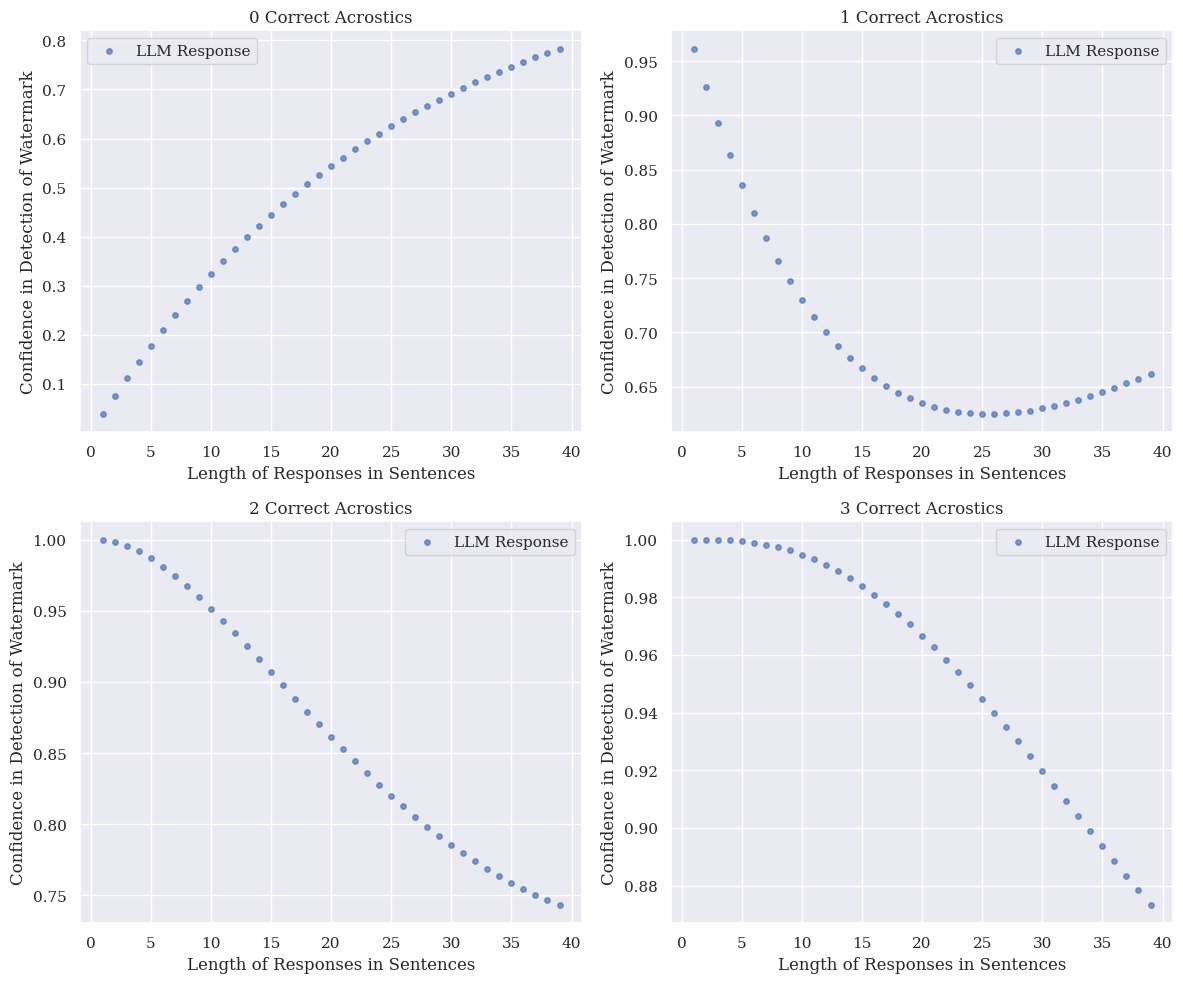

In [81]:
def probability_of_acrosticon(num_sentences_starting_with_A, total_sentences, probability_of_A=1/26):

        # Calculate the binomial probability
        return binom.pmf(num_sentences_starting_with_A, total_sentences, probability_of_A)


# Create a figure with 2 rows and 2 columns of subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Subplot 1
x_values1 = range(1,40)
y_values1 = []
for x in x_values1:
        y_values1.append(1-probability_of_acrosticon(0,x))
axs[0, 0].scatter(x_values1, y_values1, s=15, alpha=0.7, c=['C0'], marker='o', label='LLM Response')
axs[0, 0].set_xlabel('Length of Responses in Sentences')
axs[0, 0].set_ylabel('Confidence in Detection of Watermark')
axs[0, 0].set_title('0 Correct Acrostics')
axs[0, 0].legend()

# Subplot 2
x_values2 = range(1,40)
y_values2 = []
for x in x_values2:
        y_values2.append(1-probability_of_acrosticon(1,x))
axs[0, 1].scatter(x_values2, y_values2, s=15, alpha=0.7, c=['C0'], marker='o', label='LLM Response')
axs[0, 1].set_xlabel('Length of Responses in Sentences')
axs[0, 1].set_ylabel('Confidence in Detection of Watermark')
axs[0, 1].set_title('1 Correct Acrostics')
axs[0, 1].legend()

# Subplot 3
x_values3 = range(1,40)
y_values3 = []
for x in x_values3:
        y_values3.append(1-probability_of_acrosticon(2,x))
axs[1, 0].scatter(x_values3, y_values3, s=15, alpha=0.7, c=['C0'], marker='o', label='LLM Response')
axs[1, 0].set_xlabel('Length of Responses in Sentences')
axs[1, 0].set_ylabel('Confidence in Detection of Watermark')
axs[1, 0].set_title('2 Correct Acrostics')
axs[1, 0].legend()

# Subplot 4
x_values4 = range(1,40)
y_values4 = []
for x in x_values4:
        y_values4.append(1-probability_of_acrosticon(3,x))
axs[1, 1].scatter(x_values4, y_values4, s=15, alpha=0.7, c=['C0'], marker='o', label='LLM Response')
axs[1, 1].set_xlabel('Length of Responses in Sentences')
axs[1, 1].set_ylabel('Confidence in Detection of Watermark')
axs[1, 1].set_title('3 Correct Acrostics')
axs[1, 1].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Show the combined figure
plt.show()


In [12]:
import csv
from googletrans import Translator

# Function to translate text
def translate_text(text, target_language='en'):
    if not text:
        return ""  # Return empty string if text is None or empty
    try:
        translator = Translator()
        translation = translator.translate(text, dest=target_language)
        return translation.text
    except Exception as e:
        print(f"Error during translation: {e}")
        return text  # Return the original text if translation fails

# Specify the file name
file_name = "output_gen6.csv"

# Open the file in read mode
with open(file_name, 'r') as csv_file:
    # Create a CSV reader object and convert it to a list
    output_gen = list(csv.reader(csv_file))

# Example usage
translations = []
for text in output_gen:
    # Assuming text[2] is the column with the text to be translated
    # Check if text[2] exists and is not empty
    if len(text) > 2 and text[2]:
        translated_text_watermark = translate_text(text[2], 'es')  # Translate to Spanish
        #translated_text_watermark = translate_text(translated_text_watermark, 'en')  # Translate back to English

    else:
        translated_text_watermark = ""

    if len(text) > 2 and text[1]:
        translated_text_base = translate_text(text[1], 'es')  # Translate to Spanish
        #translated_text_base = translate_text(translated_text_base, 'en')  # Translate back to English
    else:
        translated_text_base = ""

    if len(text) > 2 and text[0]:
        prompt = text[0]
    else:
        prompt = ""

    
    translations.append([prompt,translated_text_base,translated_text_watermark])

Error during translation: the JSON object must be str, bytes or bytearray, not NoneType
Error during translation: the JSON object must be str, bytes or bytearray, not NoneType
Error during translation: the JSON object must be str, bytes or bytearray, not NoneType
Error during translation: the JSON object must be str, bytes or bytearray, not NoneType
Error during translation: the JSON object must be str, bytes or bytearray, not NoneType
Error during translation: the JSON object must be str, bytes or bytearray, not NoneType
Error during translation: the JSON object must be str, bytes or bytearray, not NoneType
Error during translation: the JSON object must be str, bytes or bytearray, not NoneType
Error during translation: the JSON object must be str, bytes or bytearray, not NoneType


In [13]:
import csv

# Specify the file name
file_name = "output_translation_genX.csv"

# Open the file in write mode with newline='' to ensure correct line endings
with open(file_name, 'w', newline='') as csv_file:
    # Create a CSV writer object
    csv_writer = csv.writer(csv_file)

    # Write the data to the CSV file
    csv_writer.writerows(translations)

In [14]:
import spacy
import hashlib
from scipy.stats import zscore
from scipy.stats import norm
from itertools import permutations
from collections import Counter
import math
import modules.shared as shared

from scipy.stats import binom

# def secure_hash_to_numbers(input_string, range_list):

    
#     nlp = spacy.load("en_core_web_sm")

#     doc = nlp(input_string)

    
#     core = [token.lemma_ for token in doc if not token.is_stop]

#     core_str = " ".join(core)
    
#     hashed_bytes = hashlib.sha256(core_str.encode()).digest()
    
    

#     num_numbers = len(range_list)
#     hashed_integers = [int.from_bytes(hashed_bytes[i:i+4], byteorder='big') for i in range(0, num_numbers * 4, 4)]

#     #cast hash to integer, then use modulo to map to required range
   
#     result_numbers = []
#     for i in range(num_numbers):
#         range_min, range_max = range_list[i]
#         integer = hashed_integers[i]
#         mapped_number = (integer % (range_max - range_min + 1)) + range_min
#         result_numbers.append(mapped_number)
    
#     return result_numbers


# Load the English language model
nlp = spacy.load("en_core_web_sm")

def split_into_sentences(text):
    doc = nlp(text)
    sentences = []
    current_sentence = []

    for token in doc:
        current_sentence.append(token.text)
        if token.text in (".", "?", "!"):
            sentences.append(" ".join(current_sentence))
            current_sentence = []

    # Add the last sentence if not followed by a punctuation mark
    if current_sentence:
        sentences.append(" ".join(current_sentence))

    return sentences

def get_words_in_sentence(sentence):
    doc = nlp(sentence)
    words = [token.text for token in doc if not token.is_punct and not token.is_space]
    return words

import pandas as pd
df = pd.read_csv('Lancaster_sensorimotor_norms_for_39707_words.csv', header=0)  #the header is in the first row

shared.sensorimotor = df.set_index('Word').T.to_dict('dict')
shared.classes = ['Auditory.mean', 'Gustatory.mean','Haptic.mean','Interoceptive.mean','Olfactory.mean','Visual.mean','Foot_leg.mean','Hand_arm.mean','Head.mean','Mouth.mean','Torso.mean']

mean_value = [1.51,0.32,1.07,1.03,0.39,2.90,0.81,1.45,2.28,1.26,0.82]
std_deviation = [0.99,0.70,0.93,0.88,0.62,0.90,0.75,0.91,0.72,0.90,0.67]


def calculate_probs(reply):
    z_scores = []
    probabilities = []
    correct_acrosticons = 0
    old_class = 0

    sentences = split_into_sentences(reply)
    for idx, sentence in enumerate(sentences, start=1):

        if idx > 1:
            if(chr(ord('A') + generated_numbers[1]) == sentence[:1]):
                correct_acrosticons += 1

        range_list = [(0, 10), (0, 25)] 
        generated_numbers = secure_hash_to_numbers(sentence, range_list)


        sum_of_word_mean = 0
        valid_words = 0
        words = get_words_in_sentence(sentence)
        for word in words:
            if word.upper() in shared.sensorimotor:
                valid_words += 1
                sum_of_word_mean += shared.sensorimotor[word.upper()][shared.classes[old_class]]

        if(valid_words > 0):
            sentence_value = sum_of_word_mean/valid_words

            # Calculate Z-score for the new data point
            z_score = (sentence_value - mean_value[old_class]) / std_deviation[old_class]
        else:
            z_score = 0

        # Calculate the probability using the cumulative distribution function (CDF)
        probabilities.append(1-norm.cdf(z_score))
        z_scores.append(z_score)

        old_class = generated_numbers[0]



    def probability_of_acrosticon(num_sentences_starting_with_A, total_sentences, probability_of_A=1/26):

        # Calculate the binomial probability
        return binom.pmf(num_sentences_starting_with_A, total_sentences, probability_of_A)


    acrosticon_restult = probability_of_acrosticon(correct_acrosticons, len(sentences)-1)
    #print(f"The Acrosticon probability is: {acrosticon_restult} for {correct_acrosticons} correct acrosticons in {len(sentences)-1} valid sentences.")

    # Example usage:
    stouffer_result = 1-norm.cdf(sum(z_scores)/ math.sqrt(len(probabilities)))
    #print(probabilities)
    #print(f"The Stouffer's method combinded z_score is the probability of: {stouffer_result}")
    #print(f"The total probability is: {stouffer_result*acrosticon_restult}")

    #return stouffer_result*acrosticon_restult, len(sentences), correct_acrosticons
    return stouffer_result*acrosticon_restult, stouffer_result, acrosticon_restult, len(sentences), correct_acrosticons

scores_translation = []


for tuple in translations:
    score_base, stouffer_result_base, acrosticon_restult_base, len_base, acros_base = calculate_probs(tuple[1])
    score_watermark, stouffer_result_watermark, acrosticon_restult_watermark, len_watermark, acros_watermark = calculate_probs(tuple[2])

    scores_translation.append([[score_base,stouffer_result_base, acrosticon_restult_base,len_base,acros_base],[score_watermark, stouffer_result_watermark, acrosticon_restult_watermark, len_watermark, acros_watermark]])




    

In [15]:
# Specify the file name
file_name = "output_translation_scoreX.csv"

# Open the file in write mode with newline='' to ensure correct line endings
with open(file_name, 'w', newline='') as csv_file:
    # Create a CSV writer object
    csv_writer = csv.writer(csv_file)

    # Write the data to the CSV file
    csv_writer.writerows(scores_translation)

In [8]:
import matplotlib.pyplot as plt

# Define a function to convert string representations to lists
def convert_to_list(string):
    try:
        return ast.literal_eval(string)
    except (SyntaxError, ValueError):
        return string  # Return the original string if conversion is not possible

# Specify the file name
file_name = "output_translation2.csv"
file_name = "output_translation2.csv"  # replace with your file name
scores_translation = []

# Open the file and read the contents
with open(file_name, 'r') as file:
    csv_reader = csv.reader(file)
    
    for row in csv_reader:
        # Convert each element in the row to float or int as appropriate
        data_row = [float(item) if '.' in item else int(item) for item in row]
        scores_translation.append(data_row)

# Create a figure with 2 rows and 2 columns of subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Subplot 1
y_values1 = [1-item[0] for item in scores_translation]
x_values1 = [item[3] for item in scores_translation]
axs[0, 0].scatter(x_values1, y_values1, s=15, alpha=0.7, c=['C4'], marker='o', label='LLM Response')
axs[0, 0].set_xlabel('Length of Responses in Sentences')
axs[0, 0].set_ylabel('Confidence in Detection of Watermark')
axs[0, 0].set_title('Combined Score of Treated Attacked Responses')
axs[0, 0].axhline(y=0.995, color='red', linestyle='--', label='Red Line')
axs[0, 0].legend()

x_values = np.array(x_values1)
y_values = np.array(y_values1)
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995
tw_both_TP = 0
tw_both_FN = 0
for i in range (0,60):
    if above_threshold[i]:
        if x_values[i] > 3:
            tw_both_TP += 1
    else:
        if x_values[i] > 3:
            tw_both_FN += 1



# Subplot 2
y_values2 = [1-item[0] for item in scores_translation]
x_values2 = [item[3] for item in scores_translation]
axs[0, 1].scatter(x_values2, y_values2, s=15, alpha=0.7, c=['C4'], marker='o', label='LLM Response')
axs[0, 1].set_xlabel('Length of Responses in Sentences')
axs[0, 1].set_ylabel('Confidence in Detection of Watermark')
axs[0, 1].set_title('False Negatives in Detail')
axs[0, 1].legend()
axs[0, 1].set_ylim(0.96, 1.001)  # Set the y-axis limit for the lower part
axs[0, 1].axhline(y=0.995, color='red', linestyle='--', label='Red Line')




# Subplot 3
y_values3 = [1-item[1] for item in scores_translation]
x_values3 = [item[3] for item in scores_translation]
axs[1, 0].scatter(x_values3, y_values3, s=15, alpha=0.7, c=['C4'], marker='o', label='LLM Response')
axs[1, 0].set_xlabel('Length of Responses in Sentences')
axs[1, 0].set_ylabel('Confidence in Detection of Watermark')
axs[1, 0].set_title('Sensorimotor Score of Treated Attacked Responses')
axs[1, 0].legend()

x_values = np.array(x_values3)
y_values = np.array(y_values3)
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995
tw_senso_TP = 0
tw_senso_FN = 0
for i in range (0,60):
    if above_threshold[i]:
        if x_values[i] > 3:
            tw_senso_TP += 1
    else:
        if x_values[i] > 3:
            tw_senso_FN += 1

# Subplot 4
y_values4 = [1-item[2] for item in scores_translation]
x_values4 = [item[3] for item in scores_translation]
axs[1, 1].scatter(x_values4, y_values4, s=15, alpha=0.7, c=['C4'], marker='o', label='LLM Response')
axs[1, 1].set_xlabel('Length of Responses in Sentences')
axs[1, 1].set_ylabel('Confidence in Detection of Watermark')
axs[1, 1].set_title('Acrostic Score of Treated Attacked Responses')
axs[1, 1].legend()


x_values = np.array(x_values4)
y_values = np.array(y_values4)
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995
tw_acro_TP = 0
tw_acro_FN = 0
for i in range (0,60):
    if above_threshold[i]:
        if x_values[i] > 3:
            tw_acro_TP += 1
    else:
        if x_values[i] > 3:
            tw_acro_FN += 1

print(f'''tw_both_TP {tw_both_TP}''')
print(f'''tw_both_FN {tw_both_FN}''')
print(f'''tw_senso_TP {tw_senso_TP}''')
print(f'''tw_senso_FN {tw_senso_FN}''')
print(f'''tw_acro_TP {tw_acro_TP}''')
print(f'''tw_acro_FN {tw_acro_FN}''')

# Adjust spacing between subplots
plt.tight_layout()

# Show the combined figure
plt.show()



FileNotFoundError: [Errno 2] No such file or directory: 'output_translation2.csv'

[[0.5297548768676754, 0.5297548768676754, 1.0, 1, 0], [0.5, 0.5, 1.0, 1, 0], [0.16313687894503626, 0.644985130122344, 0.2529312248083791, 10, 1], [0.0074157060185854155, 0.152459117397856, 0.0486406201554575, 11, 2], [0.4815686641915553, 0.5008314107592176, 0.9615384615384615, 2, 0], [0.3454519329611654, 0.37364081069079647, 0.9245562130177515, 3, 0], [0.11989614467796823, 0.14587199240902038, 0.8219271067593517, 6, 0], [0.48660592278700776, 0.640340197759805, 0.7599178132020633, 8, 0], [0.7973759062443191, 0.7973759062443191, 1.0, 1, 0], [0.7086198848130916, 0.8289850380348087, 0.8548041910297263, 5, 0], [0.12287687812504762, 0.5774913887787122, 0.2127769876965777, 8, 1], [0.5401003058225788, 0.5401003058225788, 1.0, 1, 0], [0.4936081321406111, 0.5133524574262356, 0.9615384615384615, 2, 0], [0.6035806721143874, 0.6035806721143874, 1.0, 1, 0], [0.5828720919037046, 0.7670199089657581, 0.7599178132020633, 8, 0], [0.7462422571933712, 0.7462422571933712, 1.0, 1, 0], [0.5576512335318943, 0.

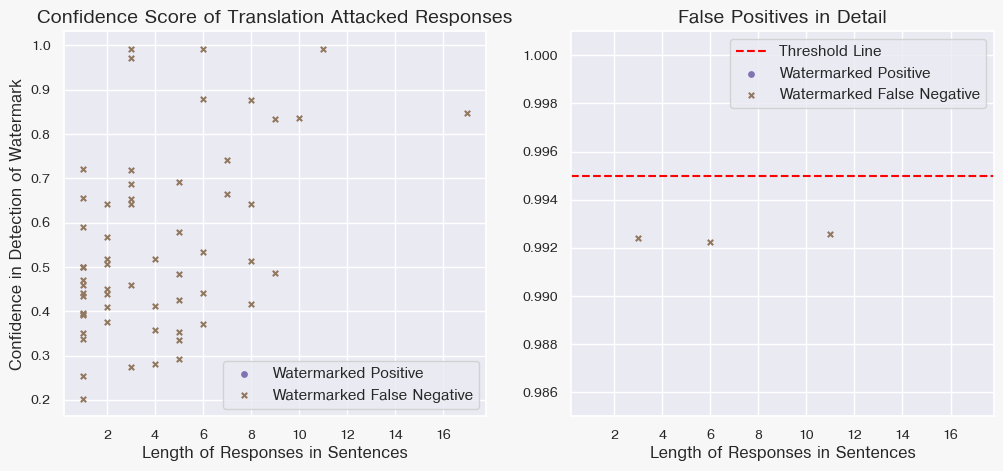

In [10]:
import csv
import ast
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MaxNLocator


import ast  # Import the ast module

scores = []

# Assuming 'file' is your file object
with open('output_score2.csv', 'r') as file:
    csv_reader = csv.reader(file)

    for row in csv_reader:
        # Check if the row looks like a string representation of a list
        if row[0].startswith('[') and row[0].endswith(']'):
            # Use ast.literal_eval to safely evaluate the string as a list
            data_row = ast.literal_eval(row[0])
        else:
            # For rows that do not contain a string representation of a list
            # Convert each element in the row to float or int as appropriate
            data_row = [float(item) if '.' in item else int(item) for item in row]
        
        scores.append(data_row)

print(scores)



# Define a function to plot with different markers based on condition
def plot_with_condition(ax, x_values, y_values, threshold=0.995, colour='C0'):
    x_values = np.array(x_values)
    y_values = np.array(y_values)

    above_threshold = y_values >= threshold
    below_threshold = y_values < threshold

    above_threshold = y_values >= threshold
    below_threshold = y_values < threshold

    # Points above threshold
    ax.scatter(x_values[above_threshold], y_values[above_threshold], s=15, alpha=1, c=colour, marker='o', label='LLM Response (≥0.995)')
    # Points below threshold
    ax.scatter(x_values[below_threshold], y_values[below_threshold], s=15, alpha=1, c=colour, marker='x', label='LLM Response (<0.995)')

# Applying additional aesthetic improvements to the plots
# Set a style for the plots
import seaborn as sns
sns.set_theme()

#plt.style.use('seaborn-whitegrid')
plt.rcParams['font.family'] = 'Helvetica'


# Create a figure with 2 rows and 2 columns of subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Setting a light gray background color
fig.patch.set_facecolor('#f7f7f7')

# for ax in axs.flat:
#     ax.set_xlabel('Length of Responses in Sentences', fontsize=12)
#     ax.set_ylabel('Confidence in Detection of Watermark', fontsize=12)
#     ax.tick_params(axis='both', which='major', labelsize=10)
#     ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    #ax.set_facecolor('#f2f2f2')  # Apply the light gray background to each subplot
    

axs[0].set_xlabel('Length of Responses in Sentences', fontsize=12)
axs[0].set_ylabel('Confidence in Detection of Watermark', fontsize=12)
axs[0].tick_params(axis='both', which='major', labelsize=10)
axs[0].xaxis.set_major_locator(MaxNLocator(integer=True))

axs[1].set_xlabel('Length of Responses in Sentences', fontsize=12)
axs[1].set_ylabel(' ', fontsize=16)
axs[1].tick_params(axis='both', which='major', labelsize=10)
axs[1].xaxis.set_major_locator(MaxNLocator(integer=True))

# Subplot 1
y_values1 = [1-item[:][0] for item in scores]
x_values1 = [item[:][3] for item in scores]
x_values = np.array(x_values1)
y_values = np.array(y_values1)
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995
# Points above threshold
axs[0].scatter(x_values[above_threshold], y_values[above_threshold], s=15, alpha=1, c='C4', marker='o', label='Watermarked Positive')
# Points below threshold
axs[0].scatter(x_values[below_threshold], y_values[below_threshold], s=15, alpha=1, c='C5', marker='x', label='Watermarked False Negative')



#axs[0, 0].scatter(x_values1, y_values1, s=15, alpha=0.7, c=['C4'], marker='o', label='LLM Response')



axs[0].set_title('Confidence Score of Translation Attacked Responses', fontsize=14)
axs[0].legend()
#axs[0].axhline(y=0.985, color='grey', linestyle='-', alpha=0.6)

# Subplot 2
axs[1].axhline(y=0.995, color='red', linestyle='--', label='Threshold Line')

x_values = np.array(x_values1)
y_values = np.array(y_values1)
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995
# Points above threshold
axs[1].scatter(x_values[above_threshold], y_values[above_threshold], s=15, alpha=1, c='C4', marker='o', label='Watermarked Positive')
# Points below threshold
axs[1].scatter(x_values[below_threshold], y_values[below_threshold], s=15, alpha=1, c='C5', marker='x', label='Watermarked False Negative')
#axs[0, 1].scatter(x_values2, y_values2, s=15, alpha=0.7, c=['C4'], marker='o', label='LLM Response')
axs[1].set_title('False Positives in Detail', fontsize=14)
axs[1].legend()
axs[1].set_ylim(0.985, 1.001)


axs[1].legend()

plt.savefig('oldhash.png', dpi=300, bbox_inches='tight')

b_both_TN 70
b_both_FP 6
w_both_TP 16
w_both_FN 56


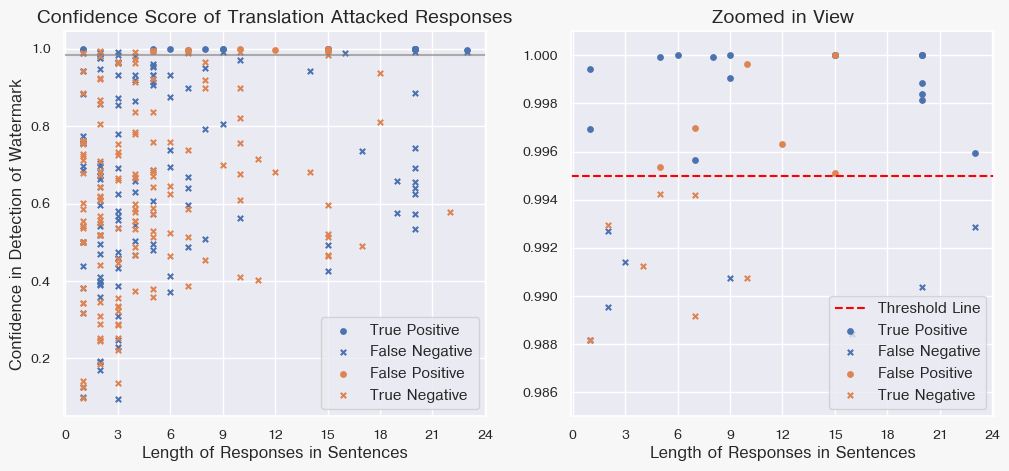

In [16]:
import csv
import ast
#%config InlineBackend.figure_format='svg'
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MaxNLocator


# Define a function to convert string representations to lists
def convert_to_list(string):
    try:
        return ast.literal_eval(string)
    except (SyntaxError, ValueError):
        return string  # Return the original string if conversion is not possible

# Specify the file name
file_name = "output_translation_scoreX.csv"
# Open the file in read mode
with open(file_name, 'r') as csv_file:
    # Create a CSV reader object
    csv_reader = csv.reader(csv_file)

    # Read the data from the CSV file, convert string representations to lists
    data = [convert_to_list(value) for row in csv_reader for value in row]

# Combine each pair into a single row
scores = [(data[i], data[i + 1]) for i in range(0, len(data), 2)]
#print(scores)



# Define a function to plot with different markers based on condition
def plot_with_condition(ax, x_values, y_values, threshold=0.995, colour='C0'):
    x_values = np.array(x_values)
    y_values = np.array(y_values)

    above_threshold = y_values >= threshold
    below_threshold = y_values < threshold

    above_threshold = y_values >= threshold
    below_threshold = y_values < threshold

    # Points above threshold
    ax.scatter(x_values[above_threshold], y_values[above_threshold], s=15, alpha=1, c=colour, marker='o', label='LLM Response (≥0.995)')
    # Points below threshold
    ax.scatter(x_values[below_threshold], y_values[below_threshold], s=15, alpha=1, c=colour, marker='x', label='LLM Response (<0.995)')

# Applying additional aesthetic improvements to the plots
# Set a style for the plots
import seaborn as sns
sns.set_theme()

#plt.style.use('seaborn-whitegrid')
plt.rcParams['font.family'] = 'Helvetica'


# Create a figure with 2 rows and 2 columns of subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Setting a light gray background color
fig.patch.set_facecolor('#f7f7f7')

# for ax in axs.flat:
#     ax.set_xlabel('Length of Responses in Sentences', fontsize=12)
#     ax.set_ylabel('Confidence in Detection of Watermark', fontsize=12)
#     ax.tick_params(axis='both', which='major', labelsize=10)
#     ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    #ax.set_facecolor('#f2f2f2')  # Apply the light gray background to each subplot
    

axs[0].set_xlabel('Length of Responses in Sentences', fontsize=12)
axs[0].set_ylabel('Confidence in Detection of Watermark', fontsize=12)
axs[0].tick_params(axis='both', which='major', labelsize=10)
axs[0].xaxis.set_major_locator(MaxNLocator(integer=True))

axs[1].set_xlabel('Length of Responses in Sentences', fontsize=12)
axs[1].set_ylabel(' ', fontsize=16)
axs[1].tick_params(axis='both', which='major', labelsize=10)
axs[1].xaxis.set_major_locator(MaxNLocator(integer=True))

# Subplot 1
y_values1 = [1.0-item[1][0] for item in scores]
x_values1 = [item[1][3] for item in scores]

x_values = np.array(x_values1)
y_values = np.array(y_values1)
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995

w_both_TP = 0
w_both_FN = 0
for i in range (0,156):
    if above_threshold[i]:
        if x_values[i] > 3:
            w_both_TP += 1
    else:
        if x_values[i] > 3:
            w_both_FN += 1

# Points above threshold
axs[0].scatter(x_values[above_threshold], y_values[above_threshold], s=15, alpha=1, c='C0', marker='o', label='True Positive')
# Points below threshold
axs[0].scatter(x_values[below_threshold], y_values[below_threshold], s=15, alpha=1, c='C0', marker='x', label='False Negative')



#axs[0, 0].scatter(x_values1, y_values1, s=15, alpha=0.7, c=['C4'], marker='o', label='LLM Response')



y_values2 = [1.0-item[0][0] for item in scores]
x_values2 = [item[0][3] for item in scores]

#######################################uncomment to print values
#for i in range (0,60):
    #print(f'''&{y_values2[i]} & {y_values1[i]}''')


x_values = np.array(x_values2)
y_values = np.array(y_values2)
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995

b_both_FP = 0
b_both_TN = 0
for i in range (0,156):
    if above_threshold[i]:
        if x_values[i] > 3:
            b_both_FP += 1
    else:
        if x_values[i] > 3:
            b_both_TN += 1
# Points above threshold
axs[0].scatter(x_values[above_threshold], y_values[above_threshold], s=15, alpha=1, c='C1', marker='o', label='False Positive')
# Points below threshold
axs[0].scatter(x_values[below_threshold], y_values[below_threshold], s=15, alpha=1, c='C1', marker='x', label='True Negative')


axs[0].set_title('Confidence Score of Translation Attacked Responses', fontsize=14)
axs[0].legend()
axs[0].axhline(y=0.985, color='grey', linestyle='-', alpha=0.6)

# Subplot 2
axs[1].axhline(y=0.995, color='red', linestyle='--', label='Threshold Line')

x_values = np.array(x_values1)
y_values = np.array(y_values1)
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995


# Points above threshold
axs[1].scatter(x_values[above_threshold], y_values[above_threshold], s=15, alpha=1, c='C0', marker='o', label='True Positive')
# Points below threshold
axs[1].scatter(x_values[below_threshold], y_values[below_threshold], s=15, alpha=1, c='C0', marker='x', label='False Negative')
#axs[0, 1].scatter(x_values2, y_values2, s=15, alpha=0.7, c=['C4'], marker='o', label='LLM Response')
axs[1].set_title('Zoomed in View', fontsize=14)
axs[1].legend()
axs[1].set_ylim(0.985, 1.001)

x_values = np.array(x_values2)
y_values = np.array(y_values2)
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995
# Points above threshold
axs[1].scatter(x_values[above_threshold], y_values[above_threshold], s=15, alpha=1, c='C1', marker='o', label='False Positive')
# Points below threshold
axs[1].scatter(x_values[below_threshold], y_values[below_threshold], s=15, alpha=1, c='C1', marker='x', label='True Negative')
axs[1].legend()

print(f'''b_both_TN {b_both_TN}''')
print(f'''b_both_FP {b_both_FP}''')
print(f'''w_both_TP {w_both_TP}''')
print(f'''w_both_FN {w_both_FN}''')

plt.savefig('paper_plot_translation.png', dpi=300, bbox_inches='tight')

[([0.5297548768676754, 0.5297548768676754, 1.0, 1, 0], [0.3281204982094562, 0.3281204982094562, 1.0, 1, 0]), ([0.6166518151174941, 0.6669706032310816, 0.9245562130177515, 3, 0], [8.553158817654539e-11, 0.18603365304089636, 4.5976406299855176e-10, 20, 10]), ([0.519091104498668, 0.5839068961707898, 0.8889963586709148, 4, 0], [0.2906362734298562, 0.30226172436705045, 0.9615384615384615, 2, 0]), ([0.594967782715279, 0.6187664940238902, 0.9615384615384615, 2, 0], [4.595478481516161e-13, 0.03054118608804135, 1.504682387995258e-11, 20, 11]), ([0.4929113609549464, 0.53313292800887, 0.9245562130177515, 3, 0], [0.22653737190337375, 0.22653737190337375, 1.0, 1, 0]), ([0.6216508991115235, 0.6216508991115235, 1.0, 1, 0], [0.0003560309241830312, 0.35194742151679437, 0.0010116025929345867, 7, 3]), ([0.5350870127442552, 0.5350870127442552, 1.0, 1, 0], [0.0043513289140891835, 0.3308785595389778, 0.013150833708149628, 6, 2]), ([0.6626609602814836, 0.6626609602814836, 1.0, 1, 0], [0.6191067768285119, 0.6

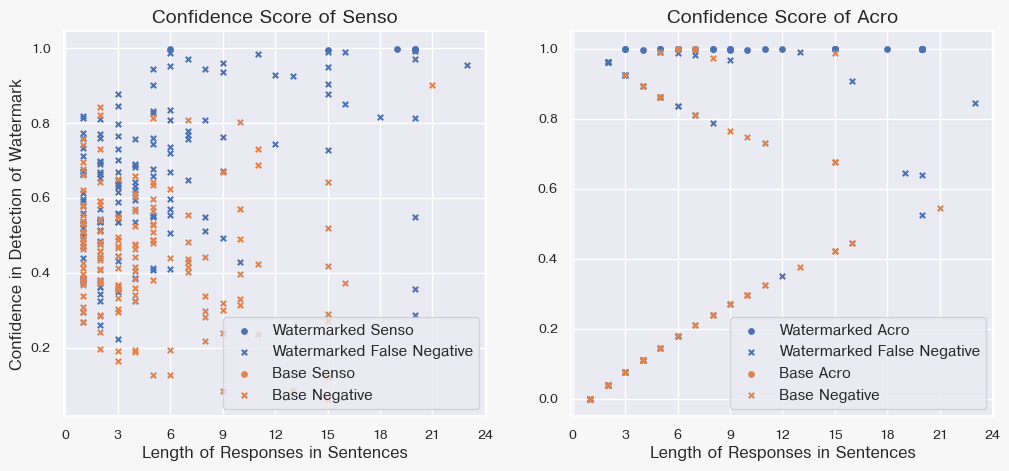

In [1]:
import csv
import ast
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MaxNLocator


# Define a function to convert string representations to lists
def convert_to_list(string):
    try:
        return ast.literal_eval(string)
    except (SyntaxError, ValueError):
        return string  # Return the original string if conversion is not possible

# Specify the file name
file_name = "output_translation_score6.csv"
# Open the file in read mode
with open(file_name, 'r') as csv_file:
    # Create a CSV reader object
    csv_reader = csv.reader(csv_file)

    # Read the data from the CSV file, convert string representations to lists
    data = [convert_to_list(value) for row in csv_reader for value in row]

# Combine each pair into a single row
scores = [(data[i], data[i + 1]) for i in range(0, len(data), 2)]
print(scores)



# Define a function to plot with different markers based on condition
def plot_with_condition(ax, x_values, y_values, threshold=0.995, colour='C0'):
    x_values = np.array(x_values)
    y_values = np.array(y_values)

    above_threshold = y_values >= threshold
    below_threshold = y_values < threshold

    above_threshold = y_values >= threshold
    below_threshold = y_values < threshold

    # Points above threshold
    ax.scatter(x_values[above_threshold], y_values[above_threshold], s=15, alpha=1, c=colour, marker='o', label='LLM Response (≥0.995)')
    # Points below threshold
    ax.scatter(x_values[below_threshold], y_values[below_threshold], s=15, alpha=1, c=colour, marker='x', label='LLM Response (<0.995)')

# Applying additional aesthetic improvements to the plots
# Set a style for the plots
import seaborn as sns
sns.set_theme()

#plt.style.use('seaborn-whitegrid')
plt.rcParams['font.family'] = 'Helvetica'


# Create a figure with 2 rows and 2 columns of subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Setting a light gray background color
fig.patch.set_facecolor('#f7f7f7')

# for ax in axs.flat:
#     ax.set_xlabel('Length of Responses in Sentences', fontsize=12)
#     ax.set_ylabel('Confidence in Detection of Watermark', fontsize=12)
#     ax.tick_params(axis='both', which='major', labelsize=10)
#     ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    #ax.set_facecolor('#f2f2f2')  # Apply the light gray background to each subplot
    

axs[0].set_xlabel('Length of Responses in Sentences', fontsize=12)
axs[0].set_ylabel('Confidence in Detection of Watermark', fontsize=12)
axs[0].tick_params(axis='both', which='major', labelsize=10)
axs[0].xaxis.set_major_locator(MaxNLocator(integer=True))

axs[1].set_xlabel('Length of Responses in Sentences', fontsize=12)
axs[1].set_ylabel(' ', fontsize=16)
axs[1].tick_params(axis='both', which='major', labelsize=10)
axs[1].xaxis.set_major_locator(MaxNLocator(integer=True))

# Subplot 1
y_values1 = [1-item[1][1] for item in scores]
x_values1 = [item[1][3] for item in scores]
x_values = np.array(x_values1)
y_values = np.array(y_values1)
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995

w_senso_TP = 0
w_senso_FN = 0
for i in range (0,156):
    if above_threshold[i]:
        if x_values[i] > 3:
            w_senso_TP += 1
    else:
        if x_values[i] > 3:
            w_senso_FN += 1
       

# Points above threshold
axs[0].scatter(x_values[above_threshold], y_values[above_threshold], s=15, alpha=1, c='C0', marker='o', label='Watermarked Senso')
# Points below threshold
axs[0].scatter(x_values[below_threshold], y_values[below_threshold], s=15, alpha=1, c='C0', marker='x', label='Watermarked False Negative')



#axs[0, 0].scatter(x_values1, y_values1, s=15, alpha=0.7, c=['C4'], marker='o', label='LLM Response')



y_values2 = [1-item[0][1] for item in scores]
x_values2 = [item[0][3] for item in scores]
x_values = np.array(x_values2)
y_values = np.array(y_values2)
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995

b_senso_FP = 0
b_senso_TN = 0
for i in range (0,156):
    if above_threshold[i]:
        if x_values[i] > 3:
            b_senso_FP += 1
    else:
        if x_values[i] > 3:
            b_senso_TN += 1

# Points above threshold
axs[0].scatter(x_values[above_threshold], y_values[above_threshold], s=15, alpha=1, c='C1', marker='o', label='Base Senso')
# Points below threshold
axs[0].scatter(x_values[below_threshold], y_values[below_threshold], s=15, alpha=1, c='C1', marker='x', label='Base Negative')





axs[0].set_title('Confidence Score of Senso', fontsize=14)
axs[0].legend()
#axs[0].axhline(y=0.985, color='grey', linestyle='-', alpha=0.6)

# Subplot 2
#axs[1].axhline(y=0.995, color='red', linestyle='--', label='Threshold Line')

y_values1 = [1-item[1][2] for item in scores]
x_values1 = [item[1][3] for item in scores]
x_values = np.array(x_values1)
y_values = np.array(y_values1)
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995

w_acro_TP = 0
w_acro_FN = 0
for i in range (0,156):
    if above_threshold[i]:
        if x_values[i] > 3:
            w_acro_TP += 1
    else:
        if x_values[i] > 3:
            w_acro_FN += 1

# Points above threshold
axs[1].scatter(x_values[above_threshold], y_values[above_threshold], s=15, alpha=1, c='C0', marker='o', label='Watermarked Acro')
# Points below threshold
axs[1].scatter(x_values[below_threshold], y_values[below_threshold], s=15, alpha=1, c='C0', marker='x', label='Watermarked False Negative')
#axs[0, 1].scatter(x_values2, y_values2, s=15, alpha=0.7, c=['C4'], marker='o', label='LLM Response')
axs[1].set_title('Confidence Score of Acro', fontsize=14)
axs[1].legend()
#axs[1].set_ylim(0.985, 1.001)

y_values2 = [1-item[0][2] for item in scores]
x_values2 = [item[0][3] for item in scores]
x_values = np.array(x_values2)
y_values = np.array(y_values2)
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995
above_threshold = y_values >= 0.995
below_threshold = y_values < 0.995

b_acro_FP = 0
b_acro_TN = 0
for i in range (0,156):
    if above_threshold[i]:
        if x_values[i] > 3:
            b_acro_FP += 1
    else:
        if x_values[i] > 3:
            b_acro_TN += 1
            
# Points above threshold
axs[1].scatter(x_values[above_threshold], y_values[above_threshold], s=15, alpha=1, c='C1', marker='o', label='Base Acro')
# Points below threshold
axs[1].scatter(x_values[below_threshold], y_values[below_threshold], s=15, alpha=1, c='C1', marker='x', label='Base Negative')
axs[1].legend()


print(f'''b_senso_TN {b_senso_TN}''')
print(f'''b_senso_FP {b_senso_FP}''')
print(f'''w_senso_TP {w_senso_TP}''')
print(f'''w_senso_FN {w_senso_FN}''')
print(f'''b_acro_TN {b_acro_TN}''')
print(f'''b_acro_FP {b_acro_FP}''')
print(f'''w_acro_TP {w_acro_TP}''')
print(f'''w_acro_FN {w_acro_FN}''')

#plt.savefig('ablation.png', dpi=300, bbox_inches='tight')

In [8]:

prompts = [\
    "How do I write a good paper?"
    #"What is a watermark?"
    #"What is motorsports, is it a real sport?",
]



results = []


for prompt in prompts:
#prompt = "What is the capital of France?"
    question = f'''<|im_start|>system
You are a helpful assistant, who always provide explanation. Don't enumerate anwsers, talk for the user, write links or urls or use numbers.<|im_end|>
<|im_start|>user
{prompt}<|im_end|>
<|im_start>assistant
'''

    generate_params = {
        'max_new_tokens' : 200,
        'add_bos_token' : False,
        'truncation_length' : 4096,
        'custom_stopping_strings' : ["### Human:", "Human:", "user:", "Q:","<|im_end|>","<|im_start|>system"],
        'ban_eos_token' : False,
        'skip_special_tokens' : False,
        'do_sample': True,
        'temperature': 0.7,
        'top_p': 0.95,
        'typical_p': 1,
        'repetition_penalty': 1.10,
        'encoder_repetition_penalty': 1,
        'top_k': 40,
        'num_beams': 1,
        'penalty_alpha': 0,
        'min_length': 0,
        'length_penalty': 1,
        'no_repeat_ngram_size': 0,
        'early_stopping': False,
        'seed' : 0,
    }

    #no watermark
    shared.delta_char = 0.0
    shared.delta_acro = 0.0
    shared.secret_key = [0,0]
    done = False
    reply_base = ""
    reply_current = ""
    current_question = question
    shared.new_sentence = False
    shared.delta_senso = 0
    shared.start = 0
    # i = 0
    # while (done is not True and i < 4):
    #     reply_current, done = generate_reply(current_question, generate_params, eos_token='<|im_end|>')

    #     last_sentence = get_last_sentence(reply_current)
    #     #print("------------------found end of sentence, last sentence is:")
    #     #print(f'''[{reply_current}]''')
    #     shared.secret_key = secure_hash_to_numbers(last_sentence,[(0, 10), (0, 25)])
    #     shared.new_sentence = True
    #     shared.start = 0
    #     reply_base += reply_current
    #     current_question = f'''{current_question}{reply_current}'''
    #     i+=1
    reply_base, done = generate_reply(current_question, generate_params, eos_token='<|im_end|>')

    #only senso
    shared.delta_char = 2.5#2.5
    shared.delta_acro = 0.0#50
    shared.secret_key = [0,0]
    done = False
    reply_senso = ""
    reply_current = ""
    current_question = question
    shared.new_sentence = False
    shared.delta_senso = 0
    shared.start = 0
    # i = 0
    # while (done is not True and i < 4):
    #     reply_current, done = generate_reply(current_question, generate_params, eos_token='<|im_end|>')

    #     last_sentence = get_last_sentence(reply_current)
    #     #print("------------------found end of sentence, last sentence is:")
    #     #print(f'''[{reply_current}]''')
    #     shared.secret_key = secure_hash_to_numbers(last_sentence,[(0, 10), (0, 25)])
    #     shared.new_sentence = True
    #     shared.start = 0
    #     reply_senso += reply_current
    #     current_question = f'''{current_question}{reply_current}'''
    #     i+=1

    reply_senso, done = generate_reply(current_question, generate_params, eos_token='<|im_end|>')
    
    #only acro
    shared.delta_char = 0.0#2.5
    shared.delta_acro = 20.0#50
    shared.secret_key = [0,0]
    done = False
    reply_acro = ""
    reply_current = ""
    current_question = question
    shared.new_sentence = False
    shared.delta_senso = 0
    shared.start = 0
    # i = 0
    # while (done is not True and i < 4):
    #     reply_current, done = generate_reply(current_question, generate_params, eos_token='<|im_end|>')

    #     last_sentence = get_last_sentence(reply_current)
    #     #print("------------------found end of sentence, last sentence is:")
    #     #print(f'''[{reply_current}]''')
    #     shared.secret_key = secure_hash_to_numbers(last_sentence,[(0, 10), (0, 25)])
    #     shared.new_sentence = True
    #     shared.start = 0
    #     reply_acro += reply_current
    #     current_question = f'''{current_question}{reply_current}'''
    #     i+=1
    reply_acro, done = generate_reply(current_question, generate_params, eos_token='<|im_end|>')

    #both
    shared.delta_char = 2.5#2.5
    shared.delta_acro = 20.0#50
    shared.secret_key = [0,0]
    done = False
    reply_watermark = ""
    reply_current = ""
    current_question = question
    shared.new_sentence = False
    shared.delta_senso = 0
    shared.start = 0
    # i = 0
    # while (done is not True and i < 4):
    #     reply_current, done = generate_reply(current_question, generate_params, eos_token='<|im_end|>')

    #     last_sentence = get_last_sentence(reply_current)
    #     #print("------------------found end of sentence, last sentence is:")
    #     #print(f'''[{reply_current}]''')
    #     shared.secret_key = secure_hash_to_numbers(last_sentence,[(0, 10), (0, 25)])
    #     shared.new_sentence = True
    #     shared.start = 0
    #     reply_watermark += reply_current
    #     current_question = f'''{current_question}{reply_current}'''
    #     i+=1
    reply_watermark, done = generate_reply(current_question, generate_params, eos_token='<|im_end|>')


    #results.append([prompt,reply_base,reply_watermark])
    results.append([prompt,reply_base,reply_senso,reply_acro,reply_watermark])


    #reply_watermark = generate_reply(question+reply_watermark, generate_params, eos_token='<|im_end|>')
    print(prompt)
    print(f'''[{reply_base}]''')
    print(f'''[{reply_senso}]''')
    print(f'''[{reply_acro}]''')
    print(f'''[{reply_watermark}]''')

Output generated in 1.04 seconds (11.58 tokens/s, 12 tokens, context 84, seed 0)
Output generated in 1.40 seconds (13.56 tokens/s, 19 tokens, context 96, seed 0)
Output generated in 1.45 seconds (14.52 tokens/s, 21 tokens, context 115, seed 0)
Output generated in 1.46 seconds (13.70 tokens/s, 20 tokens, context 135, seed 0)
Output generated in 0.99 seconds (12.15 tokens/s, 12 tokens, context 84, seed 0)
Output generated in 1.81 seconds (14.91 tokens/s, 27 tokens, context 96, seed 0)
Output generated in 1.69 seconds (14.81 tokens/s, 25 tokens, context 123, seed 0)
Output generated in 1.20 seconds (11.64 tokens/s, 14 tokens, context 147, seed 0)
Output generated in 1.00 seconds (11.98 tokens/s, 12 tokens, context 84, seed 0)
Output generated in 1.83 seconds (16.40 tokens/s, 30 tokens, context 96, seed 0)
Output generated in 1.65 seconds (13.98 tokens/s, 23 tokens, context 126, seed 0)
Output generated in 1.06 seconds (11.35 tokens/s, 12 tokens, context 84, seed 0)
Output generated in 1.8

In [2]:
results2 = [["What is motorsports, is it a real sport?",
             "Motorsports is a sport that uses vehicles for competition. Many people consider motorsports to be a form of racing, but they can also be classified as an extreme sport due to the level of danger and physical exertion involved.The term motorsport is used to refer to many different types of competitions involving motorized vehicles.The most common type of motorsport is car racing, which includes events such as Formula One, NASCAR, and rallying.",
            "Motorsports is a sport that uses vehicles for competition. Many people disagree because they say that it is dangerous and cruel to animals, but what do you think? You can share your opinion on social network like facebook or you can comment this forum.",
            " Motorsports is a sport that uses vehicles for competition. Races can be held on land, water, ice, or snow, and may be based on speed, distance, or performance criteria such as endurance or durability. Races may also involve other forms of human-propelled vehicle or animal. Racers usually compete against each other, but races may also be against time.",
            " Motorsports is a sport that uses vehicles for competition. Rallying and rallycross are popular forms of motorsport. Car racing can take many different forms, such as drag racing, dirt track racing, rally racing, stock car racing, touring car racing, sports car racing, open wheel racing and kart racing. Understanding the differences between these forms of racing, as well as the racing world in general, is difficult if you do not follow racing closely"]]

In [4]:
import spacy
import hashlib
from scipy.stats import zscore
from scipy.stats import norm
from itertools import permutations
from collections import Counter
import math
import modules.shared as shared

from scipy.stats import binom

def split_into_sentences(text):
    doc = nlp(text)
    sentences = []
    current_sentence = []

    for token in doc:
        current_sentence.append(token.text)
        if token.text in (".", "?", "!"):
            sentences.append(" ".join(current_sentence))
            current_sentence = []

    # Add the last sentence if not followed by a punctuation mark
    if current_sentence:
        sentences.append(" ".join(current_sentence))

    return sentences

def get_words_in_sentence(sentence):
    doc = nlp(sentence)
    words = [token.text for token in doc if not token.is_punct and not token.is_space]
    return words

import pandas as pd
df = pd.read_csv('Lancaster_sensorimotor_norms_for_39707_words.csv', header=0)  #the header is in the first row

shared.sensorimotor = df.set_index('Word').T.to_dict('dict')
shared.classes = ['Auditory.mean', 'Gustatory.mean','Haptic.mean','Interoceptive.mean','Olfactory.mean','Visual.mean','Foot_leg.mean','Hand_arm.mean','Head.mean','Mouth.mean','Torso.mean']

mean_value = [1.51,0.32,1.07,1.03,0.39,2.90,0.81,1.45,2.28,1.26,0.82]
std_deviation = [0.99,0.70,0.93,0.88,0.62,0.90,0.75,0.91,0.72,0.90,0.67]


def calculate_probs(reply):
    z_scores = []
    probabilities = []
    correct_acrosticons = 0
    old_class = 0

    sentences = split_into_sentences(reply)
    for idx, sentence in enumerate(sentences, start=1):
        print(sentence)
        if idx > 1:
            if(chr(ord('A') + generated_numbers[1]) == sentence[:1]):
                
                correct_acrosticons += 1

        range_list = [(0, 10), (0, 25)] 
        generated_numbers = secure_hash_to_numbers(sentence, range_list)

        print("////////////////////////////////////////////////////////////////////////////////")
        print(generated_numbers)


        sum_of_word_mean = 0
        valid_words = 0

        color_text = ""

        words = get_words_in_sentence(sentence)
        for word in words:
            if word.upper() in shared.sensorimotor:
                valid_words += 1
                sum_of_word_mean += shared.sensorimotor[word.upper()][shared.classes[old_class]]
                #print(f'''{word} : P={shared.sensorimotor[word.upper()][shared.classes[old_class]]}''')
                
                #color_text += f'''\colorword{{{val}}}{{{word}}} '''
                if shared.sensorimotor[word.upper()][shared.classes[old_class]] > mean_value[old_class]:
                    val = (shared.sensorimotor[word.upper()][shared.classes[old_class]]/5)*100
                    color_text += f'''\colorhighlight{{red}}{{{val}}}{{{word}}}'''
                else:
                    val = (shared.sensorimotor[word.upper()][shared.classes[old_class]]/5)*100
                    color_text += f'''\colorhighlight{{red}}{{{0}}}{{{word}}}'''
            else:
                color_text += f'''\colorhighlight{{red}}{{{0}}}{{{word}}}'''

        #print(color_text)
        
        if(valid_words > 0):
            sentence_value = sum_of_word_mean/valid_words
            print(f'''valid words {valid_words}, word mean {sum_of_word_mean}, sentence_value {sentence_value}''')

            
            # Calculate Z-score for the new data point
            z_score = (sentence_value - mean_value[old_class]) / std_deviation[old_class]
        else:
            z_score = 0

        # Calculate the probability using the cumulative distribution function (CDF)
        probabilities.append(1-norm.cdf(z_score))
        z_scores.append(z_score)

        old_class = generated_numbers[0]



    def probability_of_acrosticon(num_sentences_starting_with_A, total_sentences, probability_of_A=1/26):

        # Calculate the binomial probability
        return binom.pmf(num_sentences_starting_with_A, total_sentences, probability_of_A)


    acrosticon_restult = probability_of_acrosticon(correct_acrosticons, len(sentences)-1)
    #print(f"The Acrosticon probability is: {acrosticon_restult} for {correct_acrosticons} correct acrosticons in {len(sentences)-1} valid sentences.")

    # Example usage:
    stouffer_result = 1-norm.cdf(sum(z_scores)/ math.sqrt(len(probabilities)))
    #print(probabilities)
    #print(f"The Stouffer's method combinded z_score is the probability of: {stouffer_result}")
    #print(f"The total probability is: {stouffer_result*acrosticon_restult}")

    #return stouffer_result*acrosticon_restult, len(sentences), correct_acrosticons
    return stouffer_result*acrosticon_restult, stouffer_result, acrosticon_restult, len(sentences), correct_acrosticons

scores = []
for tuple in results2:
    score_base, stouffer_result_base, acrosticon_restult_base, len_base, acros_base = calculate_probs(tuple[1])

    score_senso, stouffer_result_senso, acrosticon_restult_senso, len_senso, acros_senso = calculate_probs(tuple[2])
    score_acro, stouffer_result_acro, acrosticon_restult_acro, len_acro, acros_acro = calculate_probs(tuple[3])

    score_watermark, stouffer_result_watermark, acrosticon_restult_watermark, len_watermark, acros_watermark = calculate_probs(tuple[4])

    scores.append([[score_base,stouffer_result_base, acrosticon_restult_base,len_base,acros_base],[score_senso, stouffer_result_senso, acrosticon_restult_senso, len_senso, acros_senso],[score_acro, stouffer_result_acro, acrosticon_restult_acro, len_acro, acros_acro],[score_watermark, stouffer_result_watermark, acrosticon_restult_watermark, len_watermark, acros_watermark]])

print(scores)

Motorsports is a sport that uses vehicles for competition .
////////////////////////////////////////////////////////////////////////////////
[9, 17]
valid words 6, word mean 12.638434320999998, sentence_value 2.1064057201666664
Many people consider motorsports to be a form of racing , but they can also be classified as an extreme sport due to the level of danger and physical exertion involved .
////////////////////////////////////////////////////////////////////////////////
[7, 17]
valid words 29, word mean 37.563870013, sentence_value 1.2953058625172413
The term motorsport is used to refer to many different types of competitions involving motorized vehicles .
////////////////////////////////////////////////////////////////////////////////
[6, 1]
valid words 12, word mean 14.914565827, sentence_value 1.2428804855833333
The most common type of motorsport is car racing , which includes events such as Formula One , NASCAR , and rallying .
//////////////////////////////////////////////////

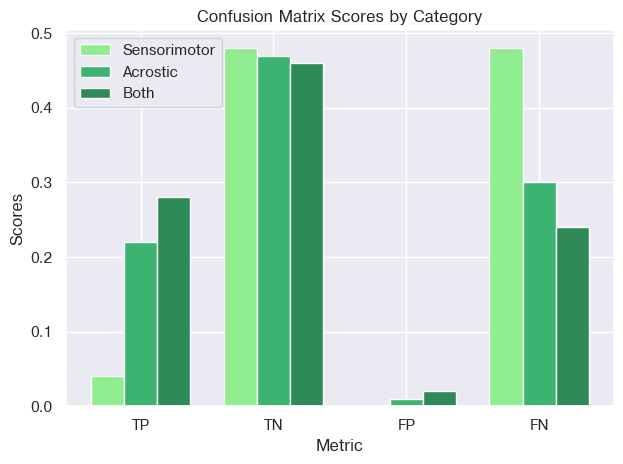

In [7]:
import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns
sns.set_theme()

#plt.style.use('seaborn-whitegrid')
plt.rcParams['font.family'] = 'Helvetica'
# Setting a light gray background color
fig.patch.set_facecolor('#f7f7f7')

# Data from the table
labels = ['TP', 'TN', 'FP', 'FN']
sensorimotor = [0.04, 0.48, 0.0, 0.48]
acrostic = [0.22, 0.47, 0.01, 0.30]
both = [0.28, 0.46, 0.02, 0.24]

# Indices and bar width
index = np.arange(len(labels))
bar_width = 0.25

# Plotting
fig, ax = plt.subplots()
bar1 = ax.bar(index - bar_width, sensorimotor, bar_width, label='Sensorimotor', color='lightgreen')
bar2 = ax.bar(index, acrostic, bar_width, label='Acrostic', color='mediumseagreen')
bar3 = ax.bar(index + bar_width, both, bar_width, label='Both', color='seagreen')

# Labels, title and legend
ax.set_xlabel('Metric')
ax.set_ylabel('Scores')
ax.set_title('Confusion Matrix Scores by Category')
ax.set_xticks(index)
ax.set_xticklabels(labels)
ax.legend()


# Display plot
plt.tight_layout()
plt.show()


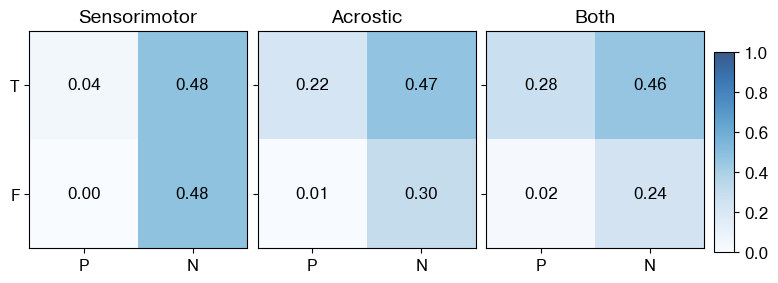

In [32]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

plt.rcParams['font.family'] = 'Helvetica'

# Updated data from the table
categories = ['Sensorimotor', 'Acrostic', 'Both']
data = np.array([
    [0.04, 0.48, 0.0, 0.48],  # Sensorimotor
    [0.22, 0.47, 0.01, 0.30],  # Acrostic
    [0.28, 0.46, 0.02, 0.24]   # Both
])

# Create a lighter colormap from the 'Blues' colormap
original_cmap = plt.cm.Blues
amount = 0.2
cmap_colors = original_cmap(np.arange(original_cmap.N))
lighter_colors = cmap_colors[:, :3] + (1.0 - cmap_colors[:, :3]) * amount
lighter_cmap = mcolors.LinearSegmentedColormap.from_list('lighter_' + original_cmap.name, lighter_colors)

# Create individual 2x2 matrices for each category
fig, axes = plt.subplots(1, 3, figsize=(10, 5), sharex=True, sharey=True)  # Reduced figsize to better fit subplots

# Set font sizes
font_size = 12  # Larger font size for better readability
plt.rc('font', size=font_size)  # controls default text sizes
plt.rc('axes', titlesize=font_size+2)  # fontsize of the axes title
plt.rc('axes', labelsize=font_size+2)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=font_size)  # fontsize of the tick labels
plt.rc('ytick', labelsize=font_size)  # fontsize of the tick labels

for idx, ax in enumerate(axes):
    # Reshape data[idx] into a 2x2 matrix
    matrix = data[idx].reshape(2, 2)
    im = ax.imshow(matrix, cmap=lighter_cmap, vmin=0, vmax=1)  # Ensure consistent color scaling
    
    # Setting axis titles and labels
    ax.set_title(categories[idx])
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(['P', 'N'])#, rotation=0, ha='right')
    ax.set_yticklabels(['T', 'F'])

    # Annotate the cells with the numeric data
    for i in range(2):
        for j in range(2):
            text = ax.text(j, i, f'{matrix[i, j]:.2f}', ha="center", va="center", color="black")

# Adjust the position of the subplots to make room for the colorbar
fig.subplots_adjust(right=0.8, wspace=0.05)
# Place the colorbar
cbar_ax = fig.add_axes([0.81, 0.27, 0.02, 0.40])  # Adjusted the right and width parameters
fig.colorbar(im, cax=cbar_ax)

# Save and show the plot
plt.savefig('matrix_translation.png', dpi=300, bbox_inches='tight')
plt.show()

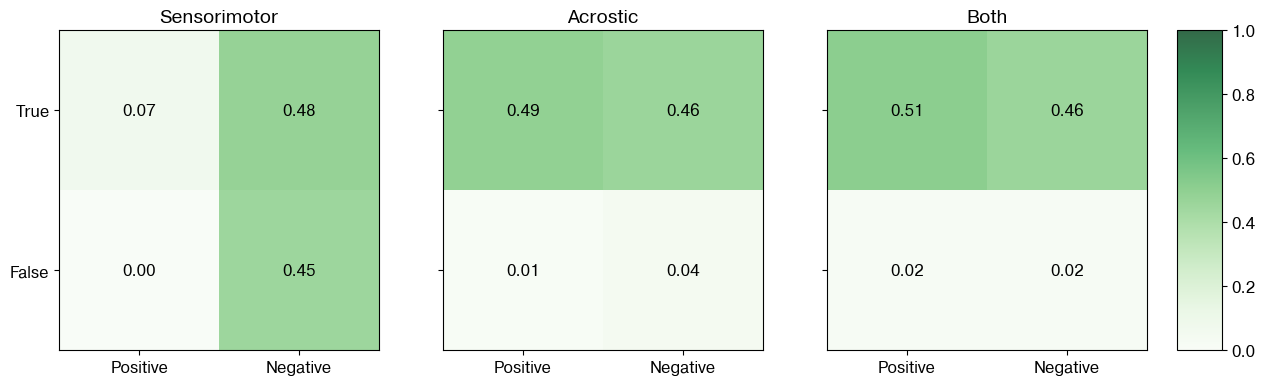

In [43]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

#plt.style.use('seaborn-whitegrid')
plt.rcParams['font.family'] = 'Helvetica'
# Updated data from the table
categories = ['Sensorimotor', 'Acrostic', 'Both']
data = np.array([
    [0.07, 0.48, 0.0, 0.45],  # Sensorimotor
    [0.49, 0.46, 0.01, 0.04],  # Acrostic
    [0.51, 0.46, 0.02, 0.02]   # Both
])
# Create a lighter colormap from the 'Oranges' colormap
original_cmap = plt.cm.Greens
amount = 0.2
cmap_colors = original_cmap(np.arange(original_cmap.N))
lighter_colors = cmap_colors[:, :3] + (1.0 - cmap_colors[:, :3]) * amount
lighter_cmap = mcolors.LinearSegmentedColormap.from_list('lighter_' + original_cmap.name, lighter_colors)

# Create individual 2x2 matrices for each category
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)  # Adjust figsize to better fit subplots

# Set font sizes
font_size = 12  # Larger font size for better readability
plt.rc('font', size=font_size)  # controls default text sizes
plt.rc('axes', titlesize=font_size+2)  # fontsize of the axes title
plt.rc('axes', labelsize=font_size+2)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=font_size)  # fontsize of the tick labels
plt.rc('ytick', labelsize=font_size)  # fontsize of the tick labels

for idx, ax in enumerate(axes):
    # Reshape data[idx] into a 2x2 matrix
    matrix = data[idx].reshape(2, 2)
    im = ax.imshow(matrix, cmap=lighter_cmap, vmin=0, vmax=1)  # Ensure consistent color scaling
    
    # Setting axis titles and labels
    ax.set_title(categories[idx])
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(['Positive', 'Negative'])
    ax.set_yticklabels(['True', 'False'])

    # Annotate the cells with the numeric data
    for i in range(2):
        for j in range(2):
            text = ax.text(j, i, f'{matrix[i, j]:.2f}', ha="center", va="center", color="black")

# Adjust the position of the subplots to make room for the colorbar
fig.subplots_adjust(right=0.85)
# Place the colorbar
cbar_ax = fig.add_axes([0.87, 0.175, 0.03, 0.64])  # Adjusted the bottom and height parameters
fig.colorbar(im, cax=cbar_ax)

# Save and show the plot
plt.savefig('matrix.png', dpi=300, bbox_inches='tight')
plt.show()

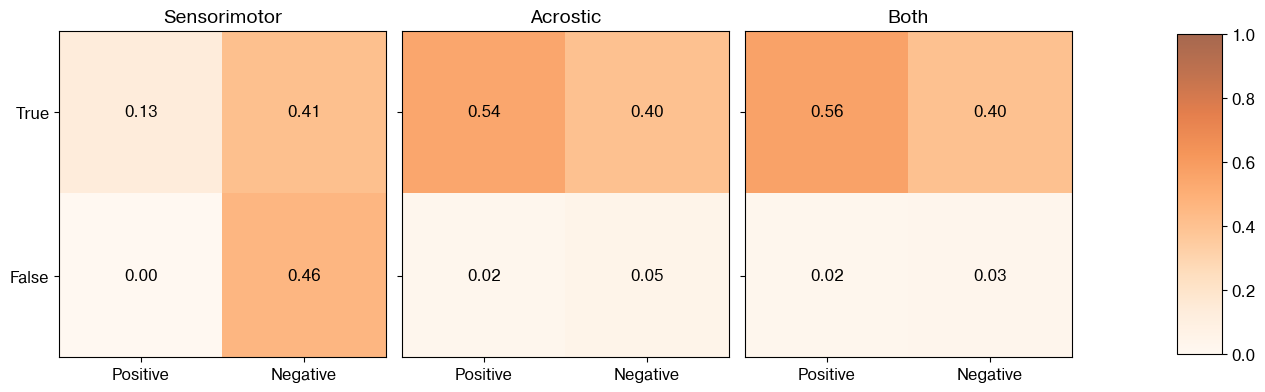

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

plt.rcParams['font.family'] = 'Helvetica'
# Data and categories
categories = ['Sensorimotor', 'Acrostic', 'Both']
data = np.array([
    [0.13, 0.41, 0.00, 0.46],  # Sensorimotor
    [0.54, 0.40, 0.02, 0.05],  # Acrostic
    [0.56, 0.40, 0.02, 0.03]   # Both
])

# Create a lighter colormap from the 'Oranges' colormap
original_cmap = plt.cm.Oranges
amount = 0.3
cmap_colors = original_cmap(np.arange(original_cmap.N))
lighter_colors = cmap_colors[:, :3] + (1.0 - cmap_colors[:, :3]) * amount
lighter_cmap = mcolors.LinearSegmentedColormap.from_list('lighter_' + original_cmap.name, lighter_colors)

# Create individual 2x2 matrices for each category
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)  # Adjust figsize to better fit subplots

# Set font sizes
font_size = 12  # Larger font size for better readability
plt.rc('font', size=font_size)  # controls default text sizes
plt.rc('axes', titlesize=font_size+2)  # fontsize of the axes title
plt.rc('axes', labelsize=font_size+2)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=font_size)  # fontsize of the tick labels
plt.rc('ytick', labelsize=font_size)  # fontsize of the tick labels

for idx, ax in enumerate(axes):
    # Reshape data[idx] into a 2x2 matrix
    matrix = data[idx].reshape(2, 2)
    im = ax.imshow(matrix, cmap=lighter_cmap, vmin=0, vmax=1)  # Ensure consistent color scaling
    
    # Setting axis titles and labels
    ax.set_title(categories[idx])
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(['Positive', 'Negative'])
    ax.set_yticklabels(['True', 'False'])

    # Annotate the cells with the numeric data
    for i in range(2):
        for j in range(2):
            text = ax.text(j, i, f'{matrix[i, j]:.2f}', ha="center", va="center", color="black")

# Adjust the position of the subplots to make room for the colorbar
fig.subplots_adjust(right=0.8, wspace=0.05)
# Place the colorbar
cbar_ax = fig.add_axes([0.87, 0.175, 0.03, 0.64])  # Adjusted the bottom and height parameters
fig.colorbar(im, cax=cbar_ax)

# Save and show the plot
plt.savefig('llama2.png', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

plt.rcParams['font.family'] = 'Helvetica'
# Data and categories
categories = ['Red/Green', 'Stylometry',]
data = np.array([
    [0.08, 0.41, 0.00, 0.46],  # Sensorimotor
    [0.1, 0.40, 0.02, 0.05],  # Acrostic
    [0.56, 0.40, 0.02, 0.03]   # Both
])

# Create a lighter colormap from the 'Oranges' colormap
original_cmap = plt.cm.Oranges
amount = 0.3
cmap_colors = original_cmap(np.arange(original_cmap.N))
lighter_colors = cmap_colors[:, :3] + (1.0 - cmap_colors[:, :3]) * amount
lighter_cmap = mcolors.LinearSegmentedColormap.from_list('lighter_' + original_cmap.name, lighter_colors)

# Create individual 2x2 matrices for each category
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)  # Adjust figsize to better fit subplots

# Set font sizes
font_size = 12  # Larger font size for better readability
plt.rc('font', size=font_size)  # controls default text sizes
plt.rc('axes', titlesize=font_size+2)  # fontsize of the axes title
plt.rc('axes', labelsize=font_size+2)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=font_size)  # fontsize of the tick labels
plt.rc('ytick', labelsize=font_size)  # fontsize of the tick labels

for idx, ax in enumerate(axes):
    # Reshape data[idx] into a 2x2 matrix
    matrix = data[idx].reshape(2, 2)
    im = ax.imshow(matrix, cmap=lighter_cmap, vmin=0, vmax=1)  # Ensure consistent color scaling
    
    # Setting axis titles and labels
    ax.set_title(categories[idx])
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    ax.set_xticklabels(['Positive', 'Negative'])
    ax.set_yticklabels(['True', 'False'])

    # Annotate the cells with the numeric data
    for i in range(2):
        for j in range(2):
            text = ax.text(j, i, f'{matrix[i, j]:.2f}', ha="center", va="center", color="black")

# Adjust the position of the subplots to make room for the colorbar
fig.subplots_adjust(right=0.8, wspace=0.05)
# Place the colorbar
cbar_ax = fig.add_axes([0.87, 0.175, 0.03, 0.64])  # Adjusted the bottom and height parameters
fig.colorbar(im, cax=cbar_ax)

# Save and show the plot
plt.savefig('llama2.png', dpi=300, bbox_inches='tight')
plt.show()
